In [1]:
!pwd

/Users/ariellubonja/prog/alans_lab/miccai_2025/Medical-Benchmark-Analysis/src/medical-benchmark-analysis


In [2]:
# If above says we're in EDA folder, do this
%cd ../..

/Users/ariellubonja/prog/alans_lab/miccai_2025/Medical-Benchmark-Analysis


# 1 - Significance Heatmap

In [5]:
fig1_save_dir = "figures/1_significance_heatmap/"
challenge_r_input_path = "data/challenge_r_outputs/df_heat.csv"

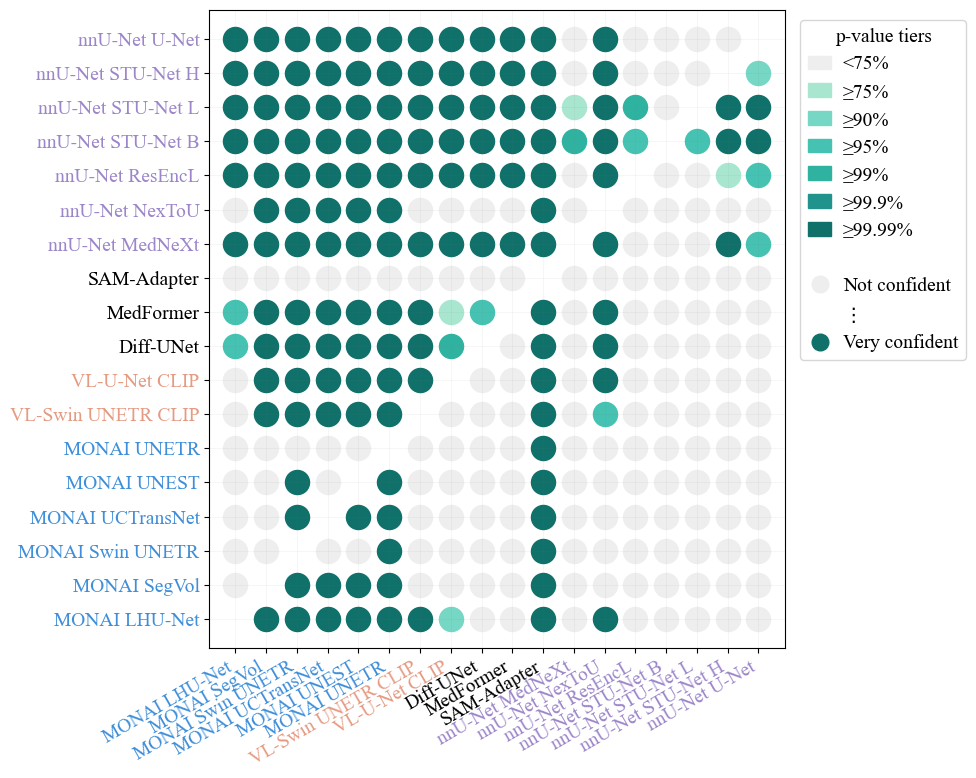

In [ ]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def confidence_heatmap_pastel(csv_path,
                              fig_path="blue.pdf",
                              figsize=(10, 8)):
    # ───────────────── font setup ───────────────────────────────────
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"]  = ["Times New Roman"]   # or ["DejaVu Serif", "Times"]
    plt.rcParams["font.size"]   = 14

    # ───────────────── helpers ──────────────────────────────────────
    def pretty(name: str) -> str:
        """MONAI_LHU-Net → MONAI LHU-Net  (underscores → spaces)."""
        name = name.replace('_', ' ')
        return re.sub(r'\s{2,}', ' ', name)

    # model-ID remapping (as in your original script)
    model_name_mapping = {
        "_Diff-UNet": "Diff-UNet",
        "_MedFormer": "MedFormer",
        "_SAM-Adapter": "SAM-Adapter",
        "Vision_Language_Swin_UNETR_CLIP": "VL-Swin_UNETR_CLIP",
        "Vision_Language_U-Net_CLIP": "VL-U-Net_CLIP",
    }

    # Bluish-gray, very nice
    tier_color_map = {
        '<75%': '#eeeeee',  # Softer, whiter gray
        '≥75%': '#a8e6cf',  # Light pastel mint
        '≥90%': '#76d7c4',  # Brighter teal
        '≥95%': '#45c2b1',  # Soft cyan-green
        '≥99%': '#30b2a1',  # Deeper teal-green
        '≥99.9%': '#20938d',  # Strong turquoise
        '≥99.99%': '#10706a',  # Deep but vibrant teal with gray undertones
    }

    # ───────────────── read & tidy ──────────────────────────────────
    df = pd.read_csv(csv_path)
    df["algoRow"] = df["algoRow"].replace(model_name_mapping).map(pretty)
    df["algoCol"] = df["algoCol"].replace(model_name_mapping).map(pretty)
    df["confidenceTier"] = (df["confidenceTier"].astype(str)
                            .str.replace(r"<U\+2265>", "≥", regex=True))
    df.replace("NA", pd.NA, inplace=True)

    # ───────────────── fixed ordering ───────────────────────────────
    model_order = [
        # MONAI family
        'MONAI LHU-Net', 'MONAI SegVol', 'MONAI Swin UNETR',
        'MONAI UCTransNet', 'MONAI UNEST', 'MONAI UNETR',
        # VL family
        'VL-Swin UNETR CLIP', 'VL-U-Net CLIP',
        # diffusion / misc
        'Diff-UNet', 'MedFormer', 'SAM-Adapter',
        # nnU-Net family (B < L < H)
        'nnU-Net MedNeXt', 'nnU-Net NexToU', 'nnU-Net ResEncL',
        'nnU-Net STU-Net B', 'nnU-Net STU-Net L', 'nnU-Net STU-Net H',
        'nnU-Net U-Net',
    ]
    row_index = {m: i for i, m in enumerate(model_order)}
    col_index = row_index

    # ───────────────── plot ─────────────────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in df.iterrows():
        r, c = row['algoRow'], row['algoCol']
        if r not in row_index or c not in col_index:
            continue                       # skip labels not in model_order
        x, y = col_index[c], row_index[r]
        ax.scatter(x, y,
                   color=tier_color_map.get(row['confidenceTier'], 'white'),
                   s=300)

    # ticks & labels
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=30, ha='right')
    ax.set_yticks(range(len(model_order)))
    ax.set_yticklabels(model_order)

    # choose one palette dict
    palette = {
        'MONAI':   '#3E8ED9',   # darker sky-blue
        'VL-':     '#E59A82',   # darker coral
        'nnU-Net': '#9C86C9',   # darker lilac
    }

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        lbl = tick.get_text()
        if lbl.startswith('MONAI'):
            tick.set_color(palette['MONAI'])
        elif lbl.startswith('VL-'):
            tick.set_color(palette['VL-'])
        elif lbl.startswith('nnU-Net'):
            tick.set_color(palette['nnU-Net'])

    # light grid
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

    # ───────── legend: tiers + qualitative key ──────────────────────
    tier_patches = [mpatches.Patch(color=col, label=lab)
                    for lab, col in tier_color_map.items()]
    very_conf = mlines.Line2D([], [], marker='o', linestyle='None',
                              markerfacecolor=tier_color_map['≥99.99%'],
                              markeredgecolor=tier_color_map['≥99.99%'],
                              markersize=12, label='Very confident')
    not_conf  = mlines.Line2D([], [], marker='o', linestyle='None',
                              markerfacecolor=tier_color_map['<75%'],
                              markeredgecolor=tier_color_map['<75%'],
                              markersize=12, label='Not confident')
    blank     = mlines.Line2D([], [], linestyle='None', label='')
    vdots     = mlines.Line2D([], [], linestyle='None', label=r'$\vdots$')

    handles = tier_patches + [blank, not_conf, vdots, very_conf]
    ax.legend(handles=handles, title='p-value tiers',
              bbox_to_anchor=(1.01, 1), loc='upper left',
              handlelength=1.2, handletextpad=0.6)

    fig.tight_layout()
    fig.savefig(fig_path, format='pdf', dpi=300)
    plt.show()

# example use:
confidence_heatmap_pastel(challenge_r_input_path, fig_path=os.path.join(fig1_save_dir, "blue.pdf"))

## Two-sided heatmap

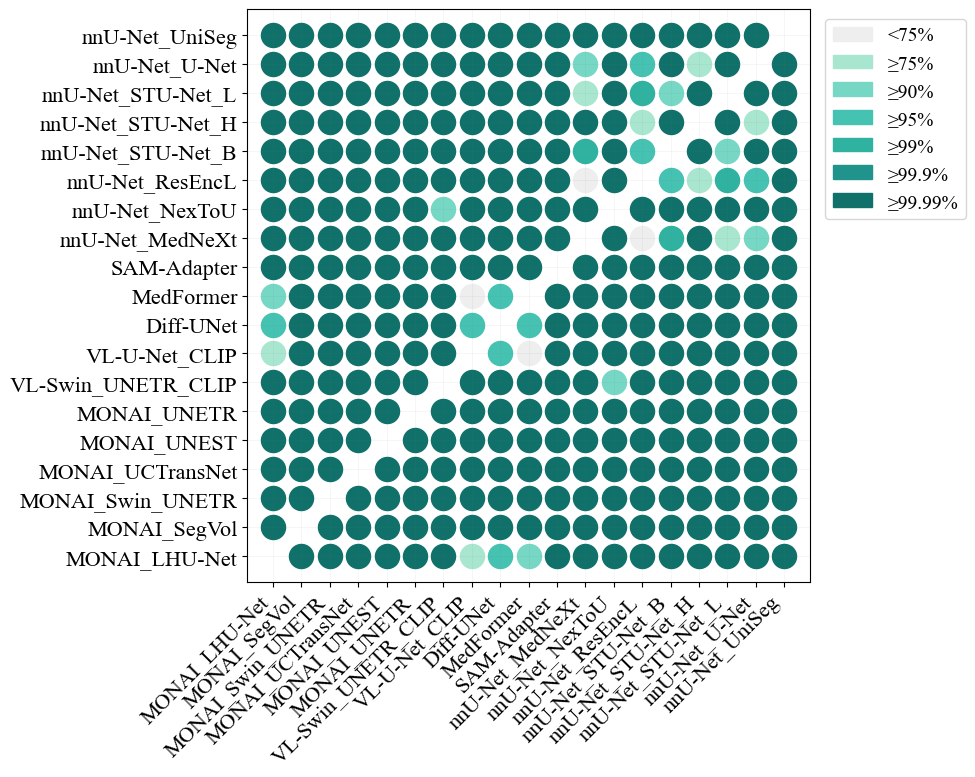

In [13]:
confidence_heatmap_pastel("df_heat_two_sided.csv")

## Shaded

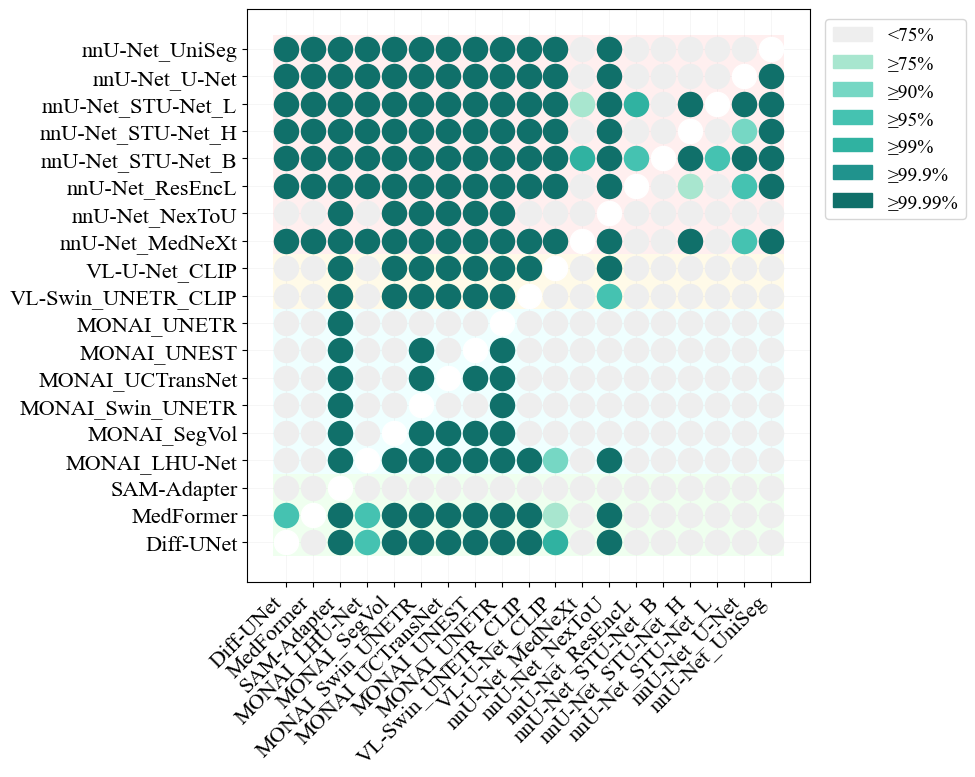

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def confidence_heatmap_pastel(csv_path='df_heat.csv'):
    # -----------------------------
    # 1) Read CSV and set up fonts
    # -----------------------------
    df = pd.read_csv(csv_path)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams["font.size"] = 14

    # -----------------------------
    # 2) Optional name mapping
    # -----------------------------
    model_name_mapping = {
        "_Diff-UNet": "Diff-UNet",
        "_MedFormer": "MedFormer",
        "_SAM-Adapter": "SAM-Adapter",
        "Vision_Language_Swin_UNETR_CLIP": "VL-Swin_UNETR_CLIP",
        "Vision_Language_U-Net_CLIP": "VL-U-Net_CLIP"
    }
    df["algoRow"] = df["algoRow"].replace(model_name_mapping)
    df["algoCol"] = df["algoCol"].replace(model_name_mapping)

    # -----------------------------
    # 3) Clean up confidence tier
    # -----------------------------
    df['confidenceTier'] = (
        df['confidenceTier']
        .astype(str)
        .str.replace("<U\+2265>", "≥", regex=True)
    )
    df.replace("NA", np.nan, inplace=True)

    # -----------------------------
    # 4) Grouping function
    # -----------------------------
    def get_model_group(name):
        """
        Return a group label for the given model name.
        Adjust logic as needed for your actual naming patterns.
        """
        if name.startswith("nnU-Net"):
            return "nnU-Net"
        elif name.startswith("MONAI_"):
            return "MONAI"
        elif ("Diff-UNet" in name) or ("MedFormer" in name) or ("SAM-Adapter" in name):
            return "DiffMedSAM"
        elif name.startswith("VL-"):  # e.g. "VL-Swin...", "VL-U-..."
            return "VisionLang"
        else:
            return "Other"

    # -----------------------------
    # 5) Sort rows & columns by group
    # -----------------------------
    unique_rows = df['algoRow'].unique()
    unique_cols = df['algoCol'].unique()

    # Sort so that all rows in the same group are consecutive
    sorted_rows = sorted(unique_rows, key=lambda x: (get_model_group(x), x))
    sorted_cols = sorted(unique_cols, key=lambda x: (get_model_group(x), x))

    row_index = {val: i for i, val in enumerate(sorted_rows)}
    col_index = {val: i for i, val in enumerate(sorted_cols)}

    # -----------------------------
    # 6) Define color maps
    # -----------------------------
    # a) Confidence tier -> color for scatter points
    tier_color_map = {
        '<75%': '#eeeeee',
        '≥75%': '#a8e6cf',
        '≥90%': '#76d7c4',
        '≥95%': '#45c2b1',
        '≥99%': '#30b2a1',
        '≥99.9%': '#20938d',
        '≥99.99%': '#10706a'
    }

    # b) Group -> color for shading
    group_color_map = {
        "nnU-Net":     "#ffcccc",  # pastel red
        "MONAI":       "#ccffff",  # pastel blue
        "DiffMedSAM":  "#ccffcc",  # pastel green
        "VisionLang":  "#fff0b3",  # pastel yellow
        "Other":       "#f0f0f0"   # light gray
    }

    # -----------------------------
    # 7) Prepare the figure
    # -----------------------------
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # -----------------------------
    # 8) Shading entire row group
    # -----------------------------
    # Build a map of group -> [list of row labels in that group]
    grouped_rows = defaultdict(list)
    for r in sorted_rows:
        grouped_rows[get_model_group(r)].append(r)

    # For each group, draw a horizontal band that covers its row range
    for group_name, row_labels in grouped_rows.items():
        idxs = [row_index[r] for r in row_labels]
        if not idxs:
            continue
        min_idx, max_idx = min(idxs), max(idxs)

        # The rectangle covers from x = -0.5 to x = len(cols)-0.5
        # for the row range [min_idx, max_idx]
        color_for_group = group_color_map.get(group_name, "#e0e0e0")
        rect = mpatches.Rectangle(
            xy=(-0.5, min_idx - 0.5),
            width=len(sorted_cols),
            height=(max_idx - min_idx + 1),
            facecolor=color_for_group,
            alpha=0.3,       # Set higher alpha if you want it more opaque
            zorder=0         # behind the scatter (which is typically zorder=2 or so)
        )
        ax.add_patch(rect)

    # -----------------------------
    # 9) (OPTIONAL) Shading only near the y-axis labels
    # -----------------------------
    # Uncomment this if you want a band behind the row labels (Method A) instead:
    #
    # for group_name, row_labels in grouped_rows.items():
    #     idxs = [row_index[r] for r in row_labels]
    #     if not idxs:
    #         continue
    #     min_idx, max_idx = min(idxs), max(idxs)
    #
    #     color_for_group = group_color_map.get(group_name, "#e0e0e0")
    #     rect_axis = mpatches.Rectangle(
    #         xy=(-1.0, min_idx - 0.5),
    #         width=0.95,  # from x=-1.0 to about x=-0.05
    #         height=(max_idx - min_idx + 1),
    #         facecolor=color_for_group,
    #         alpha=0.3,
    #         zorder=0
    #     )
    #     ax.add_patch(rect_axis)

    # -----------------------------
    # 10) Scatter plot
    # -----------------------------
    for _, row_data in df.iterrows():
        r = row_data['algoRow']
        c = row_data['algoCol']
        tier = row_data['confidenceTier']
        color = tier_color_map.get(tier, 'white')
        x = col_index[c]
        y = row_index[r]
        # By default, scatter points have zorder=2.
        # Our shading rectangles have zorder=0 -> means shading is behind
        plt.scatter(x, y, color=color, s=300, zorder=2)

    # -----------------------------
    # 11) Axes, ticks, legend
    # -----------------------------
    plt.xticks(range(len(sorted_cols)), sorted_cols, rotation=45, ha='right', fontsize=16)
    plt.yticks(range(len(sorted_rows)), sorted_rows, fontsize=16)
    # plt.xlabel("Method B", fontsize=21)
    # plt.ylabel("Method A", fontsize=21)
    # plt.title("Statistical Significance: Method A (Left) > Method B (Bottom)", fontsize=23)

    # Construct a legend for tiers
    patches = [mpatches.Patch(color=v, label=k) for k, v in tier_color_map.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.1)
    plt.tight_layout()

    plt.savefig(os.path.join(fig1_save_dir, "/shaded/fig1_stat_sign_shaded.pdf"), format='pdf', dpi=300)
    plt.show()

confidence_heatmap_pastel()

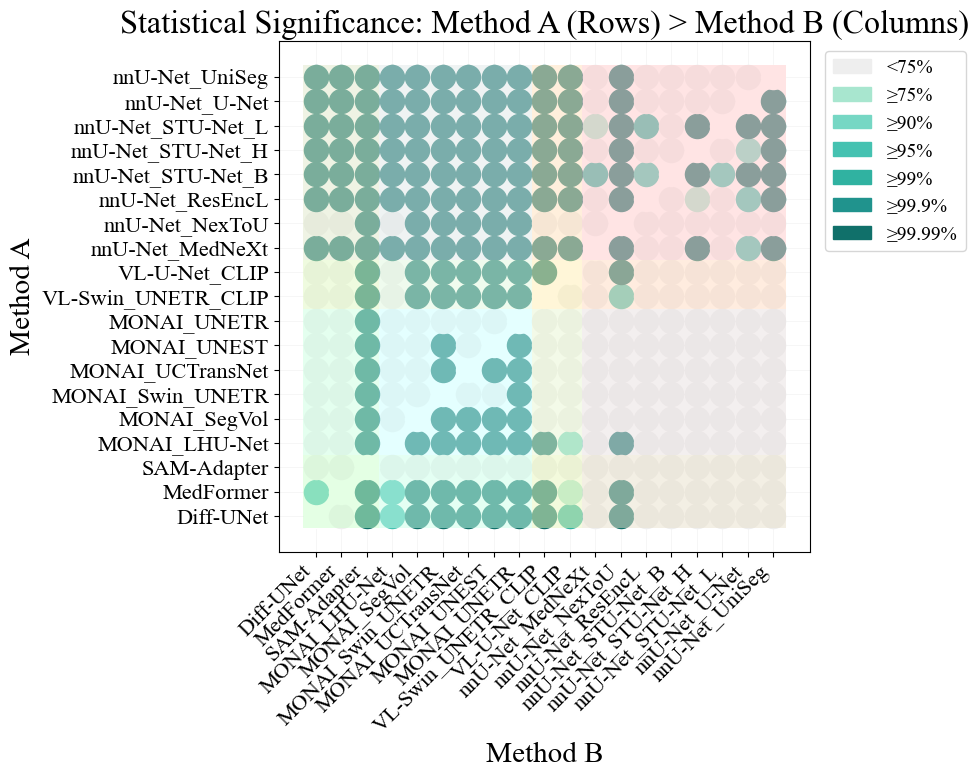

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def confidence_heatmap_pastel(csv_path='df_heat.csv'):
    # ------------------------------------------------------
    # 1) Read CSV and set up fonts
    # ------------------------------------------------------
    df = pd.read_csv(csv_path)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams["font.size"] = 14

    # ------------------------------------------------------
    # 2) (Optional) Clean up model names
    # ------------------------------------------------------
    model_name_mapping = {
        "_Diff-UNet": "Diff-UNet",
        "_MedFormer": "MedFormer",
        "_SAM-Adapter": "SAM-Adapter",
        "Vision_Language_Swin_UNETR_CLIP": "VL-Swin_UNETR_CLIP",
        "Vision_Language_U-Net_CLIP": "VL-U-Net_CLIP"
    }
    df["algoRow"] = df["algoRow"].replace(model_name_mapping)
    df["algoCol"] = df["algoCol"].replace(model_name_mapping)

    # ------------------------------------------------------
    # 3) Clean up confidence tier
    # ------------------------------------------------------
    df['confidenceTier'] = df['confidenceTier'].astype(str).str.replace("<U\+2265>", "≥", regex=True)
    df.replace("NA", np.nan, inplace=True)

    # ------------------------------------------------------
    # 4) Grouping logic
    # ------------------------------------------------------
    def get_model_group(name):
        """
        Return a group label for the given model name.
        Adjust logic as needed for your actual naming patterns.
        """
        if name.startswith("nnU-Net"):
            return "nnU-Net"
        elif name.startswith("MONAI_"):
            return "MONAI"
        elif ("Diff-UNet" in name) or ("MedFormer" in name) or ("SAM-Adapter" in name):
            return "DiffMedSAM"
        elif name.startswith("VL-"):  # e.g. "VL-Swin..." or "VL-U-..."
            return "VisionLang"
        else:
            return "Other"

    # ------------------------------------------------------
    # 5) Sort rows & columns by group, then name
    # ------------------------------------------------------
    unique_rows = df['algoRow'].unique()
    unique_cols = df['algoCol'].unique()

    sorted_rows = sorted(unique_rows, key=lambda x: (get_model_group(x), x))
    sorted_cols = sorted(unique_cols, key=lambda x: (get_model_group(x), x))

    row_index = {val: i for i, val in enumerate(sorted_rows)}
    col_index = {val: i for i, val in enumerate(sorted_cols)}

    # ------------------------------------------------------
    # 6) Define color maps
    # ------------------------------------------------------
    # a) Confidence tier -> color for scatter points
    tier_color_map = {
        '<75%': '#eeeeee',
        '≥75%': '#a8e6cf',
        '≥90%': '#76d7c4',
        '≥95%': '#45c2b1',
        '≥99%': '#30b2a1',
        '≥99.9%': '#20938d',
        '≥99.99%': '#10706a'
    }

    # b) Group -> color for shading
    #    Adjust colors to your taste:
    group_color_map = {
        "nnU-Net":     "#ffcccc",  # pastel red
        "MONAI":       "#ccffff",  # pastel blue
        "DiffMedSAM":  "#ccffcc",  # pastel green
        "VisionLang":  "#fff0b3",  # pastel yellow
        "Other":       "#f0f0f0"   # light gray
    }

    # ------------------------------------------------------
    # 7) Create figure and axes
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # ------------------------------------------------------
    # 8) Shade entire row blocks
    # ------------------------------------------------------
    # Group the rows by their group
    grouped_rows = defaultdict(list)
    for r in sorted_rows:
        grouped_rows[get_model_group(r)].append(r)

    # For each group, draw one large horizontal band covering those rows
    for group_name, row_labels in grouped_rows.items():
        idxs = [row_index[r] for r in row_labels]
        if not idxs:
            continue
        min_idx, max_idx = min(idxs), max(idxs)

        color_for_group = group_color_map.get(group_name, "#e0e0e0")
        # The band extends across all columns (x = -0.5 to len(cols)-0.5)
        rect_row = mpatches.Rectangle(
            xy=(-0.5, min_idx - 0.5),
            width=len(sorted_cols),
            height=(max_idx - min_idx + 1),
            facecolor=color_for_group,
            alpha=0.3,   # Lower alpha so intersection with columns is visible
            zorder=4     # We'll put columns shading above this (zorder=2)
        )
        ax.add_patch(rect_row)

    # ------------------------------------------------------
    # 9) Shade entire column blocks
    # ------------------------------------------------------
    # Group the columns by their group
    grouped_cols = defaultdict(list)
    for c in sorted_cols:
        grouped_cols[get_model_group(c)].append(c)

    # For each group, draw one large vertical band covering those columns
    for group_name, col_labels in grouped_cols.items():
        idxs = [col_index[c] for c in col_labels]
        if not idxs:
            continue
        min_idx, max_idx = min(idxs), max(idxs)

        color_for_group = group_color_map.get(group_name, "#e0e0e0")
        # The band extends across all rows (y = -0.5 to len(rows)-0.5)
        rect_col = mpatches.Rectangle(
            xy=(min_idx - 0.5, -0.5),
            width=(max_idx - min_idx + 1),
            height=len(sorted_rows),
            facecolor=color_for_group,
            alpha=0.3,   # Same alpha -> intersection is alpha-blended
            zorder=4     # Above row shading, so intersection is "darker"
        )
        ax.add_patch(rect_col)

    # ------------------------------------------------------
    # 10) Scatter plot (the actual heatmap dots)
    # ------------------------------------------------------
    for _, row_data in df.iterrows():
        row_label = row_data['algoRow']
        col_label = row_data['algoCol']
        tier = row_data['confidenceTier']

        color = tier_color_map.get(tier, 'white')
        x = col_index[col_label]
        y = row_index[row_label]

        # scatter points typically have zorder=3, so they'll be on top
        plt.scatter(x, y, color=color, s=300, zorder=3)

    # ------------------------------------------------------
    # 11) Configure ticks & labels
    # ------------------------------------------------------
    plt.xticks(range(len(sorted_cols)), sorted_cols, rotation=45, ha='right', fontsize=16)
    plt.yticks(range(len(sorted_rows)), sorted_rows, fontsize=16)
    plt.xlabel("Method B", fontsize=21)
    plt.ylabel("Method A", fontsize=21)
    plt.title("Statistical Significance: Method A (Rows) > Method B (Columns)", fontsize=23)

    # Construct a legend for confidence tiers
    patches = [mpatches.Patch(color=v, label=k) for k, v in tier_color_map.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.1)
    plt.tight_layout()
    plt.savefig("figures/fig2_stat_sign_shaded_rows_cols.pdf", format='pdf', dpi=300)
    plt.show()


confidence_heatmap_pastel()

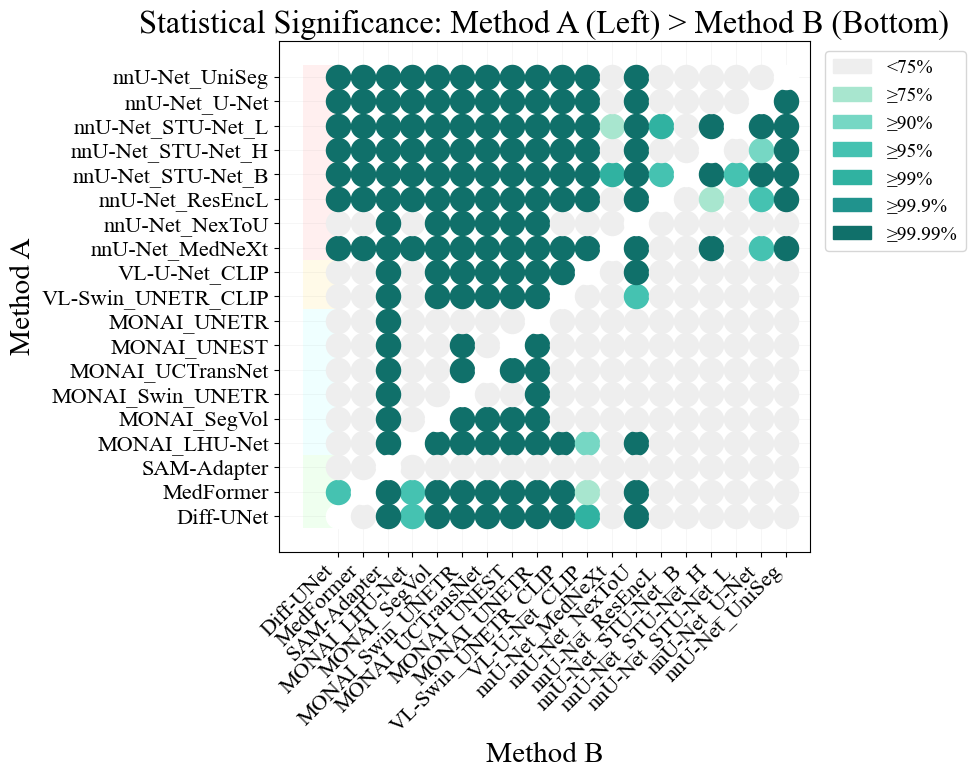

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

def confidence_heatmap_pastel(csv_path='df_heat.csv'):
    # 1) Read CSV & set fonts
    df = pd.read_csv(csv_path)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams["font.size"] = 14

    # 2) Optional model-name cleaning
    model_name_mapping = {
        "_Diff-UNet": "Diff-UNet",
        "_MedFormer": "MedFormer",
        "_SAM-Adapter": "SAM-Adapter",
        "Vision_Language_Swin_UNETR_CLIP": "VL-Swin_UNETR_CLIP",
        "Vision_Language_U-Net_CLIP": "VL-U-Net_CLIP"
    }
    df["algoRow"] = df["algoRow"].replace(model_name_mapping)
    df["algoCol"] = df["algoCol"].replace(model_name_mapping)

    # 3) Clean up confidence tier
    df['confidenceTier'] = (
        df['confidenceTier'].astype(str)
                            .str.replace("<U\+2265>", "≥", regex=True)
    )
    df.replace("NA", np.nan, inplace=True)

    # 4) Grouping function
    def get_model_group(name):
        if name.startswith("nnU-Net"):
            return "nnU-Net"
        elif name.startswith("MONAI_"):
            return "MONAI"
        elif ("Diff-UNet" in name) or ("MedFormer" in name) or ("SAM-Adapter" in name):
            return "DiffMedSAM"
        elif name.startswith("VL-"):
            return "VisionLang"
        else:
            return "Other"

    # 5) Sort rows & columns by group
    unique_rows = df['algoRow'].unique()
    unique_cols = df['algoCol'].unique()

    sorted_rows = sorted(unique_rows, key=lambda x: (get_model_group(x), x))
    sorted_cols = sorted(unique_cols, key=lambda x: (get_model_group(x), x))

    row_index = {val: i for i, val in enumerate(sorted_rows)}
    col_index = {val: i for i, val in enumerate(sorted_cols)}

    # 6) Define color maps
    tier_color_map = {
        '<75%': '#eeeeee',
        '≥75%': '#a8e6cf',
        '≥90%': '#76d7c4',
        '≥95%': '#45c2b1',
        '≥99%': '#30b2a1',
        '≥99.9%': '#20938d',
        '≥99.99%': '#10706a'
    }

    # Different color per group
    group_color_map = {
        "nnU-Net":     "#ffcccc",
        "MONAI":       "#ccffff",
        "DiffMedSAM":  "#ccffcc",
        "VisionLang":  "#fff0b3",
        "Other":       "#f0f0f0"
    }

    # 7) Prepare figure
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # 8) (OPTIONAL) If you do *not* want shading in the heatmap, skip that step.
    #    We'll comment it out to focus purely on shading behind the y-tick labels.
    #
    # grouped_rows_for_full_shading = defaultdict(list)
    # for r in sorted_rows:
    #     grouped_rows_for_full_shading[get_model_group(r)].append(r)
    # for group_name, row_labels in grouped_rows_for_full_shading.items():
    #     idxs = [row_index[r] for r in row_labels]
    #     if not idxs:
    #         continue
    #     min_idx, max_idx = min(idxs), max(idxs)
    #     rect = mpatches.Rectangle(
    #         xy=(-0.5, min_idx - 0.5),
    #         width=len(sorted_cols),
    #         height=(max_idx - min_idx + 1),
    #         facecolor=group_color_map.get(group_name, "#e0e0e0"),
    #         alpha=0.3,
    #         zorder=0
    #     )
    #     ax.add_patch(rect)

    # 9) Shading behind the y-axis labels only
    grouped_rows = defaultdict(list)
    for r in sorted_rows:
        grouped_rows[get_model_group(r)].append(r)

    # We add a rectangle in "data coordinates" that sits left of x=0,
    # and from y=(min_idx - 0.5) to y=(max_idx + 0.5).
    # Then we do "clip_on=False" so it appears outside the data area.
    for group_name, row_labels in grouped_rows.items():
        idxs = [row_index[r] for r in row_labels]
        if not idxs:
            continue
        min_idx, max_idx = min(idxs), max(idxs)

        color_for_group = group_color_map.get(group_name, "#e0e0e0")
        rect_axis = mpatches.Rectangle(
            xy=(-1.4, min_idx - 0.5),   # shift far enough left to be behind labels
            width=1.3,                 # up to x=-0.1 or so
            height=(max_idx - min_idx + 1),
            facecolor=color_for_group,
            alpha=0.3,
            zorder=0,           # behind the scatter
            clip_on=False       # critical to see it outside the axes
        )
        ax.add_patch(rect_axis)

    # 10) Scatter
    for _, row_data in df.iterrows():
        r = row_data['algoRow']
        c = row_data['algoCol']
        tier = row_data['confidenceTier']
        color = tier_color_map.get(tier, 'white')
        x = col_index[c]
        y = row_index[r]
        plt.scatter(x, y, color=color, s=300, zorder=2)

    # 11) Format
    plt.xticks(range(len(sorted_cols)), sorted_cols, rotation=45, ha='right', fontsize=16)
    plt.yticks(range(len(sorted_rows)), sorted_rows, fontsize=16)
    plt.xlabel("Method B", fontsize=21)
    plt.ylabel("Method A", fontsize=21)
    plt.title("Statistical Significance: Method A (Left) > Method B (Bottom)", fontsize=23)

    # Legend for the scatter color
    patches = [mpatches.Patch(color=v, label=k) for k, v in tier_color_map.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.1)
    plt.tight_layout()

    # If you need more margin on the left (so your shading is fully visible),
    # increase it, e.g.:
    # plt.subplots_adjust(left=0.25)

    plt.savefig("figures/fig2_stat_sign_shaded_axis_only.pdf", dpi=300)
    plt.show()


# Run it
confidence_heatmap_pastel()

## Interpolation - currently broken

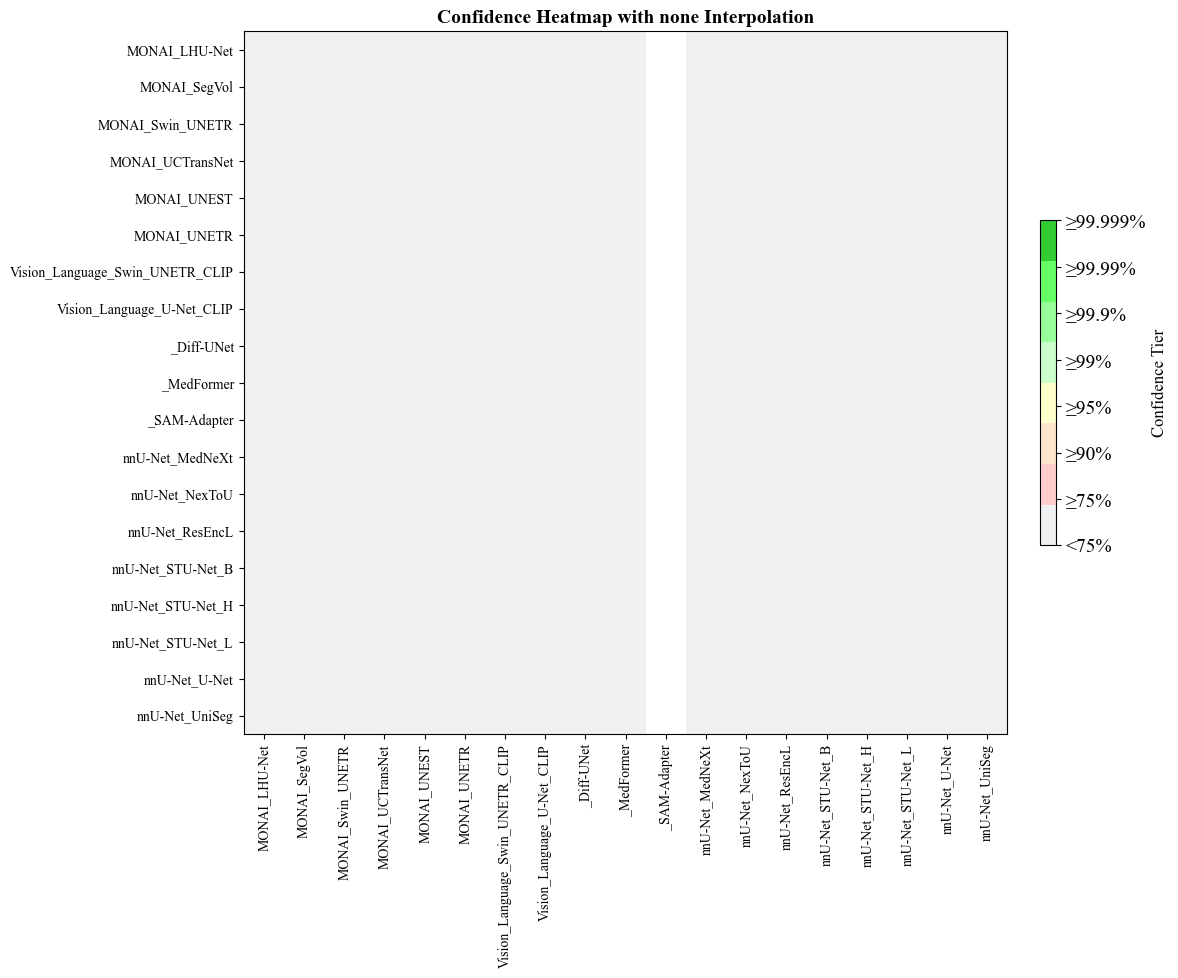

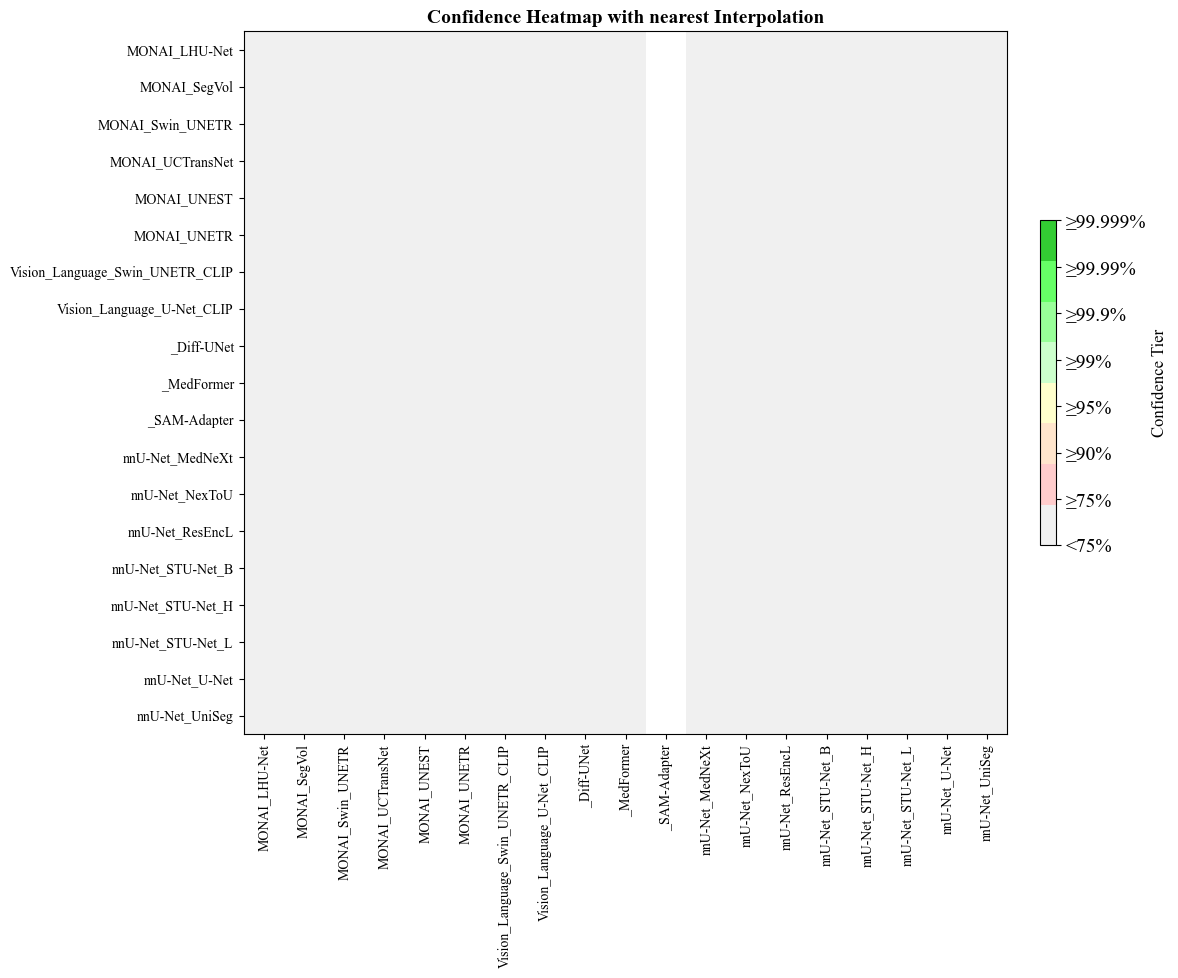

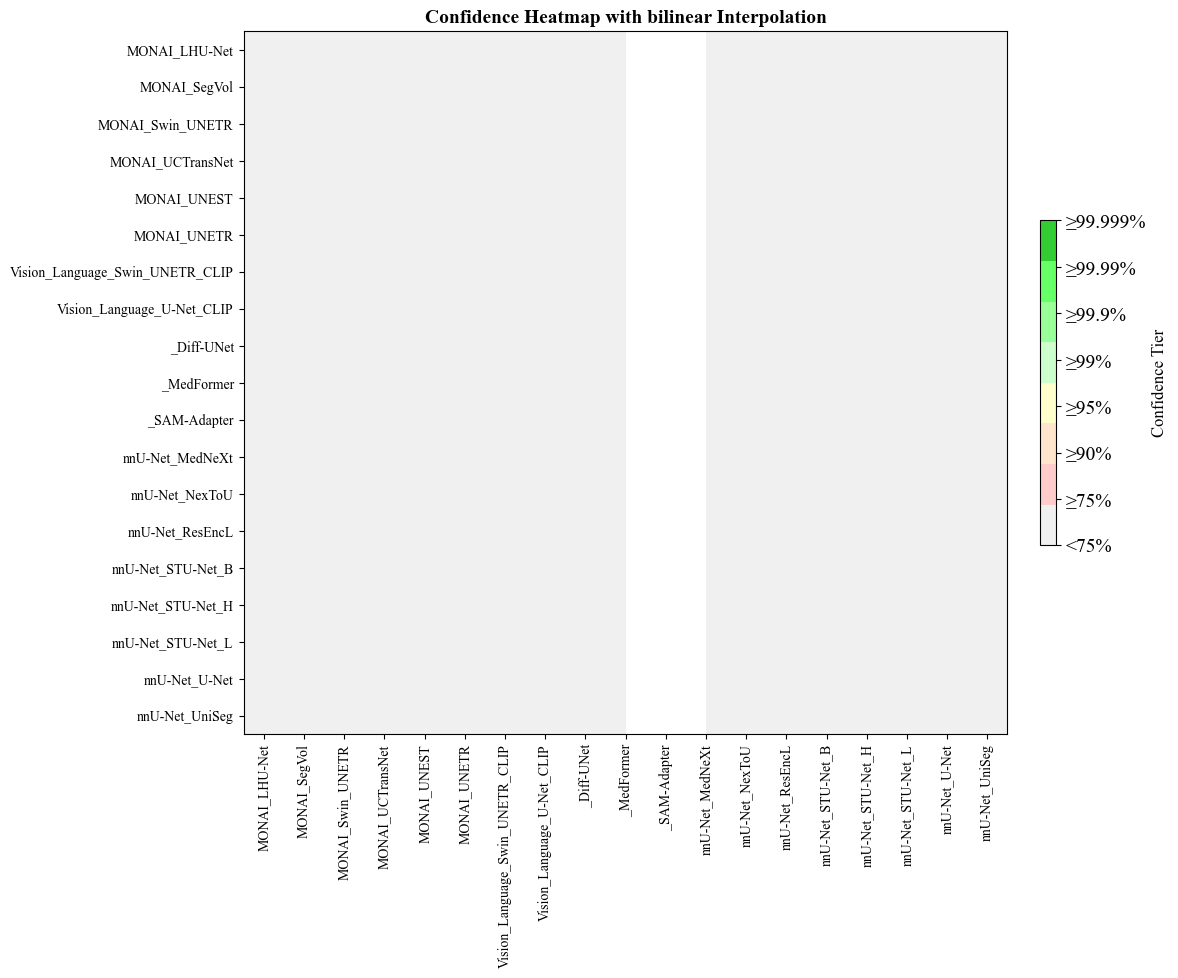

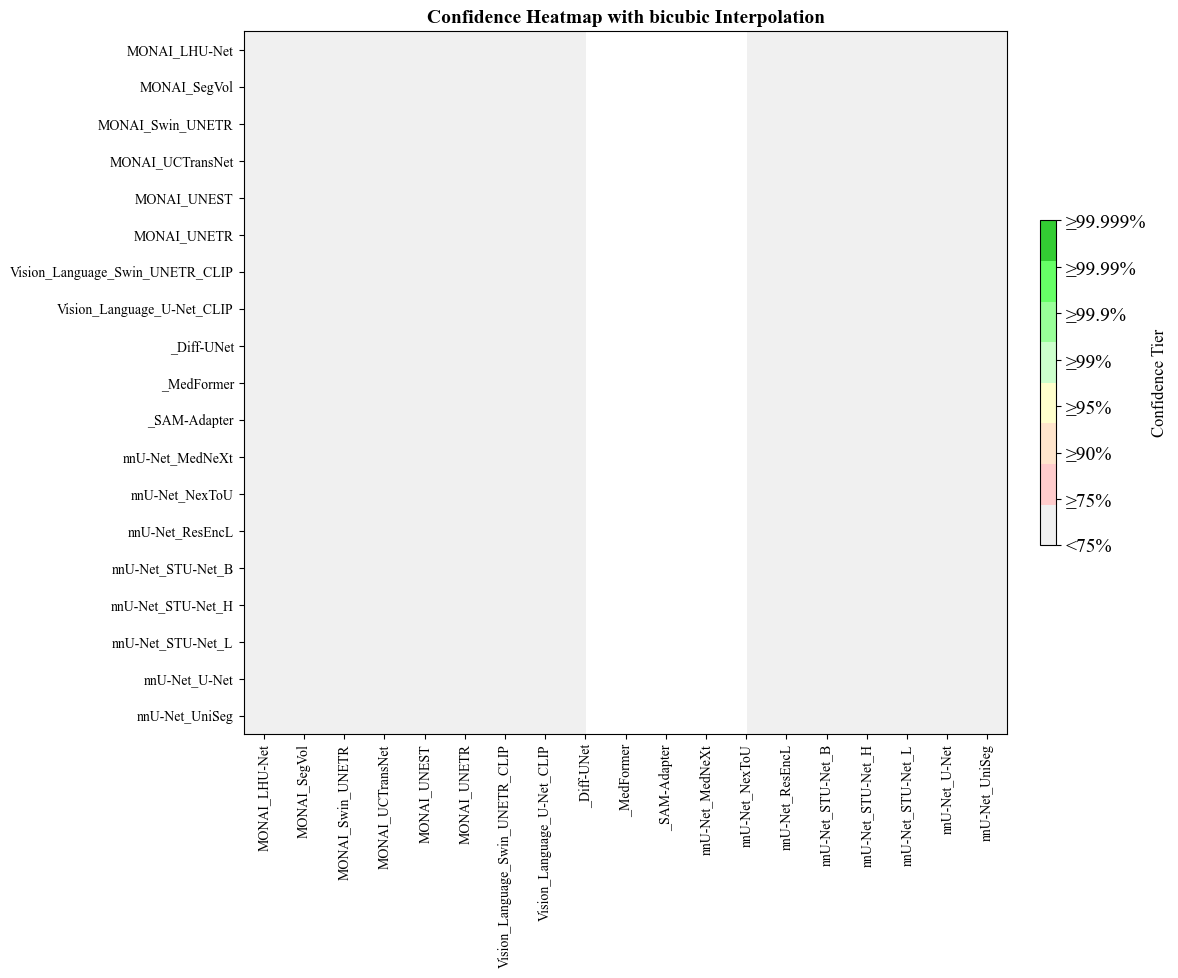

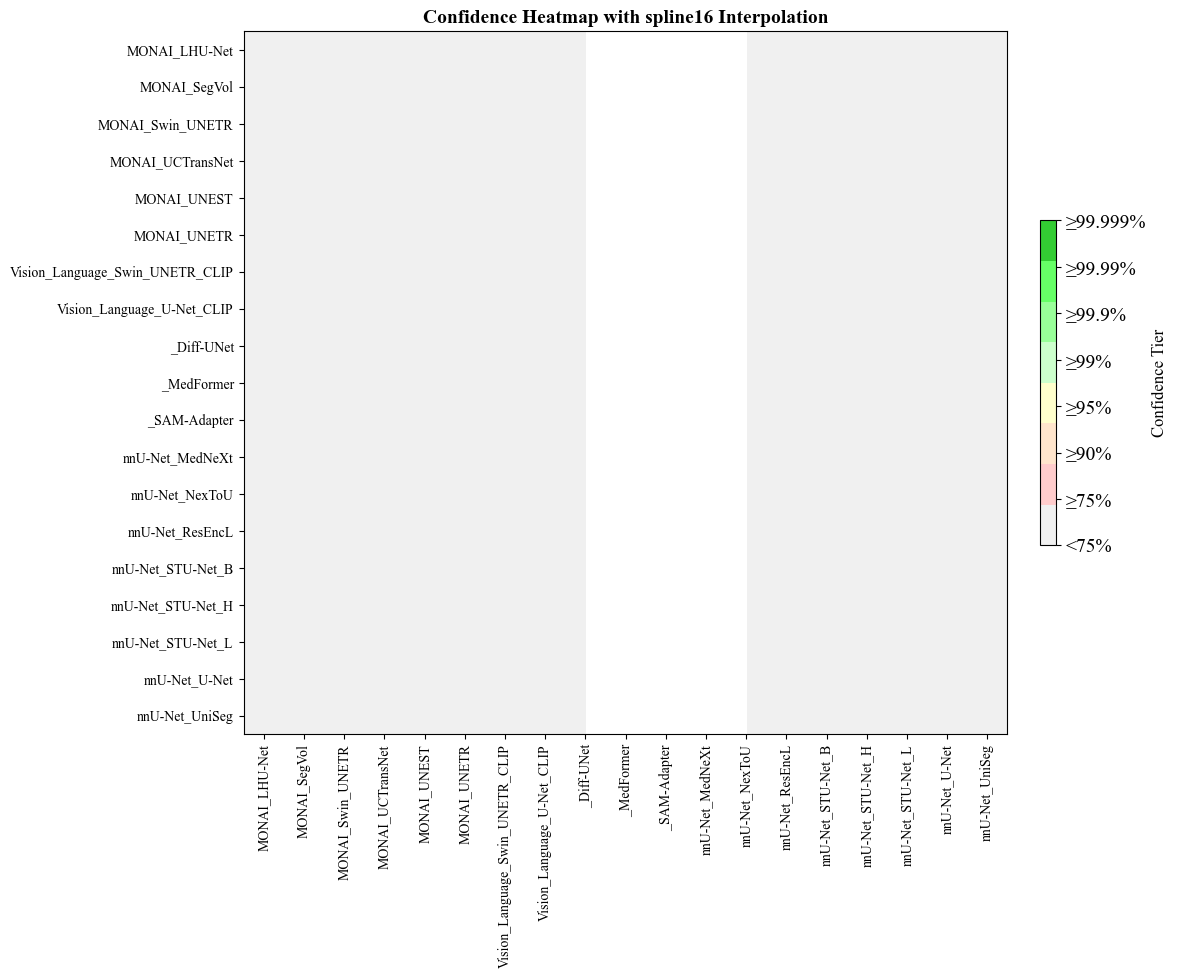

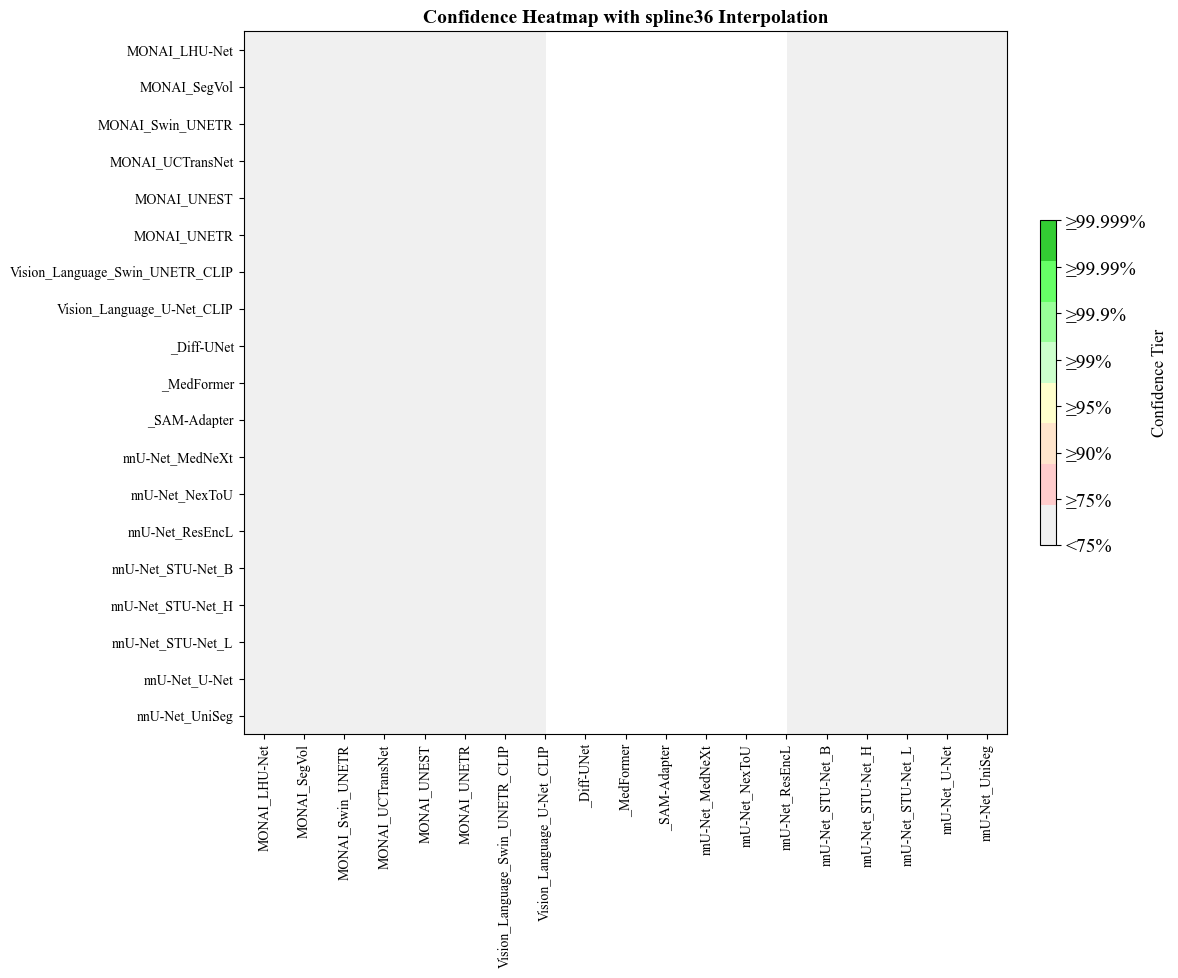

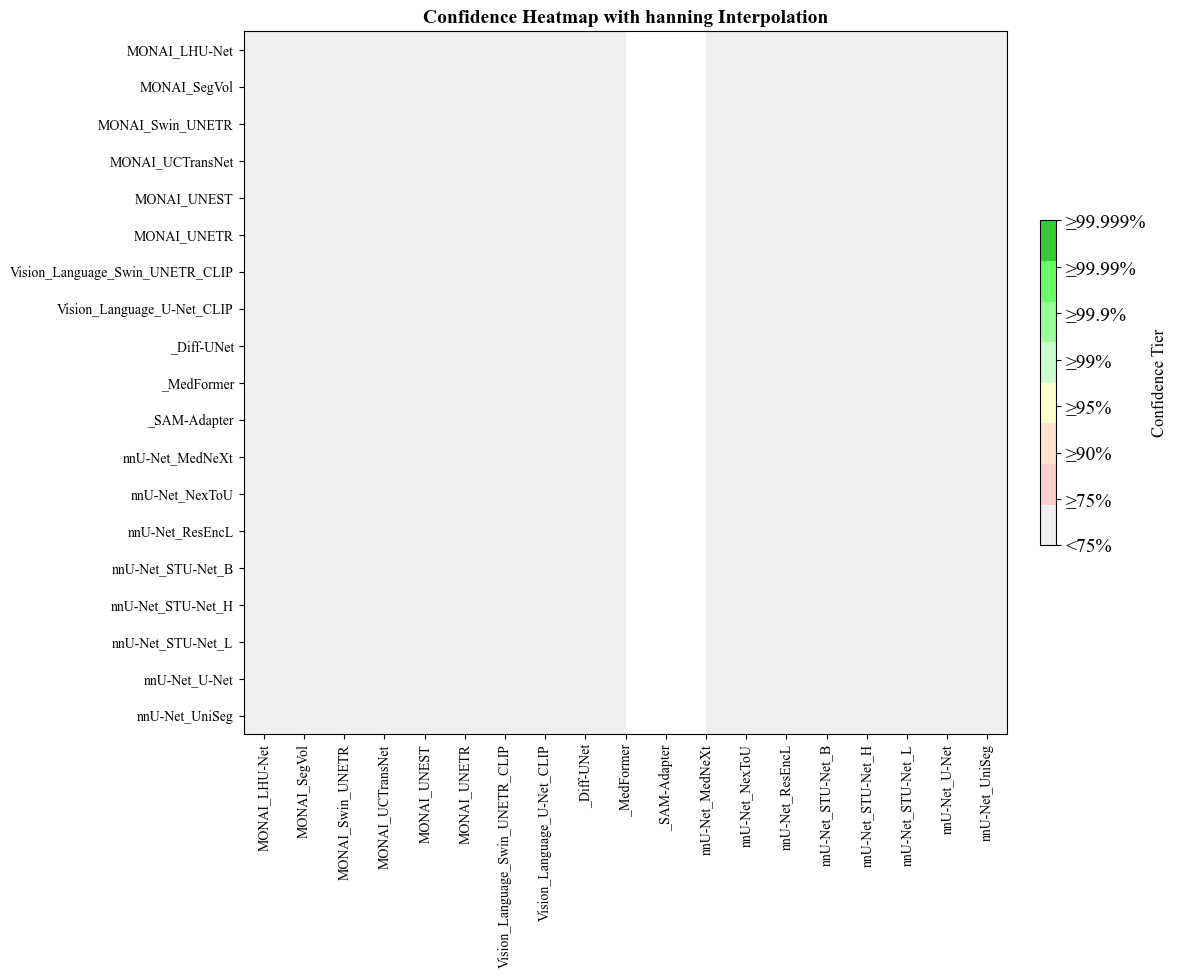

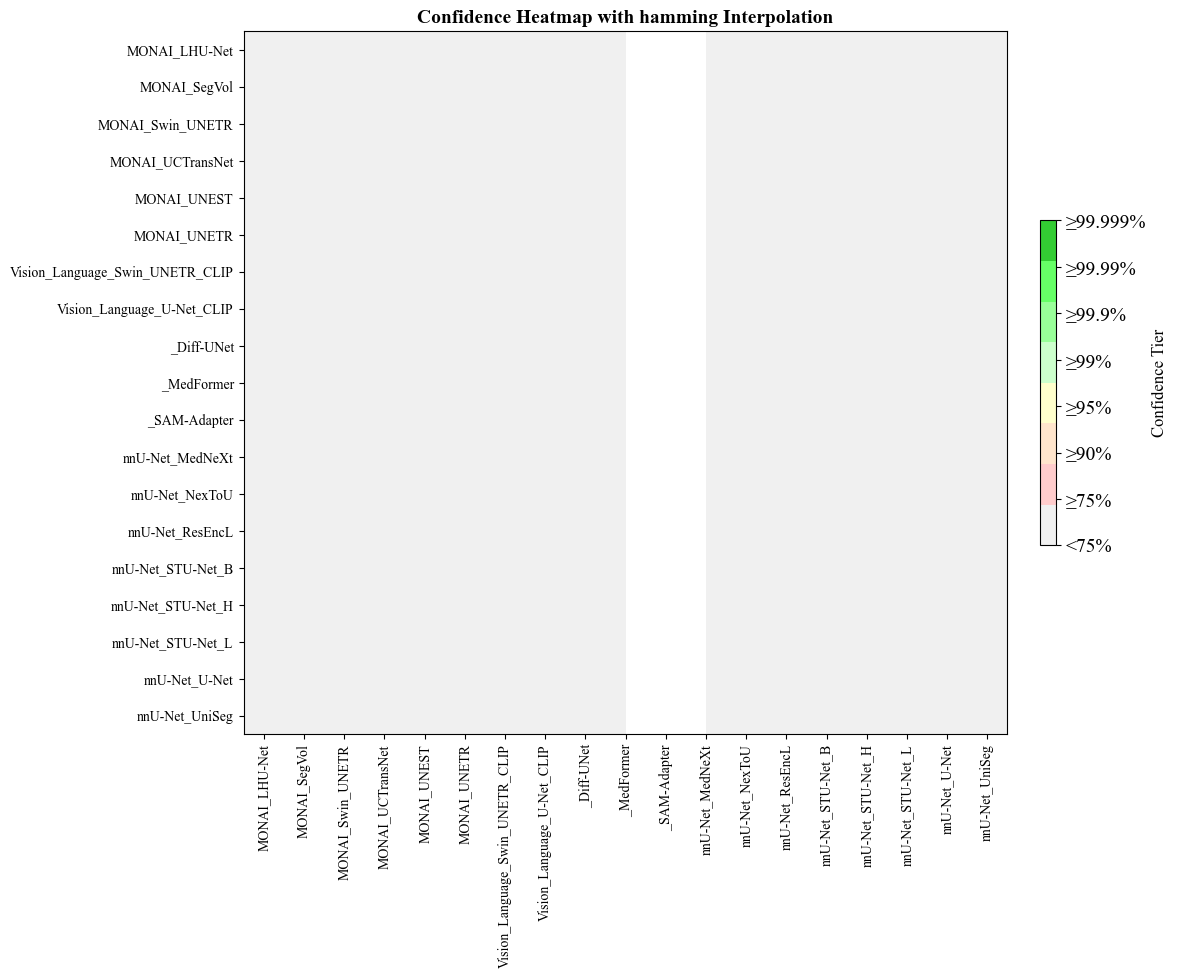

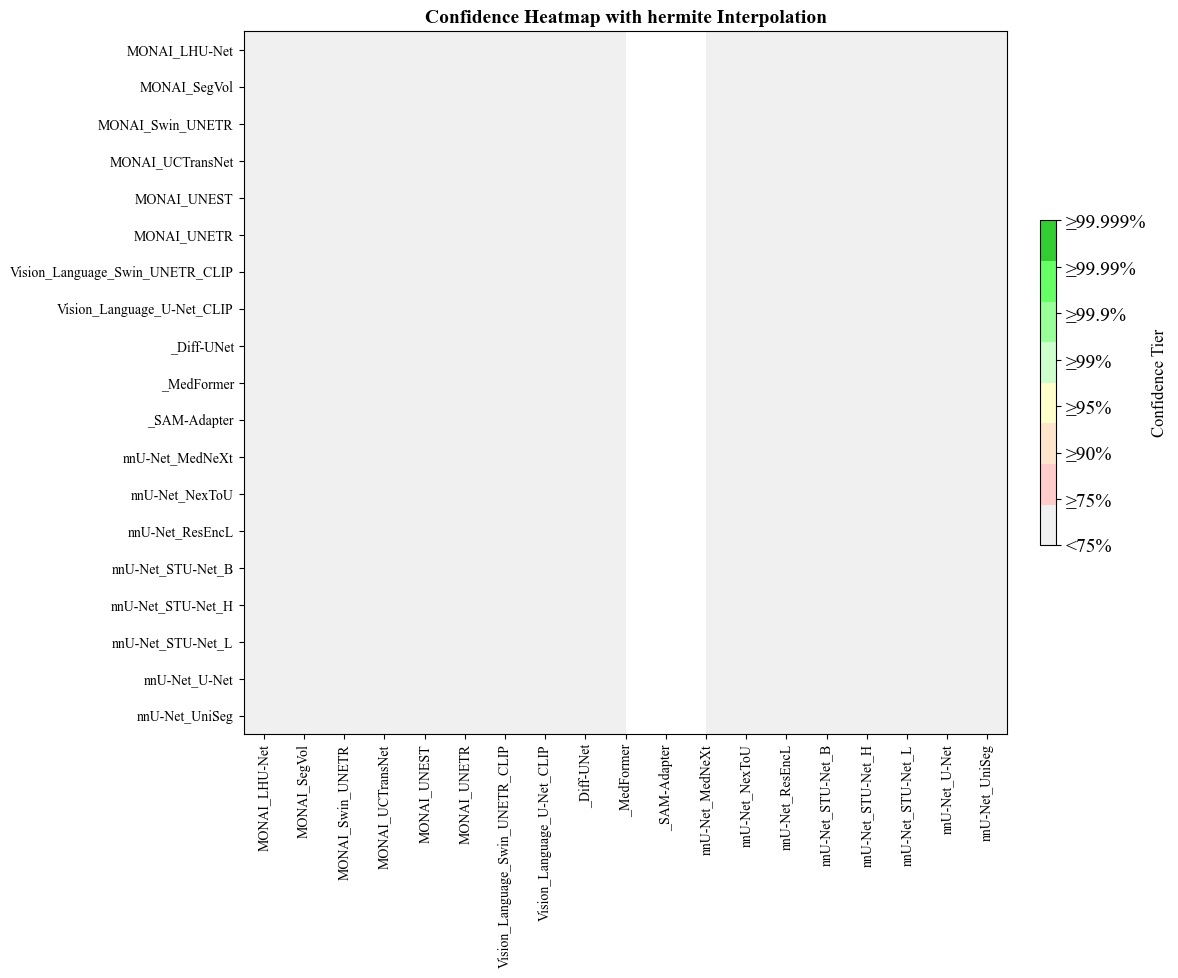

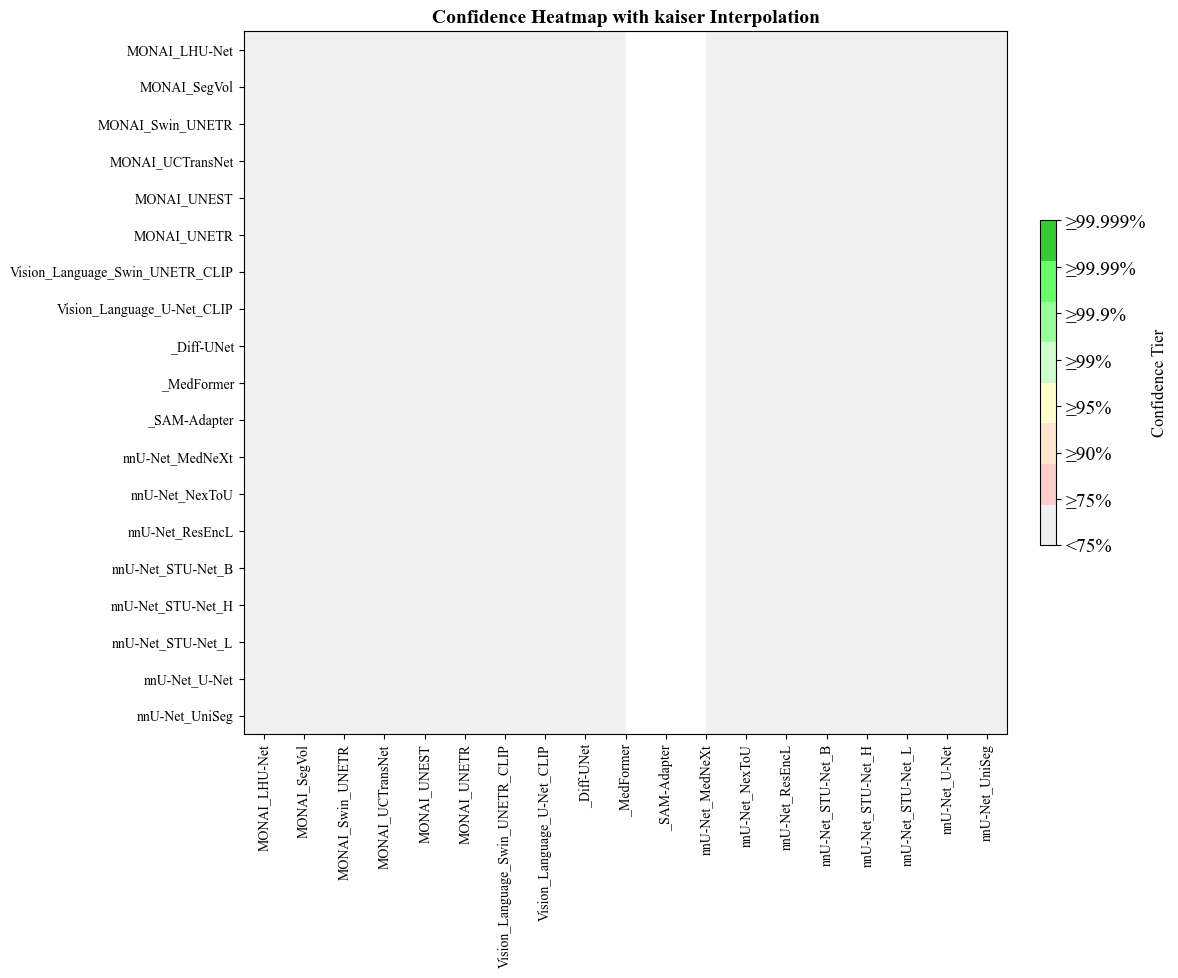

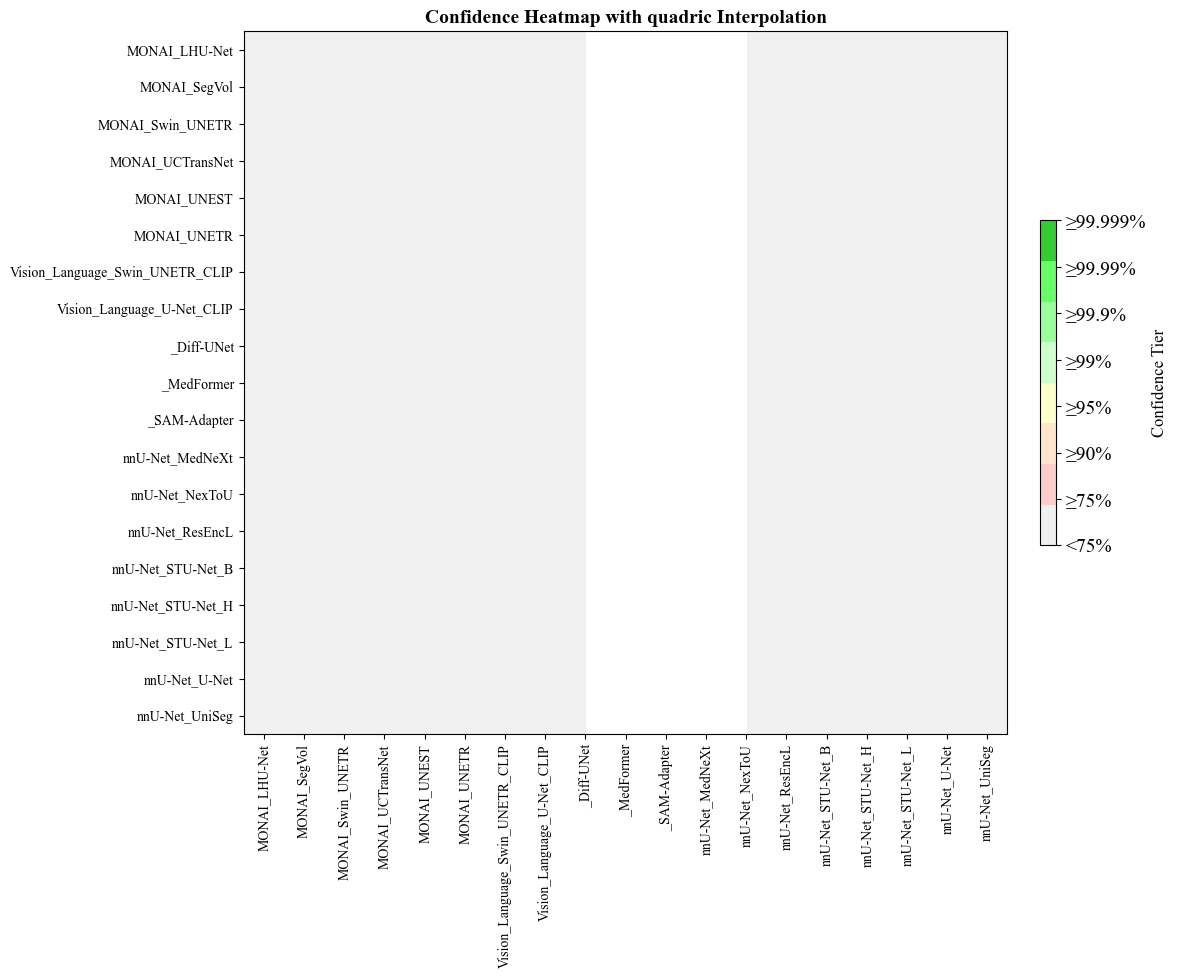

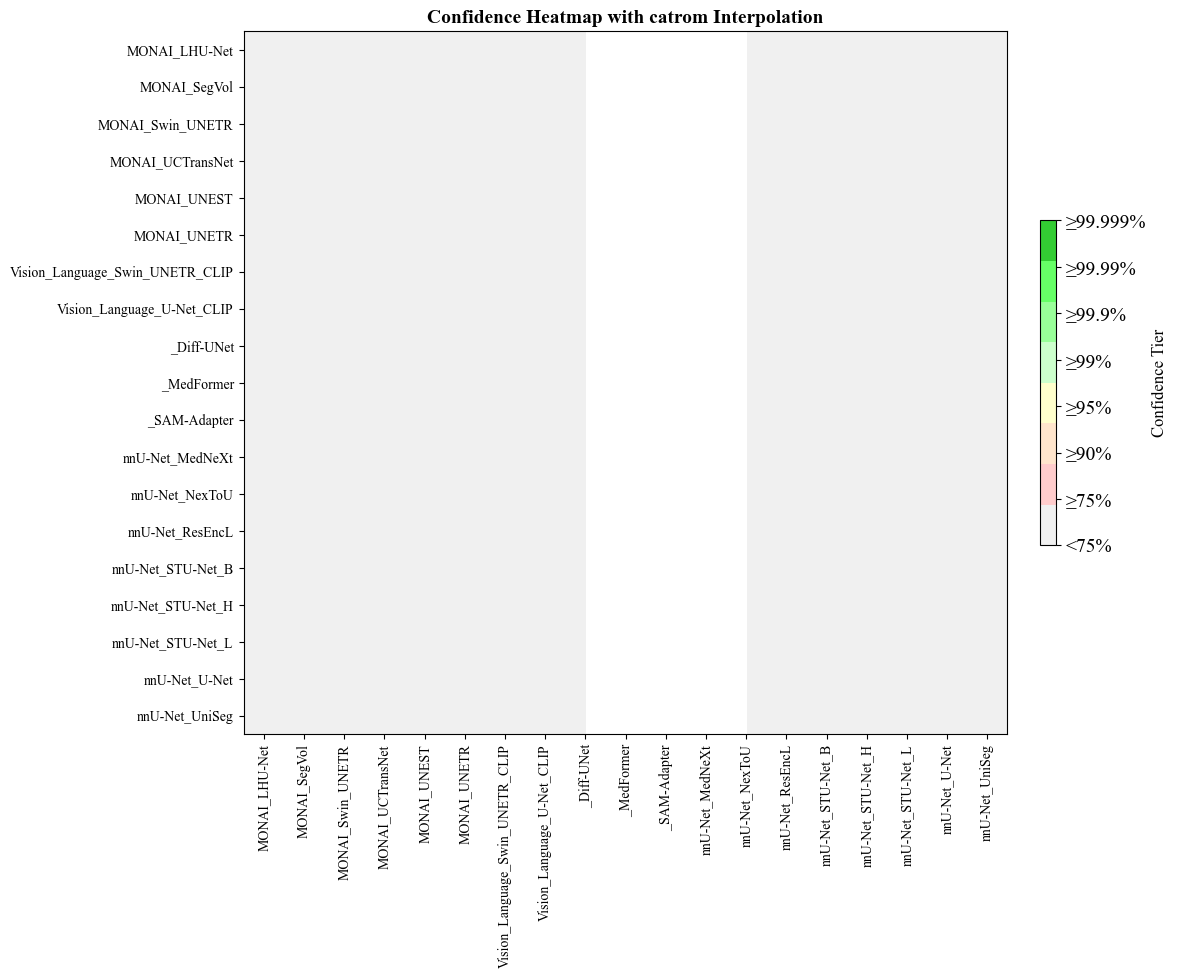

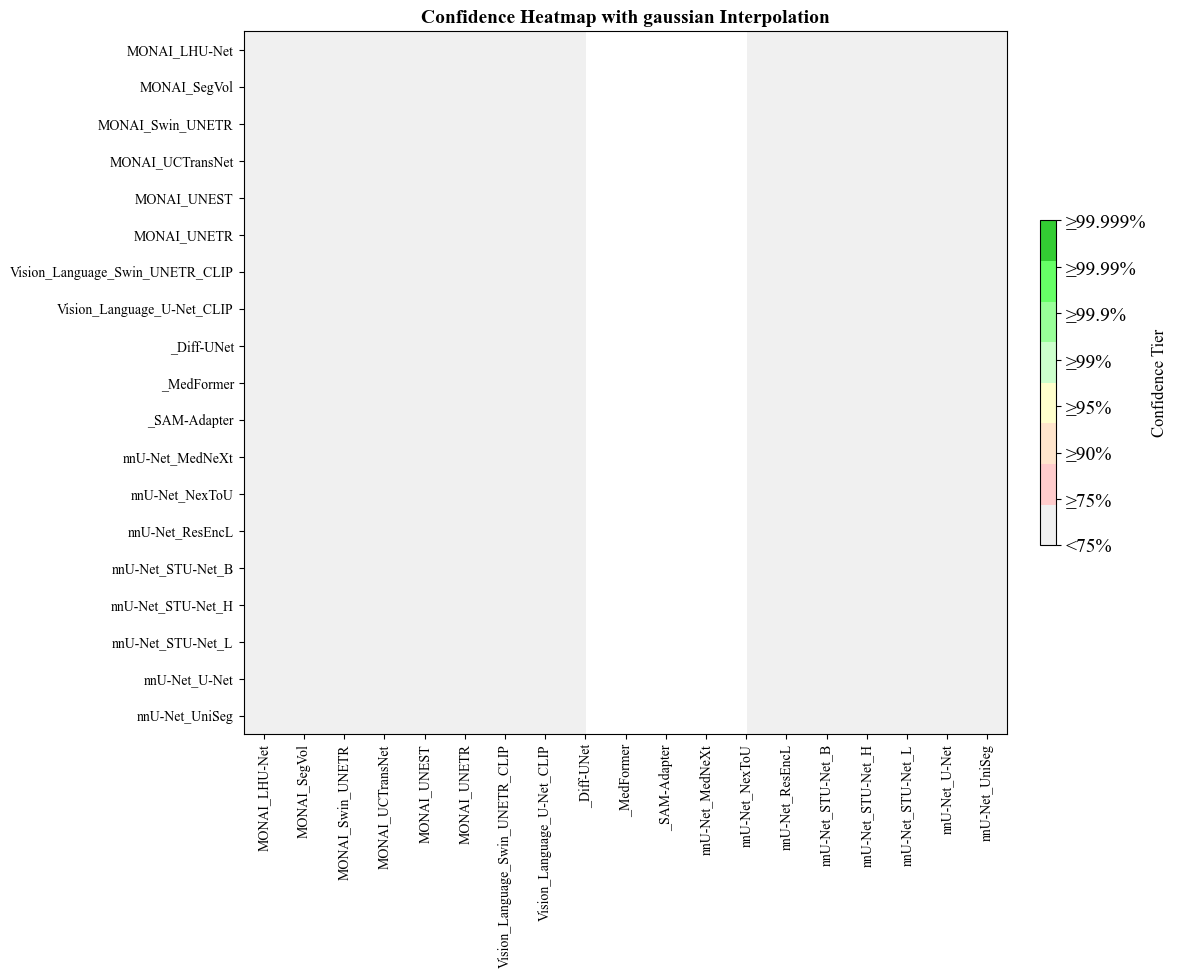

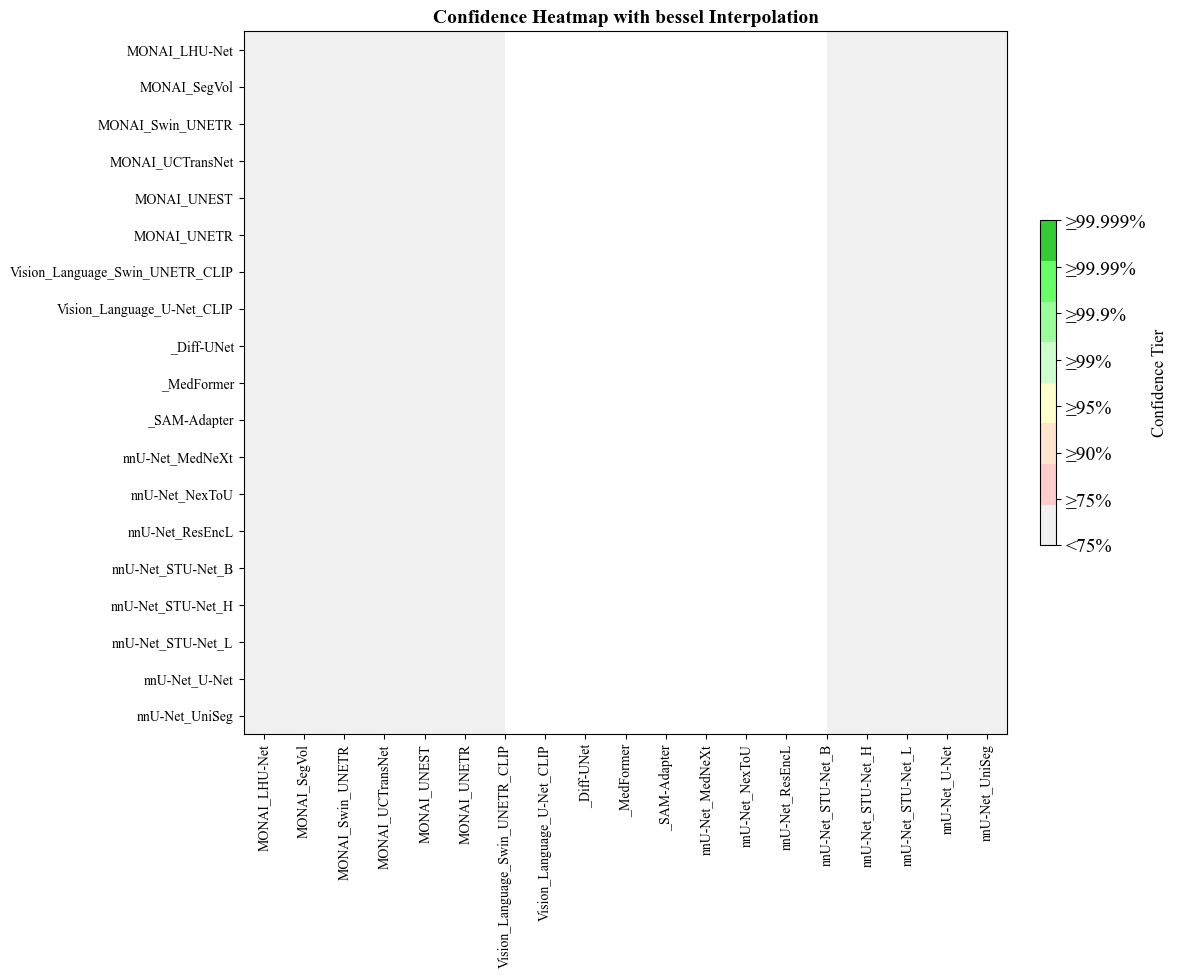

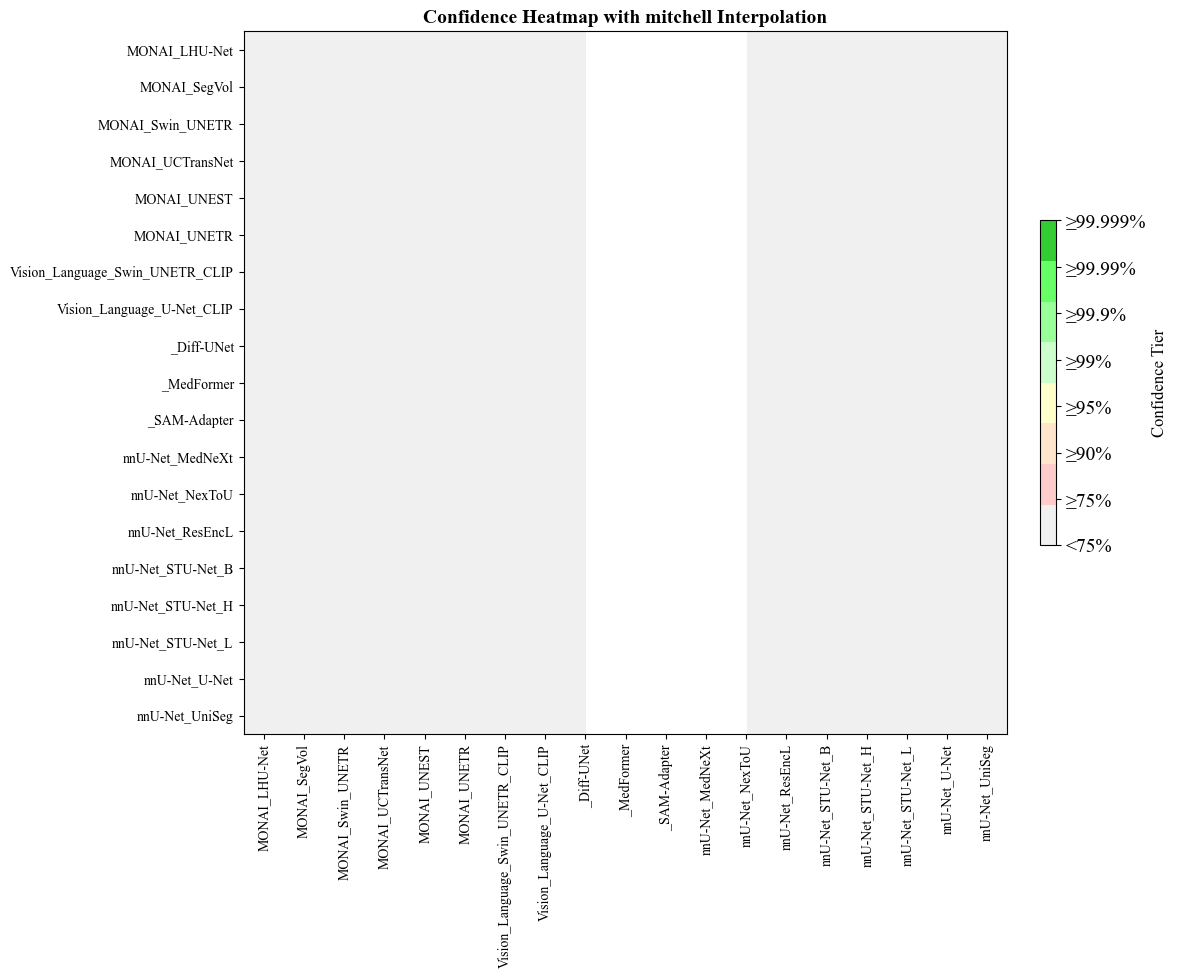

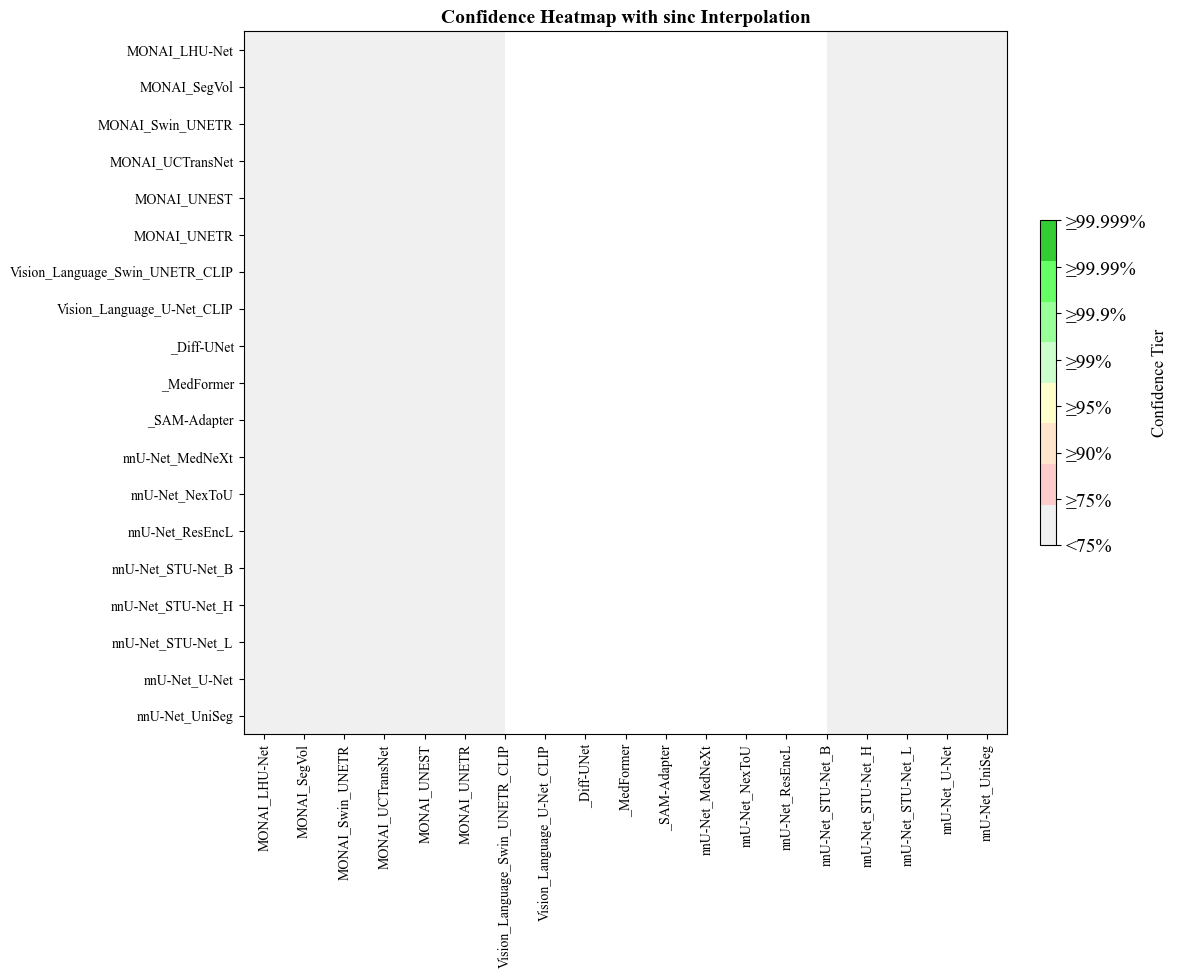

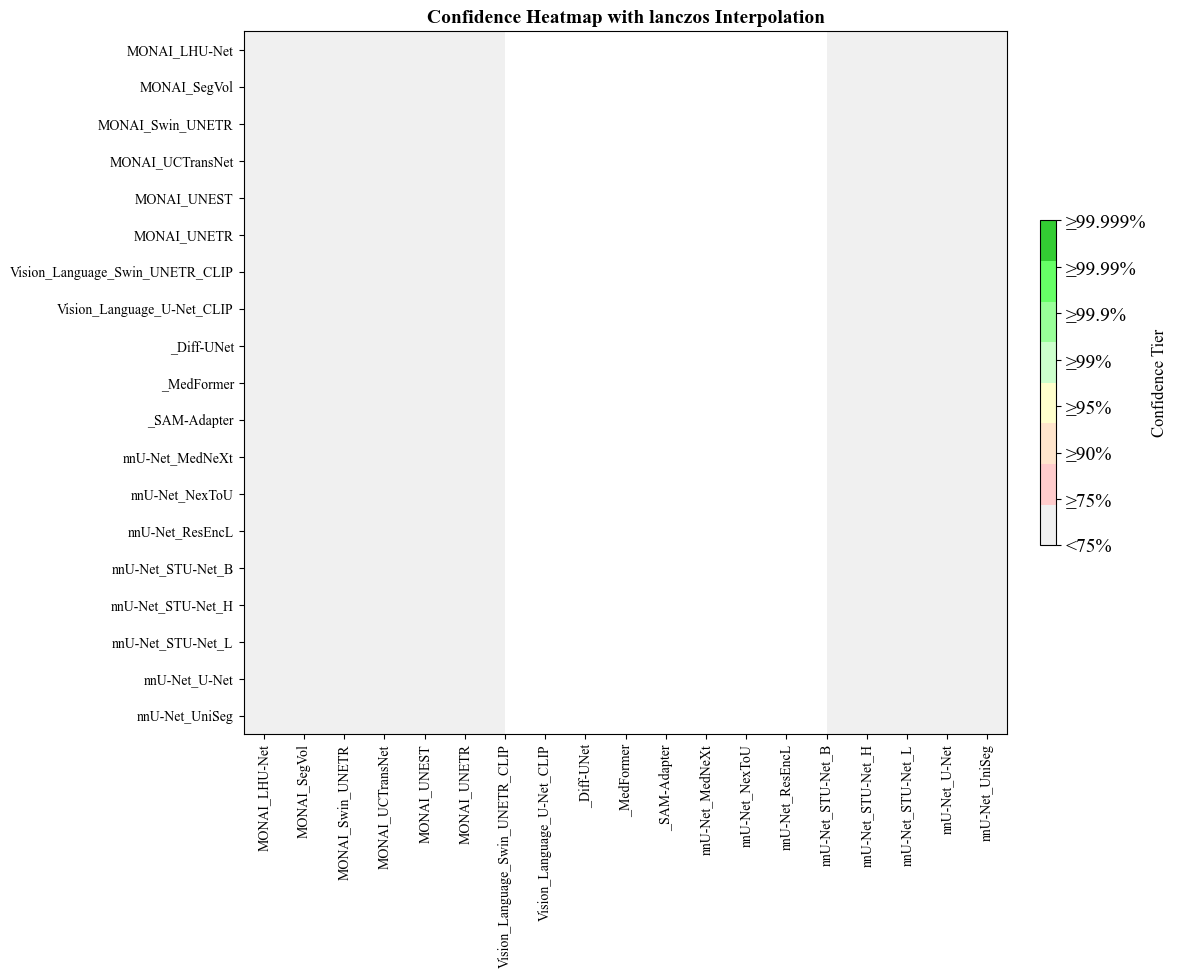

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def confidence_heatmap_interpolation_comparison(csv_path='df_heat.csv'):
    # Read CSV and replace "NA" strings with np.nan
    df = pd.read_csv(csv_path)
    # df.replace("nan", 0, inplace=True)

    # Define the ordered discrete tiers
    tier_levels = ['<75%', '≥75%', '≥90%', '≥95%', '≥99%', '≥99.9%', '≥99.99%', '≥99.999%']
    # Map each tier to an integer value (1, 2, …, 8)
    tier_to_numeric = {tier: i+1 for i, tier in enumerate(tier_levels)}

    # Pivot the data: rows=algoRow, columns=algoCol, values=confidenceTier (as text)
    heatmap_data = df.pivot(index='algoRow', columns='algoCol', values='confidenceTier')
    # Convert tiers to numeric values using our mapping
    heatmap_data_numeric = heatmap_data.applymap(lambda x: tier_to_numeric.get(x, np.nan))

    # Fill NaNs with the column mean to smooth out the transitions
    heatmap_filled = heatmap_data_numeric.copy().astype(float)
    heatmap_filled = heatmap_filled.apply(lambda col: col.fillna(col.mean()), axis=0)

    # Define a custom palette:
    custom_colors = [
        '#f0f0f0',  # <75% : neutral light grey
        '#ffcccc',  # ≥75% : pastel red
        '#ffe5cc',  # ≥90% : pastel orange
        '#ffffcc',  # ≥95% : pastel yellow
        '#ccffcc',  # ≥99% : light green
        '#99ff99',  # ≥99.9%: moderate green
        '#66ff66',  # ≥99.99%: more saturated green
        '#33cc33'   # ≥99.999%: dark green
    ]
    custom_cmap = ListedColormap(custom_colors)

    # List of available interpolation methods in imshow
    interpolation_methods = [
        'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning',
        'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
        'sinc', 'lanczos'
    ]

    for interp in interpolation_methods:
        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(heatmap_filled, cmap=custom_cmap, aspect="auto",
                       interpolation=interp, vmin=1, vmax=len(tier_levels))

        # Set axis ticks and labels
        ax.set_xticks(np.arange(heatmap_filled.shape[1]))
        ax.set_yticks(np.arange(heatmap_filled.shape[0]))
        ax.set_xticklabels(heatmap_filled.columns, rotation=90, fontsize=10)
        ax.set_yticklabels(heatmap_filled.index, fontsize=10)
        ax.set_title(f"Confidence Heatmap with {interp} Interpolation", fontsize=14, fontweight="bold")

        # Add a colorbar with discrete ticks corresponding to the tiers
        cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_ticks(np.arange(1, len(tier_levels) + 1))
        cbar.set_ticklabels(tier_levels)
        cbar.set_label("Confidence Tier", fontsize=12)

        plt.tight_layout()
        plt.show()

# Call the function to generate the plots
confidence_heatmap_interpolation_comparison()


#  2- DSC vs. NSD, as appropriate, by organ

### Reimplementation of R code in Py

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform

# Path to parent folder containing one subfolder per algorithm
parent_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# List subdirectories (one per algorithm)
model_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Our 9 organs of interest
all_organs = ["aorta", "gall_bladder", "kidney_left", "kidney_right",
              "liver", "pancreas", "postcava", "spleen", "stomach"]

# Decide which metric to use for each organ: DSC vs NSD
organs_use_nsd = {"aorta", "postcava"}
organs_use_dsc = set(all_organs) - organs_use_nsd

# Directory to save plots (optional)
out_plots_dir = "figures/2_dsc_nsd_by_organ/prettier"
os.makedirs(out_plots_dir, exist_ok=True)


def read_metric_data(metric, organs):
    """
    Read the CSV data from each algorithm folder and pivot to long format.

    Parameters:
        metric (str): "dsc" or "nsd"
        organs (list): List of organs to extract

    Returns:
        pd.DataFrame: Combined long-format data from all algorithm results
    """
    all_data = []

    for mdir in model_dirs:
        csv_file = os.path.join(mdir, f"{metric}.csv")
        if not os.path.exists(csv_file):
            print(f"Skipping: no {metric}.csv in {mdir}")
            continue

        df = pd.read_csv(csv_file)

        if 'name' not in df.columns:
            print(f"Skipping: {csv_file} missing 'name' column")
            continue

        df_long = df.melt(id_vars=['name'], value_vars=organs, var_name='organ', value_name='value')
        df_long.rename(columns={'name': 'case'}, inplace=True)
        df_long['algo'] = os.path.basename(mdir)

        # Remove rows with NaN values
        df_long = df_long.dropna()

        all_data.append(df_long)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame(columns=['case', 'organ', 'value', 'algo'])


def compute_ranking(df):
    """
    Compute ranking of algorithms using statistical significance.

    Parameters:
        df (pd.DataFrame): Dataframe containing algorithm performance

    Returns:
        pd.DataFrame: Dataframe with ranking per algorithm
    """
    algo_means = df.groupby('algo')['value'].mean()
    rankings = rankdata(-algo_means, method='min')  # Higher value = better rank
    rank_df = pd.DataFrame({'algo': algo_means.index, 'mean_score': algo_means.values, 'rank': rankings})
    return rank_df.sort_values(by='rank')


def bootstrap_ranking(df, nboot=200):
    """
    Perform bootstrapping to compute rank distributions.

    Parameters:
        df (pd.DataFrame): Algorithm performance data
        nboot (int): Number of bootstrap samples

    Returns:
        pd.DataFrame: Bootstrapped rank distributions
    """
    boot_ranks = []
    algos = df['algo'].unique()

    for _ in range(nboot):
        sample = df.sample(frac=1, replace=True)
        rank_sample = compute_ranking(sample)
        boot_ranks.append(rank_sample[['algo', 'rank']])

    boot_df = pd.concat(boot_ranks)
    return boot_df


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import rankdata

# Path to save improved plots
out_plots_dir = "figures/2_dsc_nsd_by_organ"
os.makedirs(out_plots_dir, exist_ok=True)

# Iterate over all organs and generate improved box plots
for org in all_organs:
    metric_choice = "nsd" if org in organs_use_nsd else "dsc"
    df_metric = read_metric_data(metric_choice, [org])

    if df_metric.empty:
        print(f"No data found for organ {org} with metric={metric_choice} -- skipping.")
        continue

    # Sort algorithms by median performance (best-performing first)
    algo_order = df_metric.groupby("algo")["value"].median().sort_values(ascending=False).index

    # Dynamically generate a large enough color palette
    num_algos = len(algo_order)
    palette = sns.color_palette("coolwarm", n_colors=num_algos)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Box plot (assign hue="algo" to avoid the FutureWarning)
    sns.boxplot(
        data=df_metric,
        x="value",
        y="algo",
        order=algo_order,
        hue="algo",
        palette=palette,
        showfliers=False,
        linewidth=1.5,
        legend=False  # Hide redundant legend
    )

    # Strip plot (reduce dot size & adjust jitter for clarity)
    sns.stripplot(
        data=df_metric,
        x="value",
        y="algo",
        order=algo_order,
        color='black',
        size=3,  # Smaller dots
        jitter=0.15,  # Adjust jitter to prevent excessive clustering
        alpha=0.6  # Reduce opacity for clarity
    )

    # Improve readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Performance Score (Higher is Better)", fontsize=14)
    plt.ylabel("Algorithm", fontsize=14)
    plt.title(f"Algorithm Performance for {org} ({metric_choice.upper()})", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the improved plot
    plt.savefig(os.path.join(out_plots_dir, f"box_{org}_{metric_choice}.png"), dpi=300, bbox_inches='tight')
    plt.close()

print("Updated, aesthetically improved box plots saved.")

Updated, aesthetically improved box plots saved.


## Metric-Based Rankings Heatmap

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_49524/2755486172.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


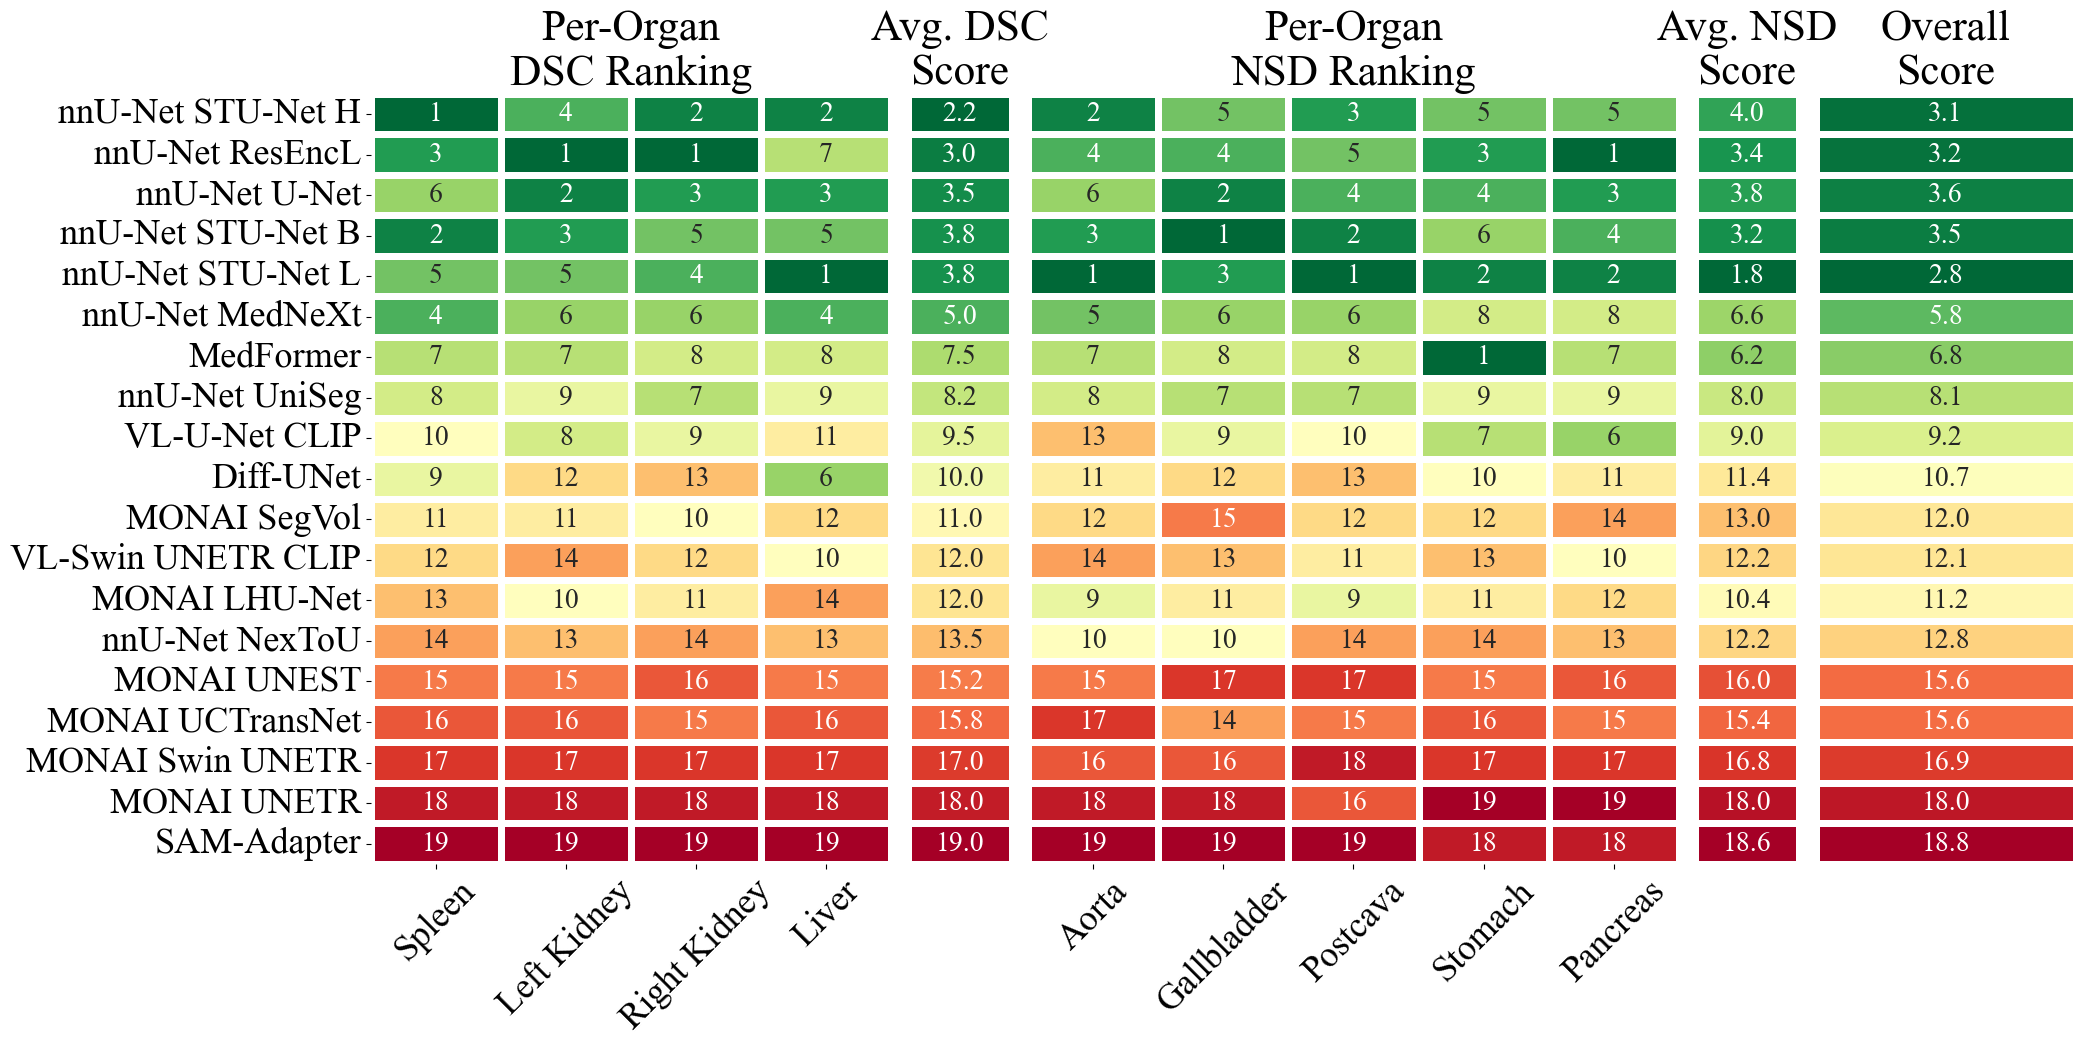

In [3]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig2_save_dir = "figures/2_dsc_nsd_by_organ/"

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"]  = ["Times New Roman"]   # or ["DejaVu Serif", "Times"]
plt.rcParams["font.size"]   = 26

# ─────────────────────────────────────────────────────────────────────
# 1. helpers for nicer labels
def pretty(name: str) -> str:
    """Vision_Language_Swin_UNETR_CLIP → VL-Swin UNETR CLIP,  Diff-UNet → Diff-UNet."""
    name = model_name_mapping.get(name, name)        # explicit replacements
    name = name.replace('_', ' ')
    return re.sub(r'\s{2,}', ' ', name).strip()

model_name_mapping = {
    # leading “_” variants seen in some file dumps
    "_Diff-UNet":                "Diff-UNet",
    "_MedFormer":                "MedFormer",
    "_SAM-Adapter":              "SAM-Adapter",
    # Vision-Language → VL
    "Vision_Language_Swin_UNETR_CLIP": "VL-Swin UNETR CLIP",
    "Vision_Language_U-Net_CLIP":      "VL-U-Net CLIP",
}

# ─────────────────────────────────────────────────────────────────────
# 2. ingest all metrics
base_dir = "./data/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

all_organs    = ["aorta","gall_bladder","kidney_left","kidney_right",
                 "liver","pancreas","postcava","spleen","stomach"]
organs_use_nsd = {"aorta","postcava","stomach","pancreas","gall_bladder"}
organs_use_dsc = set(all_organs) - organs_use_nsd

all_rows = []
for model in os.listdir(base_dir):
    mp = os.path.join(base_dir, model)
    if not os.path.isdir(mp):
        continue

    for metric, fname in [("DSC", "dsc.csv"), ("NSD", "nsd.csv")]:
        f = os.path.join(mp, fname)
        if not os.path.exists(f):
            continue
        df = (pd.read_csv(f)
                .melt(id_vars=['name'], var_name='organ', value_name='value')
                .assign(model=model, metric=metric)
                .dropna())
        all_rows.append(df)

df_all = pd.concat(all_rows, ignore_index=True)

# ─────────────────────────────────────────────────────────────────────
# 3. per-organ ranks
per_organ = df_all.groupby(['model','organ'])['value'].mean().unstack()
rankings  = per_organ.rank(ascending=False)

dsc_rank = rankings.loc[:, list(organs_use_dsc)]
nsd_rank = rankings.loc[:, list(organs_use_nsd)]

# ─── Prettify organ-column names ────────────────────────────────────
organ_pretty = {
    "aorta":         "Aorta",
    "gall_bladder":  "Gallbladder",      # 1 word
    "kidney_left":   "Left Kidney",
    "kidney_right":  "Right Kidney",
    "liver":         "Liver",
    "pancreas":      "Pancreas",
    "postcava":      "Postcava",
    "spleen":        "Spleen",
    "stomach":       "Stomach",
}

dsc_rank.columns = [organ_pretty[c] for c in dsc_rank.columns]
nsd_rank.columns = [organ_pretty[c] for c in nsd_rank.columns]

# keep raw model order for sorting, then prettify
model_order_raw = dsc_rank.median(axis=1).sort_values().index
dsc_rank, nsd_rank = dsc_rank.loc[model_order_raw], nsd_rank.loc[model_order_raw]

# prettified index for *all* downstream frames
pretty_index = pd.Index([pretty(m) for m in model_order_raw], name='model')
dsc_rank.index  = pretty_index
nsd_rank.index  = pretty_index

# ─────────────────────────────────────────────────────────────────────
# 4. aggregated columns
dsc_avg   = dsc_rank.mean(axis=1).to_frame("Avg DSC Rank")
nsd_avg   = nsd_rank.mean(axis=1).to_frame("Avg NSD Rank")
final_avg = ((dsc_avg["Avg DSC Rank"] + nsd_avg["Avg NSD Rank"]) / 2)\
              .to_frame("Final Avg Rank")

# ─────────────────────────────────────────────────────────────────────
# 5. plot (narrower multi-organ columns)
cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

fig, axes = plt.subplots(
    1, 5, figsize=(22, 10),
    gridspec_kw={'width_ratios': [1, .2, 1.25, .2, .5], 'wspace': 0.05}
)

sns.heatmap(dsc_rank, annot=True, cmap=cmap, linewidths=5,
            cbar=False, ax=axes[0], annot_kws={"size": 20})
axes[0].set(title="Per-Organ\nDSC Ranking", xlabel=None, ylabel=None)
axes[0].tick_params(axis='x', rotation=45)

sns.heatmap(dsc_avg, annot=True, cmap=cmap, linewidths=5,
            cbar=False, ax=axes[1], annot_kws={"size": 20}, fmt=".1f")
axes[1].set(title="Avg. DSC\nScore", ylabel="")
axes[1].set_xticks([]) 

sns.heatmap(nsd_rank, annot=True, cmap=cmap, linewidths=5,
            cbar=False, ax=axes[2], annot_kws={"size": 20})
axes[2].set(title="Per-Organ\nNSD Ranking", xlabel=None, ylabel="")
axes[2].tick_params(axis='x', rotation=45)

sns.heatmap(nsd_avg, annot=True, cmap=cmap, linewidths=5,
            cbar=False, ax=axes[3], annot_kws={"size": 20}, fmt=".1f")
axes[3].set(title="Avg. NSD\nScore", ylabel="")
axes[3].set_xticks([])

# FINAL aggregated (new column) — same as before
hm = sns.heatmap(final_avg, annot=True, cmap=cmap, linewidths=5,
                 cbar=False, ax=axes[4], annot_kws={"size": 20}, fmt=".1f")
axes[4].set(title="Overall\nScore", ylabel="")
axes[4].set_xticks([])

# flip colour-bar so rank 1 (best) sits at the *top* in green
# hm.collections[0].colorbar.ax.invert_yaxis()

for ax in axes[1:]:
    ax.tick_params(axis='y', left=False, labelleft=False)

plt.tight_layout()
fig.savefig(os.path.join(fig2_save_dir,"fig2_organ_ranking_heatmap_no_colorbar.pdf"), format="pdf", bbox_inches="tight")
plt.show()

# 3- Demographics - JHH

In [ ]:
main_folder_path = "/Users/ariellubonja/prog/alans_lab/miccai_2025/Touchstone/totalsegmentator_results/final_14dec2024_results/jhh_results - table 2 in paper"

## Univariate

DPD implemented as a difference of proportions

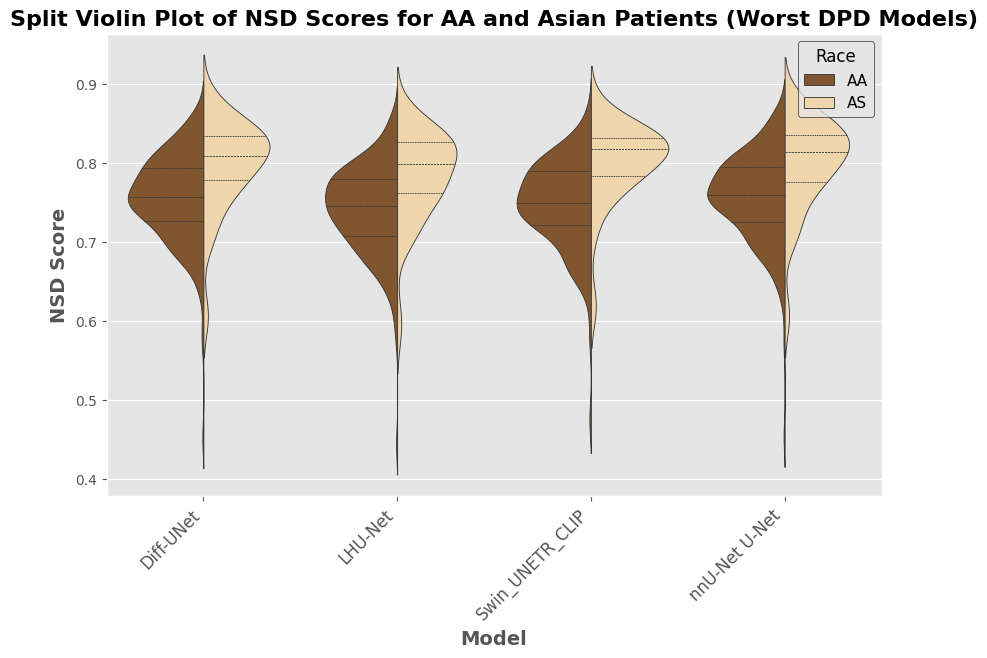

In [17]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# Load NSD.csv files
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]
nsd_data = {}

for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine NSD data
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD per patient across all organs
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Merge NSD with metadata
df_metadata_subset = df_metadata[['name', 'race']]
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter only AA and Asian patients
df_nsd_aa_asian = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

"""
# OPTION 1: Select models based on largest tail difference
def compute_tail_length(df):
    stats = df.groupby('Model')['mean_nsd'].describe()
    stats['Tail Length'] = (stats['max'] - stats['75%']) + (stats['25%'] - stats['min'])
    return stats

tail_stats = compute_tail_length(df_nsd_aa_asian)
selected_models = tail_stats.sort_values(by='Tail Length', ascending=False).head(4).index.tolist()
"""

"""
# OPTION 2: Manually select models
selected_models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']  # Replace with actual model names
"""

# OPTION 3 (ACTIVE CODE): Select 4 models with the worst DPD (AS vs AA)
df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# Compute the probability of achieving a high NSD score (above the median)
median_nsd = df_nsd_dpd['mean_nsd'].median()

# Compute probability per model
dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# Compute DPD (AS - AA)
dpd_values = dpd_as - dpd_aa

# Select the 4 models with the worst DPD (highest disparity)
selected_models = dpd_values.sort_values(ascending=False).head(4).index.tolist()

# Filter dataset for selected models
df_nsd_aa_asian_filtered = df_nsd_aa_asian[df_nsd_aa_asian['Model'].isin(selected_models)]

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='mean_nsd', hue='race', data=df_nsd_aa_asian_filtered, split=True, inner='quartile',
               palette={"AA": "#8D5524", "AS": "#FAD7A0"})  # Skin-tone-inspired colors

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('NSD Score', fontsize=14, fontweight='bold')
plt.title('Split Violin Plot of NSD Scores for AA and Asian Patients (Worst DPD Models)', fontsize=16, fontweight='bold')

# Adjust legend
plt.legend(title="Race", title_fontsize=12, fontsize=11, loc='upper right', frameon=True, edgecolor='black')

# Show the plot
plt.show()


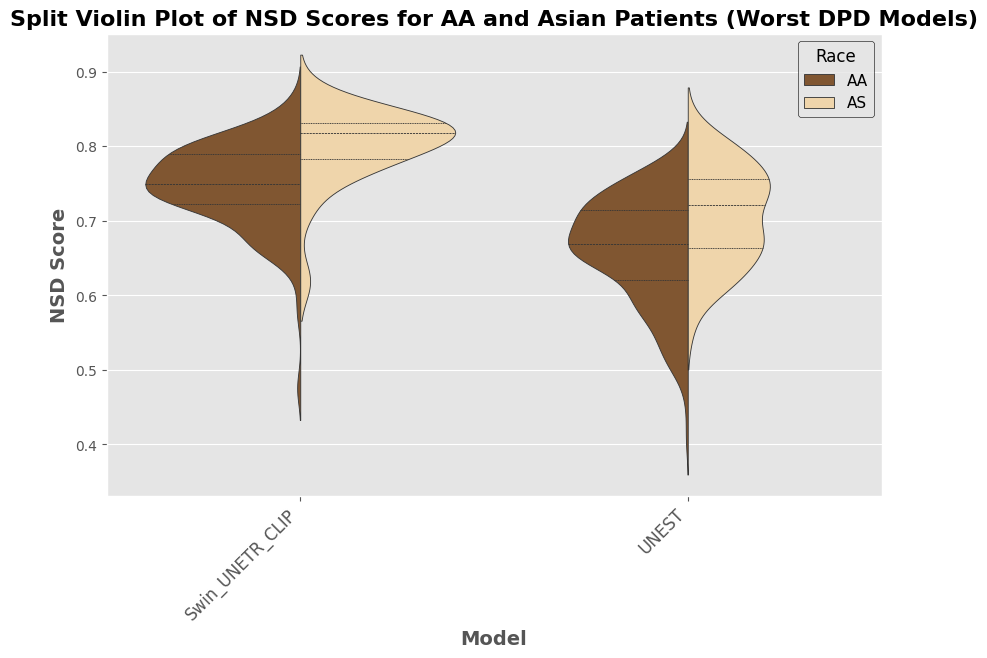

In [29]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# Load NSD.csv files
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]
nsd_data = {}

for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine NSD data
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD per patient across all organs
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Merge NSD with metadata
df_metadata_subset = df_metadata[['name', 'race']]
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter only AA and Asian patients
df_nsd_aa_asian = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

"""
# OPTION 1: Select models based on largest tail difference
def compute_tail_length(df):
    stats = df.groupby('Model')['mean_nsd'].describe()
    stats['Tail Length'] = (stats['max'] - stats['75%']) + (stats['25%'] - stats['min'])
    return stats

tail_stats = compute_tail_length(df_nsd_aa_asian)
selected_models = tail_stats.sort_values(by='Tail Length', ascending=False).head(4).index.tolist()
"""

"""
# OPTION 2: Manually select models
selected_models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']  # Replace with actual model names
"""
selected_models = ['Swin_UNETR_CLIP', 'UNEST', 'NexToU' 'UCTransNet']
# OPTION 3 (ACTIVE CODE): Select 4 models with the worst DPD (AS vs AA)
# df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# # Compute the probability of achieving a high NSD score (above the median)
# median_nsd = df_nsd_dpd['mean_nsd'].median()

# # Compute probability per model
# dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
# dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# # Compute DPD (AS - AA)
# dpd_values = dpd_as - dpd_aa

# # Select the 4 models with the worst DPD (highest disparity)
# selected_models = dpd_values.sort_values(ascending=False).head(4).index.tolist()

# Filter dataset for selected models
df_nsd_aa_asian_filtered = df_nsd_aa_asian[df_nsd_aa_asian['Model'].isin(selected_models)]

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='mean_nsd', hue='race', data=df_nsd_aa_asian_filtered, split=True, inner='quartile',
               palette={"AA": "#8D5524", "AS": "#FAD7A0"})  # Skin-tone-inspired colors

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('NSD Score', fontsize=14, fontweight='bold')
plt.title('Split Violin Plot of NSD Scores for AA and Asian Patients (Worst DPD Models)', fontsize=16, fontweight='bold')

# Adjust legend
plt.legend(title="Race", title_fontsize=12, fontsize=11, loc='upper right', frameon=True, edgecolor='black')

# Show the plot
plt.show()


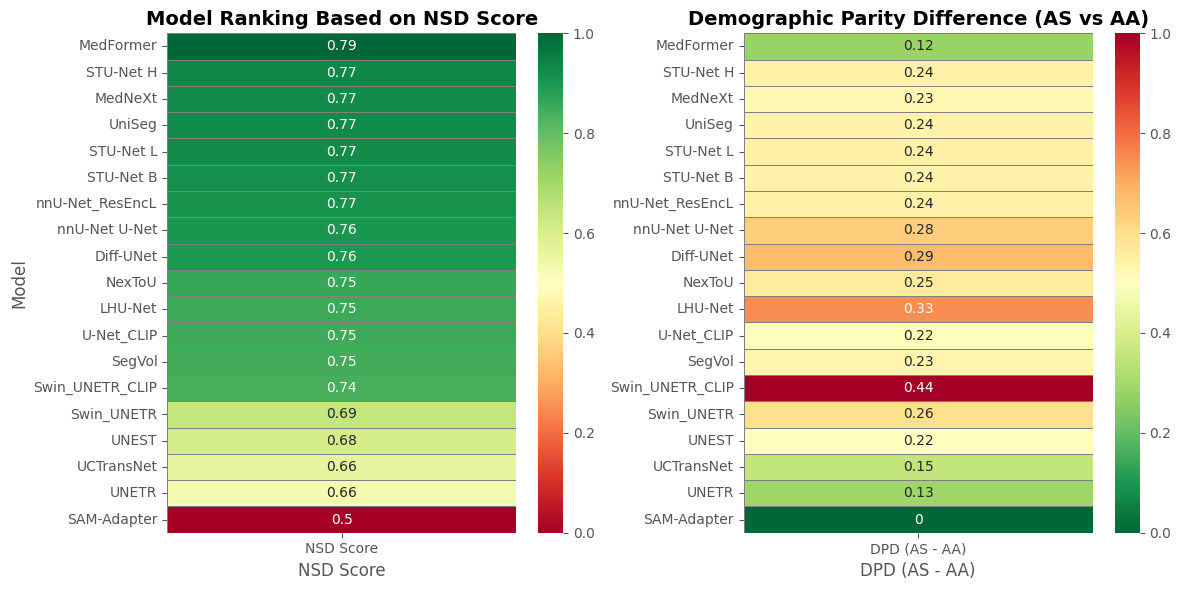

In [15]:
# Compute NSD ranking per model
model_nsd_means = df_nsd_full.groupby('Model')['mean_nsd'].mean().sort_values(ascending=False)
model_nsd_ranks = model_nsd_means.rank(ascending=False, method='dense')

# Filter only AA and Asian patients for DPD computation
df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# Compute the probability of achieving a high NSD score (above the median)
median_nsd = df_nsd_dpd['mean_nsd'].median()

# Compute probability per model
dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# Compute DPD (AS - AA)
dpd_values = dpd_as - dpd_aa

# Combine rankings into DataFrame
ranking_data = pd.DataFrame({
    'NSD Score': model_nsd_means,
    'NSD Rank': model_nsd_ranks,
    'DPD (AS - AA)': dpd_values
}).sort_values(by='NSD Rank')

# Normalize values for heatmap consistency
ranking_data_normalized = (ranking_data - ranking_data.min()) / (ranking_data.max() - ranking_data.min())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for NSD Score ranking
sns.heatmap(ranking_data_normalized[['NSD Score']], annot=ranking_data[['NSD Score']].round(3), cmap='RdYlGn',
            linewidths=0.5, linecolor='gray', cbar=True, ax=axes[0])
axes[0].set_title('Model Ranking Based on NSD Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('NSD Score')
axes[0].set_ylabel('Model')

# Heatmap for DPD (AS vs. AA)
sns.heatmap(ranking_data_normalized[['DPD (AS - AA)']], annot=ranking_data[['DPD (AS - AA)']].round(3),
            cmap='RdYlGn_r', linewidths=0.5, linecolor='gray', cbar=True, ax=axes[1])
axes[1].set_title('Demographic Parity Difference (AS vs AA)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('DPD (AS - AA)')
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


## Verification

o3-mini-high

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- CONFIGURATION -----
# List of folders (models) to process. You can also auto-detect directories that contain a dsc.csv.
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]


metadata = df_metadata[df_metadata['race'].isin(['AS', 'AA'])]

print(metadata)

# Dictionary to store DPD for each model
dpd_dict = {}

# ----- PROCESS EACH MODEL -----
for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        nsd_df = pd.read_csv(nsd_file_path)

    dsc_df = nsd_df # Fake it

    # Merge DSC results with metadata on the 'name' column
    merged = pd.merge(dsc_df, metadata, on='name', how='inner')

    if merged.empty:
        print(f"No overlapping subjects for model {model}. Skipping.")
        continue

    # Identify DSC columns (all columns from dsc file except 'name')
    dsc_columns = list(dsc_df.columns)
    dsc_columns.remove('name')

    # Compute average DSC per subject over available organs (ignoring NaNs)
    merged['avg_dsc'] = merged[dsc_columns].mean(axis=1, skipna=True)

    # Compute mean DSC per race group
    mean_AS = merged.loc[merged['race'] == 'AS', 'avg_dsc'].mean()
    mean_AA = merged.loc[merged['race'] == 'AA', 'avg_dsc'].mean()

    # Check if both race groups exist; if not, skip this model.
    if pd.isna(mean_AS) or pd.isna(mean_AA):
        print(f"Model {model} does not have both AS and AA patients. Skipping.")
        continue

    # Compute demographic parity difference.
    # Here, we take the absolute difference so that models closer to parity (0) are better.
    dpd = abs(mean_AS - mean_AA)
    dpd_dict[model] = dpd

# Convert the dictionary into a DataFrame
dpd_df = pd.DataFrame.from_dict(dpd_dict, orient='index', columns=['DPD'])

# ----- PLOT THE HEATMAP -----
# We want a colormap where a DPD of 0 is green (best) and higher differences are red (worst).
plt.figure(figsize=(8, max(4, len(dpd_df) * 0.5)))
sns.heatmap(dpd_df, annot=True, fmt=".3f", cmap="RdYlGn_r", cbar_kws={'label': 'DPD'},
            linewidths=0.5, linecolor='gray')
plt.title('Demographic Parity Difference (|AS DSC - AA DSC|) Across Models')
plt.ylabel('Model')
plt.xlabel('DPD')
plt.tight_layout()
plt.show()


                name ages sex race  diagnosis
18    BDMAP_V0000982   53   F   AS  no_cancer
19    BDMAP_A0000982   53   F   AS  no_cancer
150   BDMAP_V0001051   49   F   AA  no_cancer
151   BDMAP_A0001051   49   F   AA  no_cancer
168   BDMAP_A0001061   36   F   AA  no_cancer
...              ...  ...  ..  ...        ...
2910  BDMAP_A0001371   47   F   AA  no_cancer
2919  BDMAP_V0001387   51   F   AA  no_cancer
2920  BDMAP_A0001387   51   F   AA  no_cancer
2921  BDMAP_V0001390   60   M   AS  no_cancer
2922  BDMAP_A0001390   60   M   AS  no_cancer

[263 rows x 5 columns]


In [21]:
dpd_df

Empty DataFrame
Columns: [DPD]
Index: []

## Intersectional

In [2]:
!pwd

/Users/ariellubonja/prog/alans_lab/miccai_2025/Medical-Benchmark-Analysis/src/medical-benchmark-analysis


In [3]:
%cd ../..

/Users/ariellubonja/prog/alans_lab/miccai_2025/Medical-Benchmark-Analysis


In [3]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  Set the global font *before* any plotting happens
# ------------------------------------------------------------------
mpl.rcParams.update({
    "font.family": "serif",
    # try a small fallback chain in case one isn't installed
    "font.serif":  ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"],
    "font.size":   30,                 # or whatever base size you prefer
})
sns.set_style("whitegrid", rc={          # ONE call, with the same rc
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"],
    "font.size":   30,
})

# If you’re calling sns.set_theme / set_style, merge the same RC args there:
sns.set_style("whitegrid", rc={
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"],
})

In [5]:
import os
import pandas as pd

main_folder_path = "./data/final_14dec2024_results/jhh_results - table 2 in paper"

# Load the metadata file
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# List all model directories
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]

# Initialize a dictionary to store NSD data
nsd_data = {}

# Loop through each model folder and load the NSD.csv files
for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')

    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine all NSD data into a single DataFrame
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD across all organs for each patient (excluding 'name' and 'Model' columns)
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Select relevant columns from metadata
df_metadata_subset = df_metadata[['name', 'race', 'sex']]

# Merge NSD scores with metadata to include race and gender information
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter dataset for only AS Men and AA Women
df_nsd_filtered_dpd = df_nsd_full[((df_nsd_full['race'] == 'AA') & (df_nsd_full['sex'] == 'F')) |
                                  ((df_nsd_full['race'] == 'AS') & (df_nsd_full['sex'] == 'M'))]

# ------------------------------------------------------------------
# Everything above (imports, data loading, df_nsd_full creation) unchanged
# ------------------------------------------------------------------

# 1.  Disparity (DPD) calculation – unchanged
median_nsd = df_nsd_filtered_dpd['mean_nsd'].median()

dpd_as_men  = (df_nsd_filtered_dpd[df_nsd_filtered_dpd['race'] == 'AS']
               .groupby('Model')
               .apply(lambda x: (x['mean_nsd'] > median_nsd).mean()))
dpd_aa_women = (df_nsd_filtered_dpd[df_nsd_filtered_dpd['race'] == 'AA']
                .groupby('Model')
                .apply(lambda x: (x['mean_nsd'] > median_nsd).mean()))

dpd_values = dpd_as_men - dpd_aa_women

# dpd_values is a Series whose index == raw folder names
# dpd_values.index = dpd_values.index.map(pretty)   # ← makes names identical

In [6]:
dpd_values

Model
Diff-UNet          0.229688
LHU-Net            0.209974
MedFormer          0.071391
MedNeXt            0.169271
NexToU             0.084375
SAM-Adapter        0.000000
STU-Net B          0.141667
STU-Net H          0.145833
STU-Net L          0.151563
SegVol             0.153125
Swin_UNETR         0.446719
Swin_UNETR_CLIP    0.379487
U-Net_CLIP        -0.002886
UCTransNet         0.147396
UNEST              0.429134
UNETR              0.392126
UniSeg             0.112500
nnU-Net U-Net      0.131771
nnU-Net_ResEncL    0.141667
dtype: float64

### Split Violin plot - Vertical

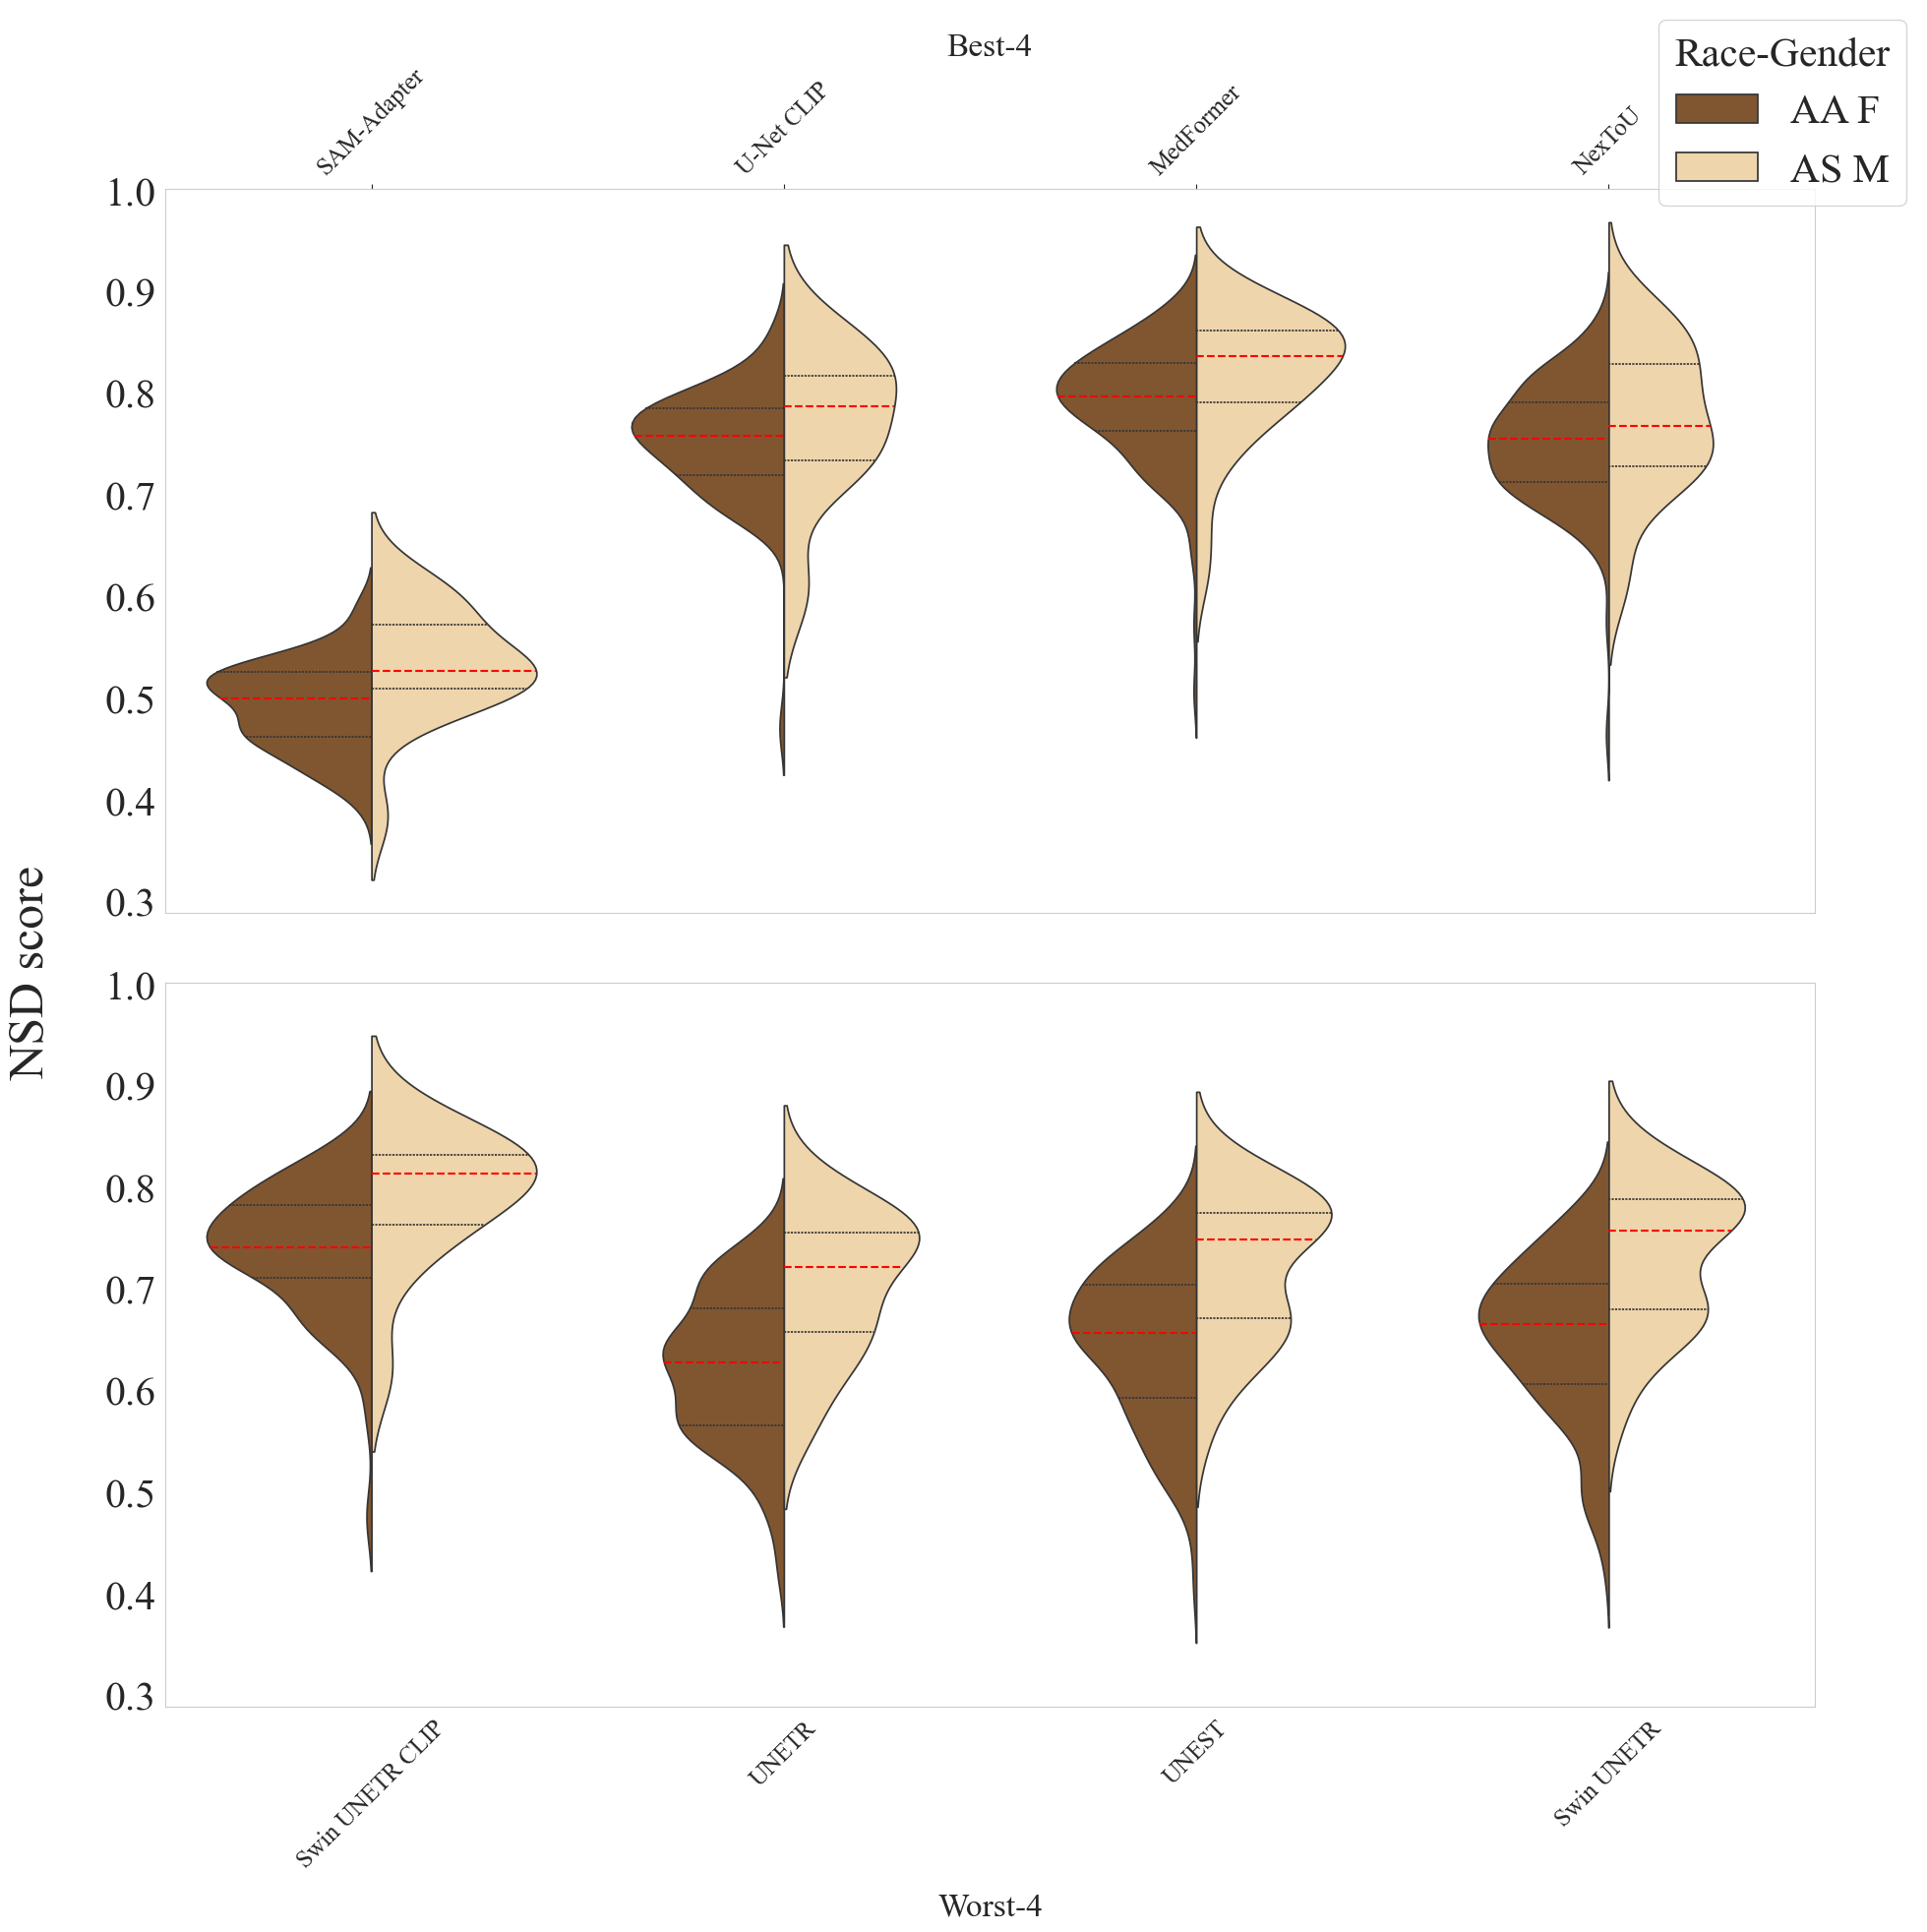

In [ ]:
import re

def pretty(name: str) -> str:
    """Vision_Language_Swin_UNETR_CLIP → VL-Swin UNETR CLIP, Diff-UNet → Diff-UNet"""
    name = model_name_mapping.get(name, name)
    name = name.replace('_', ' ')
    return re.sub(r'\s{2,}', ' ', name).strip()

model_name_mapping = {
    "_Diff-UNet":                "Diff-UNet",
    "_MedFormer":                "MedFormer",
    "_SAM-Adapter":              "SAM-Adapter",
    "Vision_Language_Swin_UNETR_CLIP": "VL-Swin UNETR CLIP",
    "Vision_Language_U-Net_CLIP":      "VL-U-Net CLIP",
}

# --------------------------------------------------
# 1-bis.  Pick Best-4 / Worst-4 by absolute disparity
# --------------------------------------------------
abs_dpd          = dpd_values.abs().sort_values(ascending=True)
best_dpd_models  = abs_dpd.head(4).index.tolist()      # smallest |DPD|
worst_dpd_models = abs_dpd.tail(4).index.tolist()      # largest  |DPD|

# --------------------------------------------------
# 2.  Build tidy DataFrame with prettified names
# --------------------------------------------------
mask_base = (((df_nsd_full['race'] == 'AA') & (df_nsd_full['sex'] == 'F')) |
             ((df_nsd_full['race'] == 'AS') & (df_nsd_full['sex'] == 'M')))

df_plot = df_nsd_full[mask_base].copy()
df_plot['Race-Gender'] = df_plot['race'] + ' ' + df_plot['sex']
df_plot['Model_pretty'] = df_plot['Model'].apply(pretty)      # NEW

df_plot['Tier'] = np.nan
df_plot.loc[df_plot['Model'].isin(best_dpd_models),  'Tier'] = 'Best-4'
df_plot.loc[df_plot['Model'].isin(worst_dpd_models), 'Tier'] = 'Worst-4'
df_plot = df_plot.dropna(subset=['Tier'])

# prettified order lists
orders = {
    'Best-4':  [pretty(m) for m in best_dpd_models],
    'Worst-4': [pretty(m) for m in worst_dpd_models]
}

# --------------------------------------------------
# 3.  Plot
# --------------------------------------------------
# sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, figsize=(20, 20), sharey=True)

for ax, tier in zip(axes, ['Best-4', 'Worst-4']):
    sns.violinplot(
        ax=ax,
        data=df_plot[df_plot['Tier'] == tier],
        x='Model_pretty', y='mean_nsd',                  # ← prettified axis
        hue='Race-Gender',
        split=True, inner='quartile',
        order=orders[tier],
        palette={"AA F": "#8D5524", "AS M": "#FAD7A0"}
    )

    # make only the median bars red & dotted
    for i, line in enumerate(ax.lines):
        if i % 3 == 1:                       # median line in each triplet
            line.set_color('red')
            line.set_linestyle('--')
            line.set_linewidth(1.5)
    
    ax.grid(False)

    if tier == 'Best-4':
        ax.set_title(tier, fontsize=24, pad=6)          # Top row: title above
    else:
        ax.set_title(tier, fontsize=24, y=-0.3)        # Bottom row: title below
    ax.set_xlabel("")
    ax.set_ylabel("")                        # no y-label
    ax.tick_params(axis='x', rotation=45, labelsize=18)
    ax.get_legend().remove()

# x-ticks on top for Best-4 row
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].tick_params(axis='x', bottom=False, top=True,
                    labelbottom=False, labeltop=True)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Race-Gender",
           loc='upper right', frameon=True)

fig.supylabel("NSD score")

fig.tight_layout(rect=[0, 0, 0.96, 1])
fig.savefig("figures/3_demographic_parity/split_violin_best_vs_worst.pdf",
            dpi=300)
plt.show()

### Split Violin Plot - Horizontal

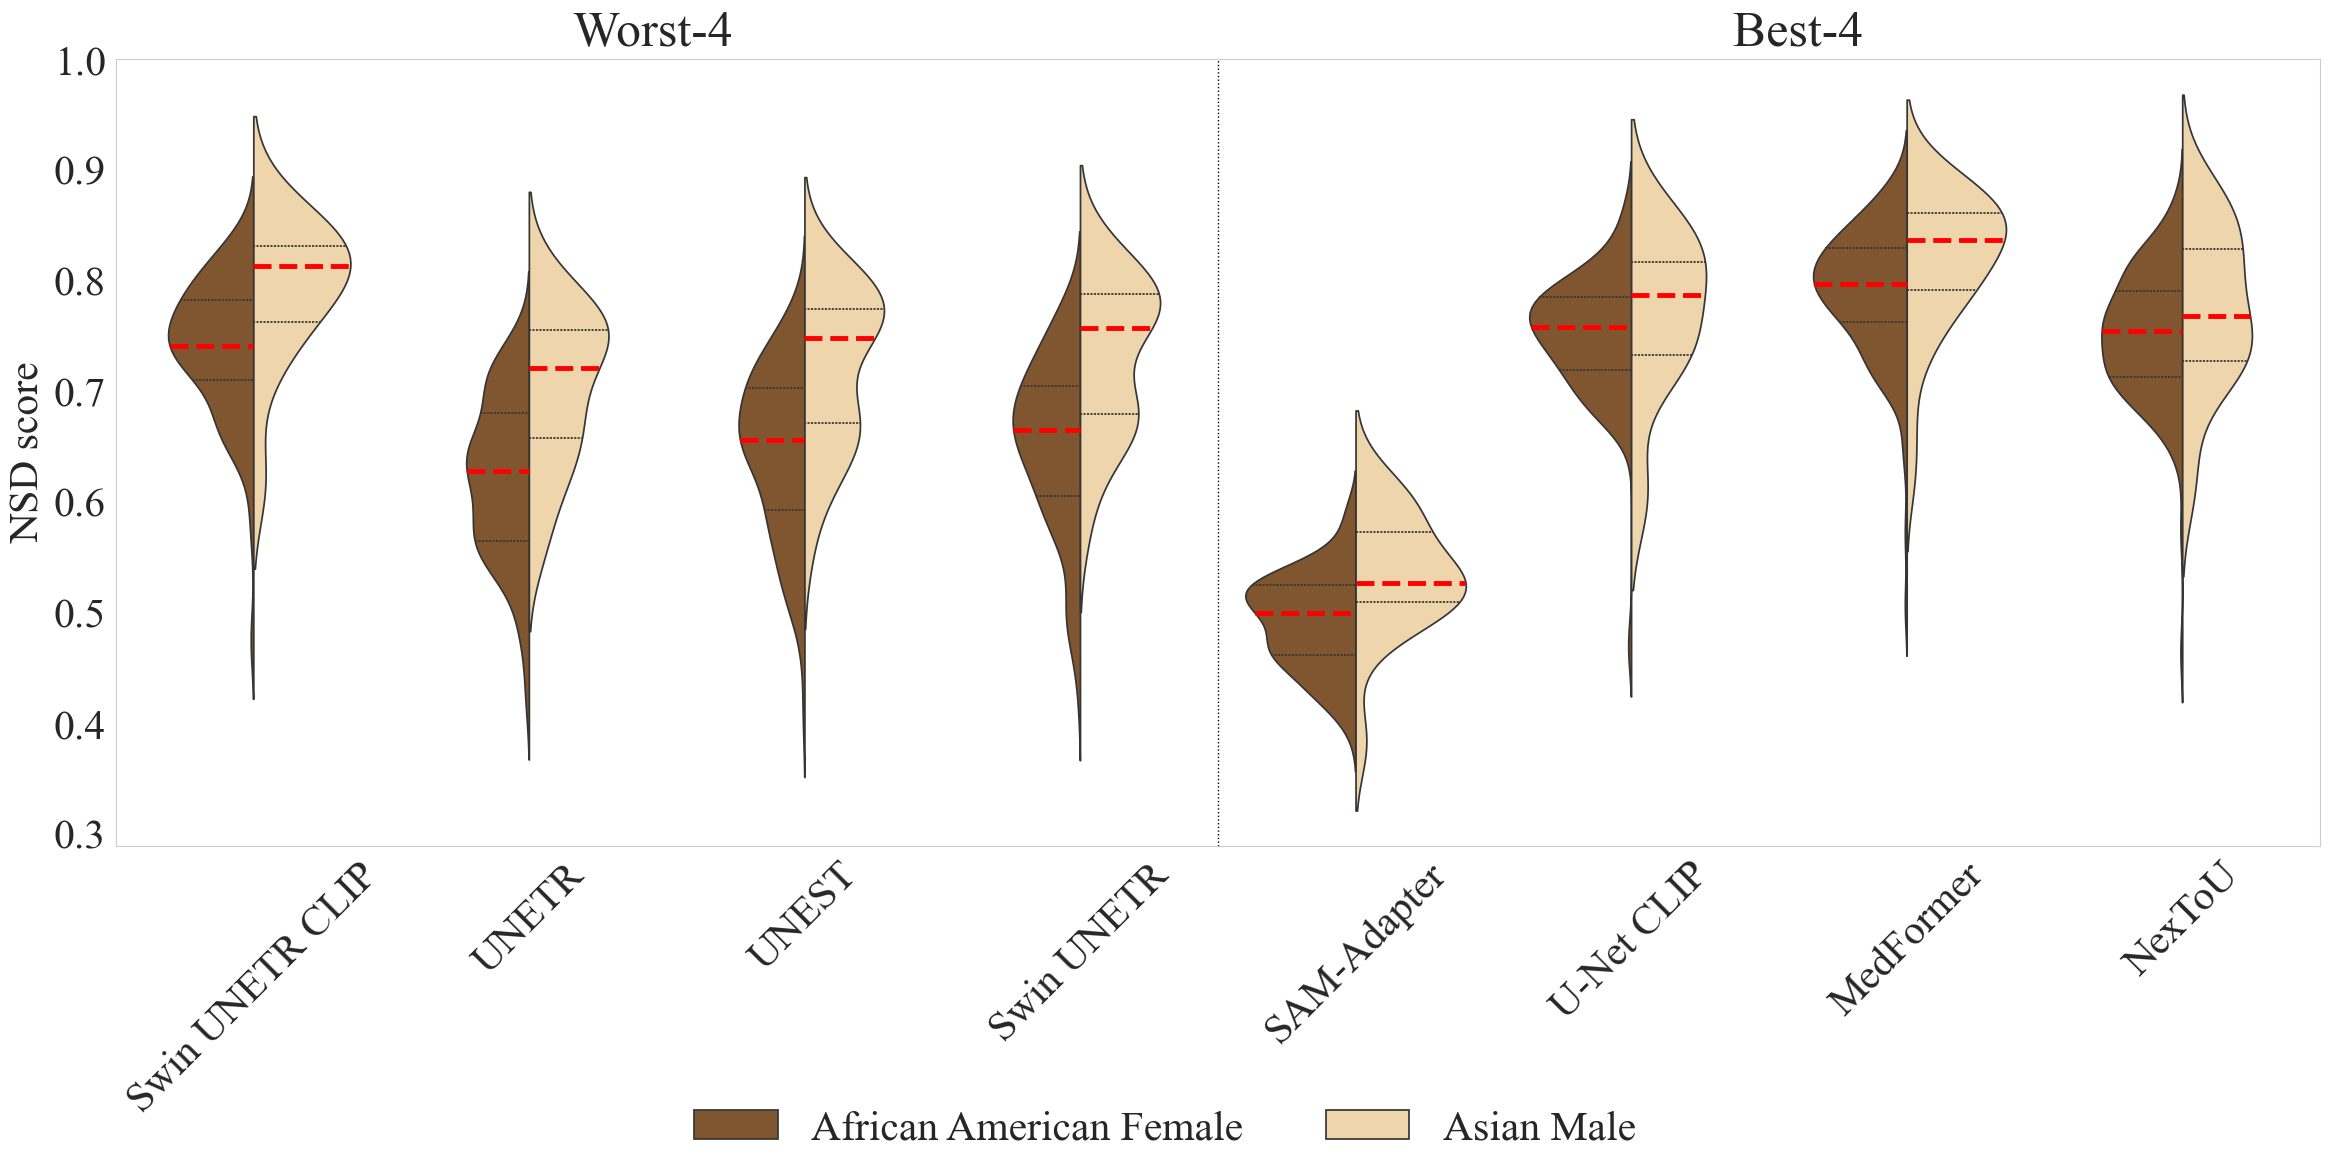

In [8]:
# --------------------------------------------------
# 0.  Imports & font (unchanged)  ── run BEFORE plotting
# --------------------------------------------------
import matplotlib as mpl, seaborn as sns, matplotlib.pyplot as plt, re

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"],
    "font.size":   30,
})
sns.set_style("whitegrid", rc={
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "Liberation Serif", "DejaVu Serif"],
})

# --------------------------------------------------
# 1.  Prettify helper (unchanged)
# --------------------------------------------------
def pretty(name: str) -> str:
    name = model_name_mapping.get(name, name)
    name = name.replace('_', ' ')
    return re.sub(r'\s{2,}', ' ', name).strip()

model_name_mapping = {
    "_Diff-UNet":                "Diff-UNet",
    "_MedFormer":                "MedFormer",
    "_SAM-Adapter":              "SAM-Adapter",
    "Vision_Language_Swin_UNETR_CLIP": "VL-Swin UNETR CLIP",
    "Vision_Language_U-Net_CLIP":      "VL-U-Net CLIP",
}

# --------------------------------------------------
# 2.  BEST-4 / WORST-4 lists (|DPD|)
# --------------------------------------------------
abs_dpd          = dpd_values.abs().sort_values(ascending=True)
best_dpd_models  = abs_dpd.head(4).index.tolist()
worst_dpd_models = abs_dpd.tail(4).index.tolist()

# prettified order: worst-4 first, a spacer, then best-4
order_pretty = [pretty(m) for m in worst_dpd_models + best_dpd_models]

# --------------------------------------------------
# 3.  Data for plotting
# --------------------------------------------------
mask_base = (((df_nsd_full['race'] == 'AA') & (df_nsd_full['sex'] == 'F')) |
             ((df_nsd_full['race'] == 'AS') & (df_nsd_full['sex'] == 'M')))

df_plot = df_nsd_full[mask_base].copy()
df_plot['Race-Gender'] = df_plot['race'] + ' ' + df_plot['sex']
df_plot['Model_pretty'] = df_plot['Model'].apply(pretty)

# Keep only rows for the eight selected models
selected_models = set(best_dpd_models + worst_dpd_models)
df_plot = df_plot[df_plot['Model'].isin(selected_models)]

# --------------------------------------------------
# 4.  Single-row violin plot
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(24, 12), sharey=True)

sns.violinplot(
    ax=ax,
    data=df_plot,
    x='Model_pretty', y='mean_nsd',
    hue='Race-Gender',
    split=True, inner='quartile',
    order=order_pretty,
    palette={"AA F": "#8D5524", "AS M": "#FAD7A0"}
)

# --- remove the auto-created legend -------------------------------
if ax.get_legend() is not None:
    ax.get_legend().remove()

# colour only the median bars red & dotted
for i, line in enumerate(ax.lines):
    if i % 3 == 1:                # median line in each triplet
        line.set_color('red')
        line.set_linestyle('--')
        line.set_linewidth(3.5)

# Cosmetic tweaks
ax.set_xlabel("")                 # no x-label
ax.set_ylabel("NSD score")        # keep y-label (remove if unwanted)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Worst-4                                                                                Best-4", pad=10)

# Vertical divider between worst & best groups
ax.axvline(x=3.5, color='black', linestyle=':', linewidth=1)  # after 4th violin

ax.grid(False)            # remove all gridlines

# ───────────────────────────────────────── legend off-axis (mid-right)
handles, _ = ax.get_legend_handles_labels()      # we keep shapes/colors only
fig.legend(handles,
           ["African American Female", "Asian Male"],        # custom text you chose
           frameon=False,
           loc='lower center',                   # centre-bottom of the figure
           ncol=2,                              # horizontal layout
           bbox_to_anchor=(0.5, 0.0),          # a touch below the axes
           borderaxespad=0.)


fig.tight_layout()
fig.savefig("figures/3_demographic_parity/split_violin_worst_left_best_right.pdf",
            dpi=300)
plt.show()

In [69]:
labels

['AA F', 'AS M']

In [ ]:
dpd_values

Model
Diff-UNet          0.229688
LHU-Net            0.209974
MedFormer          0.071391
MedNeXt            0.169271
NexToU             0.084375
SAM-Adapter        0.000000
STU-Net B          0.141667
STU-Net H          0.145833
STU-Net L          0.151563
SegVol             0.153125
Swin_UNETR         0.446719
Swin_UNETR_CLIP    0.379487
U-Net_CLIP        -0.002886
UCTransNet         0.147396
UNEST              0.429134
UNETR              0.392126
UniSeg             0.112500
nnU-Net U-Net      0.131771
nnU-Net_ResEncL    0.141667
dtype: float64

### DPD Rankings

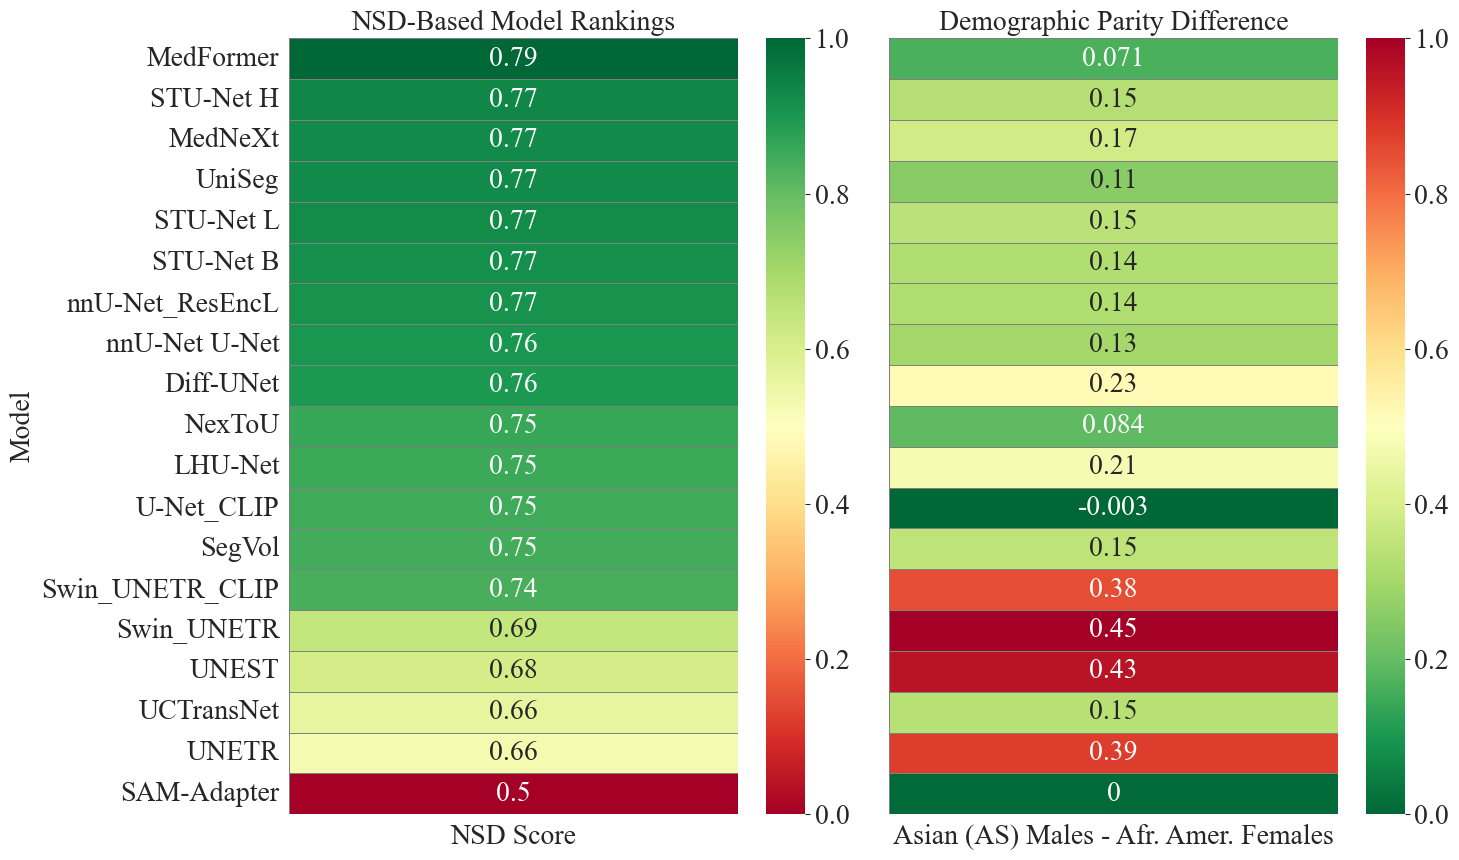

In [ ]:
# Compute overall NSD mean per model for ranking
model_nsd_means = df_nsd_full.groupby('Model')['mean_nsd'].mean().sort_values(ascending=False)

# Compute ranking based on NSD scores (higher NSD = better ranking)
model_nsd_ranks = model_nsd_means.rank(ascending=False, method='dense')

# Combine NSD rank and DPD values
ranking_data = pd.DataFrame({
    'NSD Score': model_nsd_means,
    'NSD Rank': model_nsd_ranks,
    'DPD (AS Men - AA Women)': dpd_values
}).sort_values(by='NSD Rank')

# Rename column for clarity
ranking_data_renamed = ranking_data.rename(columns={'DPD (AS Men - AA Women)': 'Asian (AS) Males - Afr. Amer. Females'})

# Normalize values for heatmap consistency
ranking_data_normalized = (ranking_data_renamed - ranking_data_renamed.min()) / (ranking_data_renamed.max() - ranking_data_renamed.min())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

# Heatmap for NSD Score
sns.heatmap(ranking_data_normalized[['NSD Score']],
            annot=ranking_data_renamed[['NSD Score']].round(3),
            cmap='RdYlGn', linewidths=0.5, linecolor='gray', cbar=True, ax=axes[0])
axes[0].set_title('NSD-Based Model Rankings', fontsize=20)
axes[0].set_ylabel('Model')

# Heatmap for renamed DPD column
sns.heatmap(ranking_data_normalized[['Asian (AS) Males - Afr. Amer. Females']],
            annot=ranking_data_renamed[['Asian (AS) Males - Afr. Amer. Females']].round(3),
            cmap='RdYlGn_r', linewidths=0.5, linecolor='gray', cbar=True, ax=axes[1])
axes[1].set_title('Demographic Parity Difference', fontsize=20)
axes[1].set_ylabel('')
axes[1].set_yticks([])

# No need to set xlabel manually, as the column header is now changed
plt.tight_layout()
plt.savefig("figures/3_demographic_parity/dpd_rankmap.pdf", format='pdf', dpi=300)
plt.show()


### Ranking across all 3 Metrics

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_47137/3673497660.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


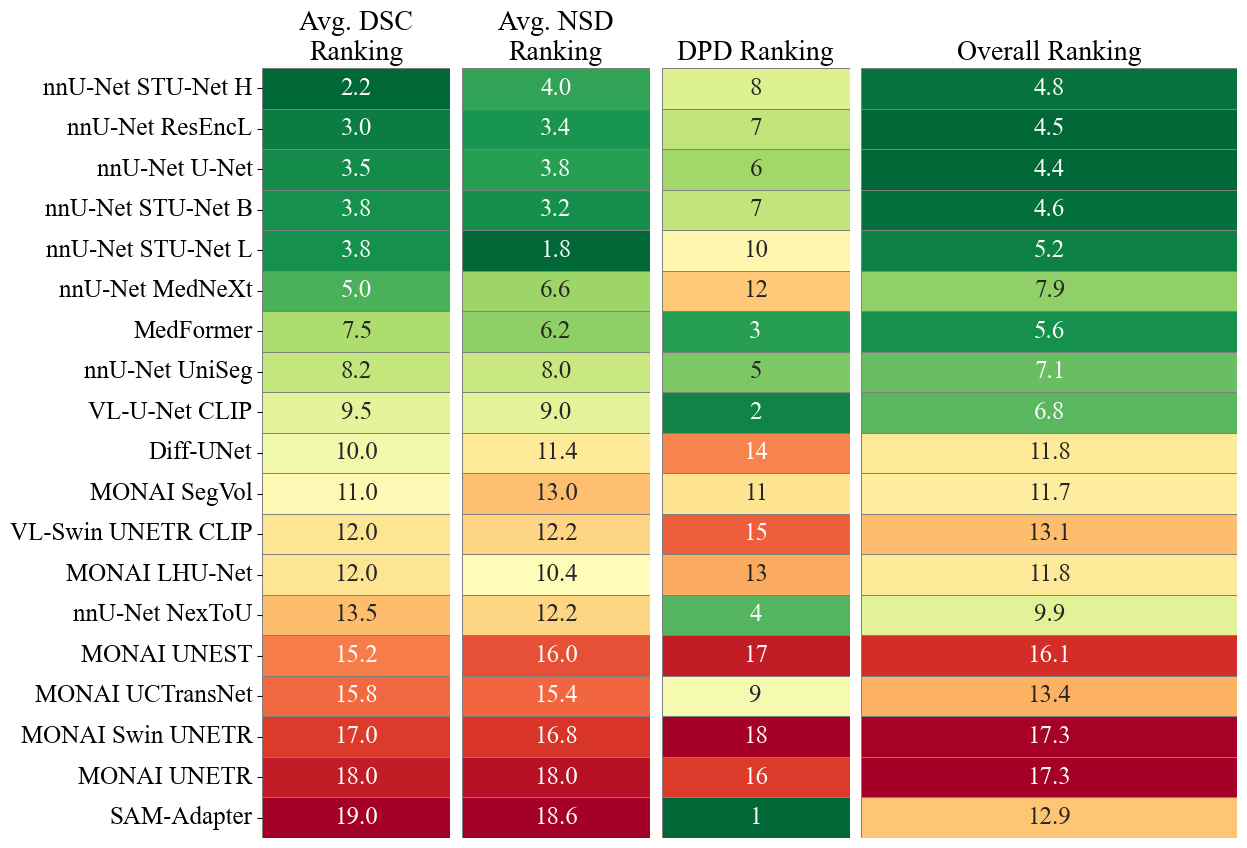

In [20]:
# ───────────────────────── 0.  Imports & style ──────────────────────
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman"],
    "font.size":   18,
})

# ───────────────────────── 1.  Pretty / canonical names ─────────────
model_name_mapping = {
    "_Diff-UNet": "Diff-UNet", "_MedFormer": "MedFormer",
    "_SAM-Adapter": "SAM-Adapter",
    "Vision_Language_Swin_UNETR_CLIP": "VL-Swin UNETR CLIP",
    "Vision_Language_U-Net_CLIP":      "VL-U-Net CLIP",
}

def pretty(full: str) -> str:                    # for DSC/NSD side
    full = model_name_mapping.get(full, full)
    full = full.replace('_', ' ')
    return re.sub(r'\s{2,}', ' ', full).strip()

def canonical(name: str) -> str:                 # common “core” key
    name = name.replace('_', ' ').strip()
    return re.sub(r'^(MONAI|nnU-Net|VL-)\s*', '', name, flags=re.I)

# ───────────────────────── 2.  Load DSC / NSD results ───────────────
ts_base = "./data/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

all_organs    = ["aorta","gall_bladder","kidney_left","kidney_right",
                 "liver","pancreas","postcava","spleen","stomach"]
organs_use_nsd = {"aorta","postcava","stomach","pancreas","gall_bladder"}
organs_use_dsc = set(all_organs) - organs_use_nsd

rows = []
for model in os.listdir(ts_base):
    mp = os.path.join(ts_base, model)
    if not os.path.isdir(mp): continue

    for metric, csv in [("DSC","dsc.csv"),("NSD","nsd.csv")]:
        f = os.path.join(mp, csv)
        if not os.path.exists(f): continue
        df = (pd.read_csv(f)
                .melt(id_vars=['name'], var_name='organ', value_name='value')
                .assign(model=model, metric=metric)
                .dropna())
        rows.append(df)

df_all = pd.concat(rows, ignore_index=True)
per_organ = df_all.groupby(["model","organ"])["value"].mean().unstack()
rankings  = per_organ.rank(ascending=False)

dsc_rank = rankings[ list(organs_use_dsc) ]
nsd_rank = rankings[ list(organs_use_nsd) ]

# sort + pretty indices
model_order = dsc_rank.median(axis=1).sort_values().index
dsc_rank, nsd_rank = dsc_rank.loc[model_order], nsd_rank.loc[model_order]
pretty_idx = pd.Index([pretty(m) for m in model_order], name="model")
dsc_rank.index = pretty_idx
nsd_rank.index = pretty_idx

dsc_avg = dsc_rank.mean(axis=1).to_frame("Avg DSC Rank")
nsd_avg = nsd_rank.mean(axis=1).to_frame("Avg NSD Rank")

# ───────────────────────── 3.  Compute DPD on JHH cohort ────────────
jhh_base = "./data/final_14dec2024_results/jhh_results - table 2 in paper"
meta = pd.read_csv(os.path.join(jhh_base, "jhh_metadata - for version 20.csv"))

# gather NSD per-patient
rows = {}
for model in [d for d in os.listdir(jhh_base) if os.path.isdir(os.path.join(jhh_base,d))]:
    f = os.path.join(jhh_base, model, "nsd.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f)
    df["Model"] = model
    rows[model] = df
df_nsd = pd.concat(rows.values(), ignore_index=True)

# mean NSD per patient
df_nsd["mean_nsd"] = df_nsd.drop(columns=["name","Model"]).mean(axis=1)
df_full = (df_nsd[["name","Model","mean_nsd"]]
           .merge(meta[["name","race","sex"]], on="name", how="left"))

filt = ((df_full.race=="AA")&(df_full.sex=="F")) | ((df_full.race=="AS")&(df_full.sex=="M"))
df_dpd = df_full[filt]

median_nsd = df_dpd["mean_nsd"].median()
dpd_as_men  = (df_dpd[df_dpd.race=="AS"]
               .groupby("Model")["mean_nsd"]
               .apply(lambda s: (s>median_nsd).mean()))
dpd_aa_women = (df_dpd[df_dpd.race=="AA"]
               .groupby("Model")["mean_nsd"]
               .apply(lambda s: (s>median_nsd).mean()))
dpd_values = dpd_as_men - dpd_aa_women      # Series index = short names

# ── 4.  Rename DPD index to match DSC/NSD full names ────────────────
canon_to_full = {canonical(full): full for full in dsc_avg.index}
dpd_values = dpd_values.rename(index=lambda s: canon_to_full.get(canonical(s), s))

# ── sanity: keep only rows with all three metrics ───────────────────
common = dsc_avg.index.intersection(dpd_values.index)
dsc_avg, nsd_avg = dsc_avg.loc[common], nsd_avg.loc[common]
dpd_rank = (dpd_values.loc[common].abs()
            .rank(ascending=True, method="dense")
            .rename("DPD Rank"))

# ───────────────────────── 5.  Plot three-column heat-map ───────────
combined = pd.concat([dsc_avg["Avg DSC Rank"],
                      nsd_avg["Avg NSD Rank"],
                      dpd_rank], axis=1)
combined = combined.sort_values("Avg DSC Rank")
norm = (combined - combined.min()) / (combined.max() - combined.min())

# ── after you build `combined` with the 3 columns … ─────────────────
combined = pd.concat([dsc_avg["Avg DSC Rank"],
                      nsd_avg["Avg NSD Rank"],
                      dpd_rank], axis=1)

# ➊  NEW: average of the three ranks
combined["Overall Avg Rank"] = combined.mean(axis=1)

# keep best-to-worst order by DSC
combined = combined.sort_values("Avg DSC Rank")

# column-wise normalisation (now 4 cols)
norm = (combined - combined.min()) / (combined.max() - combined.min())

# ──  plotting: change to 4 sub-plots  ───────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [.2, .2, .2, .4], 'wspace': 0.05})
cmap = "RdYlGn_r"

titles = ["Avg. DSC\nRanking", "Avg. NSD\nRanking", "DPD Ranking", "Overall Ranking"]

for ax, col, title in zip(axes, combined.columns, titles):
    if ax is not axes[2]:
        sns.heatmap(norm[[col]],
                    annot=combined[[col]].round(1),
                    cmap=cmap, cbar=False,
                    linewidths=.5, linecolor="gray",
                    ax=ax, fmt=".1f")
    else:
        sns.heatmap(norm[[col]],
            annot=combined[[col]].round(1),
            cmap=cmap, cbar=False,
            linewidths=.5, linecolor="gray",
            ax=ax, fmt=".0f") # Make DPD rank an Integer
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("")
    ax.set_xticks([])
    if ax is not axes[0]:
        ax.set_yticks([])
    # else:
    ax.set_ylabel(None)

plt.tight_layout()
fig.subplots_adjust(left=0.25)           # ← add explicit left margin
fig.savefig(
    "figures/3_demographic_parity/dpd_rankmap_combined.pdf",
    format="pdf", dpi=300,
    bbox_inches="tight", pad_inches=0.1   # keep labels inside page
)
plt.show()

# 3- Demographics - TotalSegmentator

## Siemens Scanner Submodel

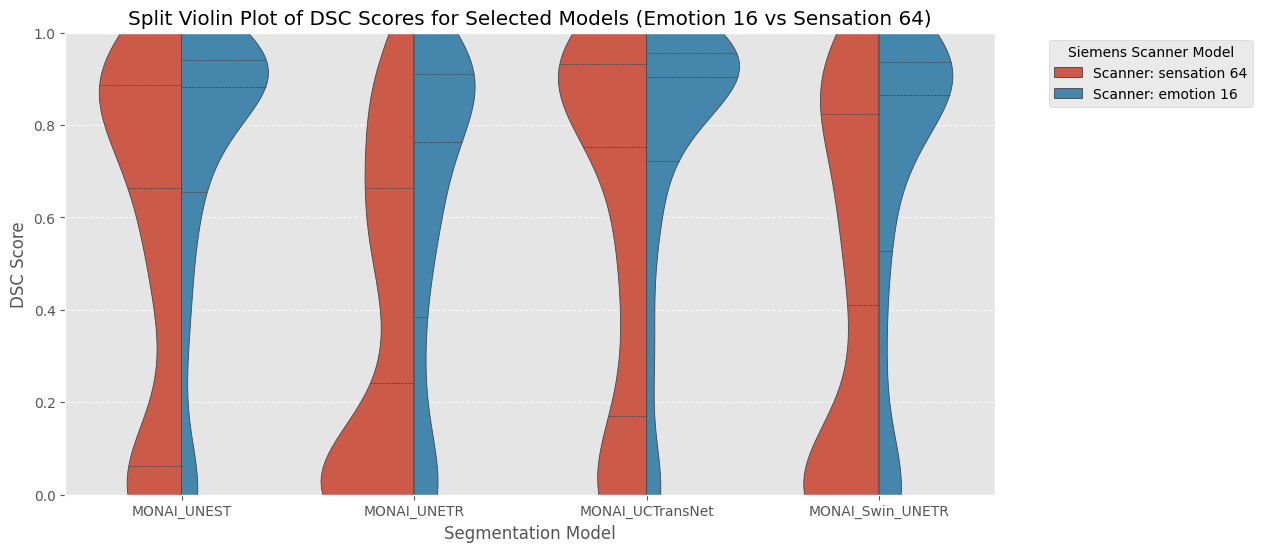

In [ ]:
# Re-import necessary libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Locate the main extracted directory
main_dir = "/Users/ariellubonja/prog/alans_lab/miccai_2025/Touchstone/totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# Load metadata file
metadata_path = os.path.join(main_dir, "totalsegmentator_metadata.csv")
metadata_df = pd.read_csv(metadata_path)

# Locate all model directories
model_dirs = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Reload performance data
performance_data = []

for model in model_dirs:
    model_path = os.path.join(main_dir, model)

    # File paths for DSC and NSD scores
    dsc_path = os.path.join(model_path, "dsc.csv")
    nsd_path = os.path.join(model_path, "nsd.csv")

    # Load files if they exist
    if os.path.exists(dsc_path) and os.path.exists(nsd_path):
        dsc_df = pd.read_csv(dsc_path)
        nsd_df = pd.read_csv(nsd_path)

        # Rename "name" to "image_id" for consistency
        dsc_df.rename(columns={"name": "image_id"}, inplace=True)
        nsd_df.rename(columns={"name": "image_id"}, inplace=True)

        # Merge DSC and NSD scores
        model_df = dsc_df.merge(nsd_df, on="image_id", suffixes=("_DSC", "_NSD"))
        model_df["model"] = model  # Add model name
        performance_data.append(model_df)

# Combine all model performance data
performance_df = pd.concat(performance_data, ignore_index=True)

# Merge performance data with metadata
performance_merged = performance_df.merge(metadata_df[["image_id", "manufacturer", "scanner_model"]], on="image_id", how="left")

# Reshape the data for computing statistics
dsc_columns = [col for col in performance_merged.columns if "_DSC" in col]
performance_long = performance_merged.melt(
    id_vars=["image_id", "manufacturer", "scanner_model", "model"],
    value_vars=dsc_columns,
    var_name="Structure",
    value_name="DSC_Score"
)

# Drop NaN values
performance_long = performance_long.dropna()

# Define the selected models
selected_models = ["MONAI_Swin_UNETR", "MONAI_UCTransNet", "MONAI_UNEST", "MONAI_UNETR"]

# Define the two Siemens scanner models to compare
scanner_models_to_compare = ["emotion 16", "sensation 64"]

# Filter the dataset for the selected models and scanners
comparison_data = performance_long[
    (performance_long["model"].isin(selected_models)) &
    (performance_long["scanner_model"].isin(scanner_models_to_compare))
].copy()

# Create a new column for violin split categories
comparison_data["Scanner Category"] = comparison_data["scanner_model"].apply(lambda x: f"Scanner: {x}")

# Plot a single violin plot with all models included, split by scanner type
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=comparison_data,
    x="model",
    y="DSC_Score",
    hue="Scanner Category",
    split=True,
    inner="quartile"
)

# Formatting
plt.title("Split Violin Plot of DSC Scores for Selected Models (Emotion 16 vs Sensation 64)")
plt.xlabel("Segmentation Model")
plt.ylabel("DSC Score")

# Restrict y-axis to valid range (0 to 1)
plt.ylim(0, 1)

# Adjust legend
plt.legend(title="Siemens Scanner Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 4. Arterial vs. Venous Phase

### <font color="purple">🔬 Does A-V perf. differ by model? Which models have the biggest Delta?>

<font color="blue">⚙️ Per-organ performance averaged into 1</font>

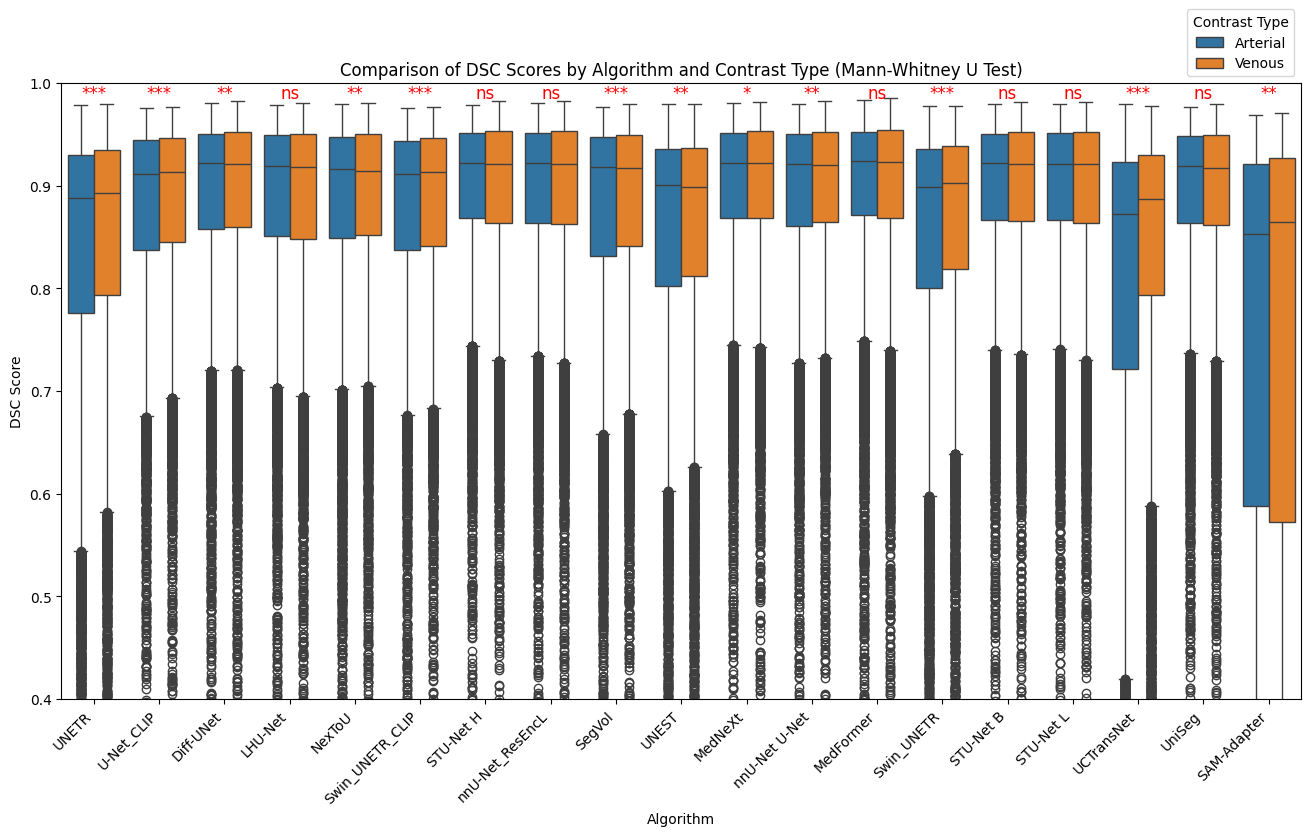

model  mean_Arterial  mean_Venous  std_Arterial  std_Venous  \
0         Diff-UNet       0.886309     0.886560      0.108769    0.108712   
1           LHU-Net       0.882725     0.879851      0.109232    0.112484   
2         MedFormer       0.891668     0.890898      0.107028    0.105661   
3           MedNeXt       0.891887     0.892999      0.102100    0.099405   
4            NexToU       0.877295     0.881959      0.118271    0.112170   
5       SAM-Adapter       0.739252     0.740981      0.223212    0.222461   
6         STU-Net B       0.891580     0.890605      0.099440    0.100871   
7         STU-Net H       0.892291     0.889402      0.099152    0.101801   
8         STU-Net L       0.891703     0.889069      0.099456    0.102209   
9            SegVol       0.870243     0.875753      0.126785    0.118116   
10       Swin_UNETR       0.841199     0.857187      0.154779    0.133268   
11  Swin_UNETR_CLIP       0.865524     0.871779      0.134528    0.120880   
12       U-Net_CLIP       0.869098     0.875243      0.125103    0.113521   
13       UCTransNet       0.793461     0.831672      0.192326    0.159812   
14            UNEST       0.847696     0.852699      0.143843    0.138367   
15            UNETR       0.827764     0.841935      0.157468    0.145116   
16           UniSeg       0.888642     0.887977      0.100652    0.099747   
17    nnU-Net U-Net       0.888571     0.890762      0.104314    0.100869   
18  nnU-Net_ResEncL       0.889409     0.888319      0.104428    0.104218   

    25%_Arterial  25%_Venous  Median_Arterial  Median_Venous  75%_Arterial  \
0       0.858315    0.859905         0.922144       0.921208      0.950489   
1       0.850761    0.848378         0.918806       0.918597      0.949007   
2       0.871004    0.868429         0.923816       0.922746      0.952542   
3       0.868590    0.868730         0.922123       0.921959      0.951255   
4       0.849129    0.851980         0.916310       0.913887      0.947616   
5       0.587640    0.572699         0.852966       0.864823      0.921346   
6       0.866317    0.865302         0.921741       0.920768      0.950655   
7       0.868413    0.863615         0.922262       0.921149      0.951597   
8       0.866986    0.863514         0.921387       0.920757      0.951146   
9       0.831735    0.841032         0.918271       0.917111      0.947654   
10      0.800529    0.818969         0.898806       0.902314      0.935963   
11      0.836971    0.841014         0.911442       0.913779      0.943964   
12      0.837027    0.845140         0.911800       0.913104      0.944934   
13      0.721954    0.793330         0.872299       0.887347      0.923568   
14      0.802365    0.812423         0.900534       0.898811      0.935771   
15      0.775610    0.793705         0.888260       0.893142      0.930102   
16      0.863524    0.861527         0.918900       0.917402      0.948294   
17      0.861109    0.864330         0.921516       0.920472      0.950341   
18      0.864154    0.862587         0.922013       0.920937      0.950876   

    75%_Venous  
0     0.952779  
1     0.950750  
2     0.954419  
3     0.952961  
4     0.950198  
5     0.927092  
6     0.952034  
7     0.952830  
8     0.952651  
9     0.949867  
10    0.938956  
11    0.946375  
12    0.946392  
13    0.930397  
14    0.936680  
15    0.934784  
16    0.949720  
17    0.952587  
18    0.952867

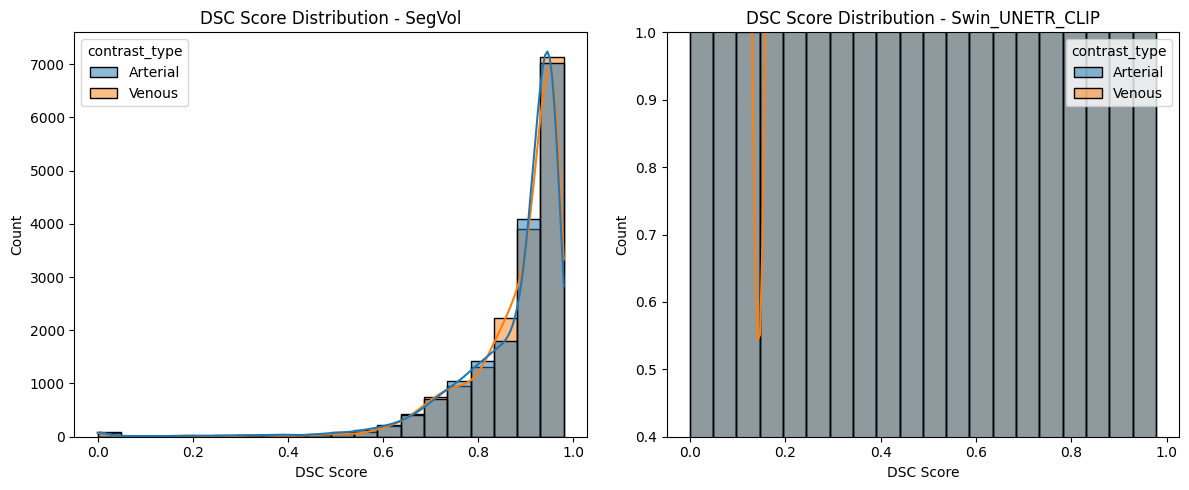

In [8]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

extract_folder = "../final_14dec2024_results"


# === STEP 2: Load Metadata ===
metadata_path = os.path.join(extract_folder, "jhh_results - table 2 in paper", "jhh_metadata - for version 20.csv")
metadata_df = pd.read_csv(metadata_path)

# Get valid patient IDs
metadata_ids = set(metadata_df["name"].unique())

# === STEP 3: Load Model Performance Data ===
performance_data = []

for root, dirs, files in os.walk(os.path.join(extract_folder, "jhh_results - table 2 in paper")):
    model_name = os.path.basename(root)
    if "dsc.csv" in files:
        file_path = os.path.join(root, "dsc.csv")
        df = pd.read_csv(file_path)

        # Keep only patients that exist in the metadata
        df = df[df["name"].isin(metadata_ids)]

        # Extract contrast type (Arterial 'A' or Venous 'V')
        df["contrast_type"] = df["name"].apply(lambda x: "Arterial" if "_A" in x else "Venous")
        df["model"] = model_name

        performance_data.append(df)

# Concatenate all model data
performance_df = pd.concat(performance_data, ignore_index=True)

# === STEP 4: Reshape Data for Visualization ===
performance_melted = performance_df.melt(
    id_vars=["name", "contrast_type", "model"],
    var_name="organ",
    value_name="dsc_score",
)

performance_melted.dropna(inplace=True)

# === STEP 5: Perform Mann-Whitney U Test for Significance ===
stat_results = []
for model in performance_melted["model"].unique():
    model_data = performance_melted[performance_melted["model"] == model]
    arterial_scores = model_data[model_data["contrast_type"] == "Arterial"]["dsc_score"].dropna()
    venous_scores = model_data[model_data["contrast_type"] == "Venous"]["dsc_score"].dropna()

    if len(arterial_scores) > 0 and len(venous_scores) > 0:
        mw_stat, p_value = mannwhitneyu(arterial_scores, venous_scores, alternative="two-sided")
    else:
        mw_stat, p_value = None, None

    stat_results.append({"model": model, "mw_stat": mw_stat, "p_value": p_value})

# Convert to DataFrame
stat_results_df = pd.DataFrame(stat_results)

# === STEP 6: Create Boxplot with Significance Markers ===
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="model", y="dsc_score", hue="contrast_type", data=performance_melted)
plt.title("Comparison of DSC Scores by Algorithm and Contrast Type (Mann-Whitney U Test)")
plt.xlabel("Algorithm")
plt.ylabel("DSC Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Contrast Type", loc="lower right", bbox_to_anchor=(1, 1))

# Add p-value significance markers
for i, model in enumerate(stat_results_df["model"]):
    p_val = stat_results_df.loc[stat_results_df["model"] == model, "p_value"].values[0]
    if p_val is not None:
        if p_val > 0.05:
            significance = "ns"
        elif p_val <= 0.05 and p_val > 0.01:
            significance = "*"
        elif p_val <= 0.01 and p_val > 0.001:
            significance = "**"
        else:
            significance = "***"
        ax.text(i, performance_melted["dsc_score"].max(), significance, ha="center", fontsize=12, color="red")

plt.ylim(0.4, 1)
plt.show()

# === STEP 7: Compute and Display Mean, Std, and IQR ===
# Compute mean and std
performance_summary = performance_melted.groupby(["model", "contrast_type"])["dsc_score"].agg(["mean", "std"]).reset_index()

# Compute IQR statistics (25%, median, 75%)
iqr_summary = performance_melted.groupby(["model", "contrast_type"])["dsc_score"].quantile([0.25, 0.5, 0.75]).unstack()
iqr_summary.columns = ["25%", "Median", "75%"]
iqr_summary.reset_index(inplace=True)

# Merge Mean/Std with IQR Summary
performance_summary_full = pd.merge(performance_summary, iqr_summary, on=["model", "contrast_type"], how="left")

# Pivot table for better readability
performance_pivot_full = performance_summary_full.pivot(index="model", columns="contrast_type", values=["mean", "std", "25%", "Median", "75%"])
performance_pivot_full.columns = [f"{stat}_{contrast}" for stat, contrast in performance_pivot_full.columns]
performance_pivot_full.reset_index(inplace=True)

# Display the updated table with mean, std, and IQR statistics
display(performance_pivot_full)

# === STEP 8: Create Histogram of DSC Score Distributions ===
plt.figure(figsize=(12, 5))
for i, model in enumerate(["SegVol", "Swin_UNETR_CLIP"], 1):
    plt.subplot(1, 2, i)
    sns.histplot(performance_melted[performance_melted["model"] == model], x="dsc_score", hue="contrast_type", kde=True, bins=20)
    plt.title(f"DSC Score Distribution - {model}")
    plt.xlabel("DSC Score")
    plt.ylabel("Count")

plt.tight_layout()
plt.ylim(0.4, 1)
plt.show()

### 🔬 Is Segmentation Performance Consistent Across Organs?

🔬 <font color="blue">Tests whether certain algorithms are consistently worse in one phase vs. another </font>

🧪 <font color="green">Most are comparable, UCTransNet, UNETR are significantly worse</font>

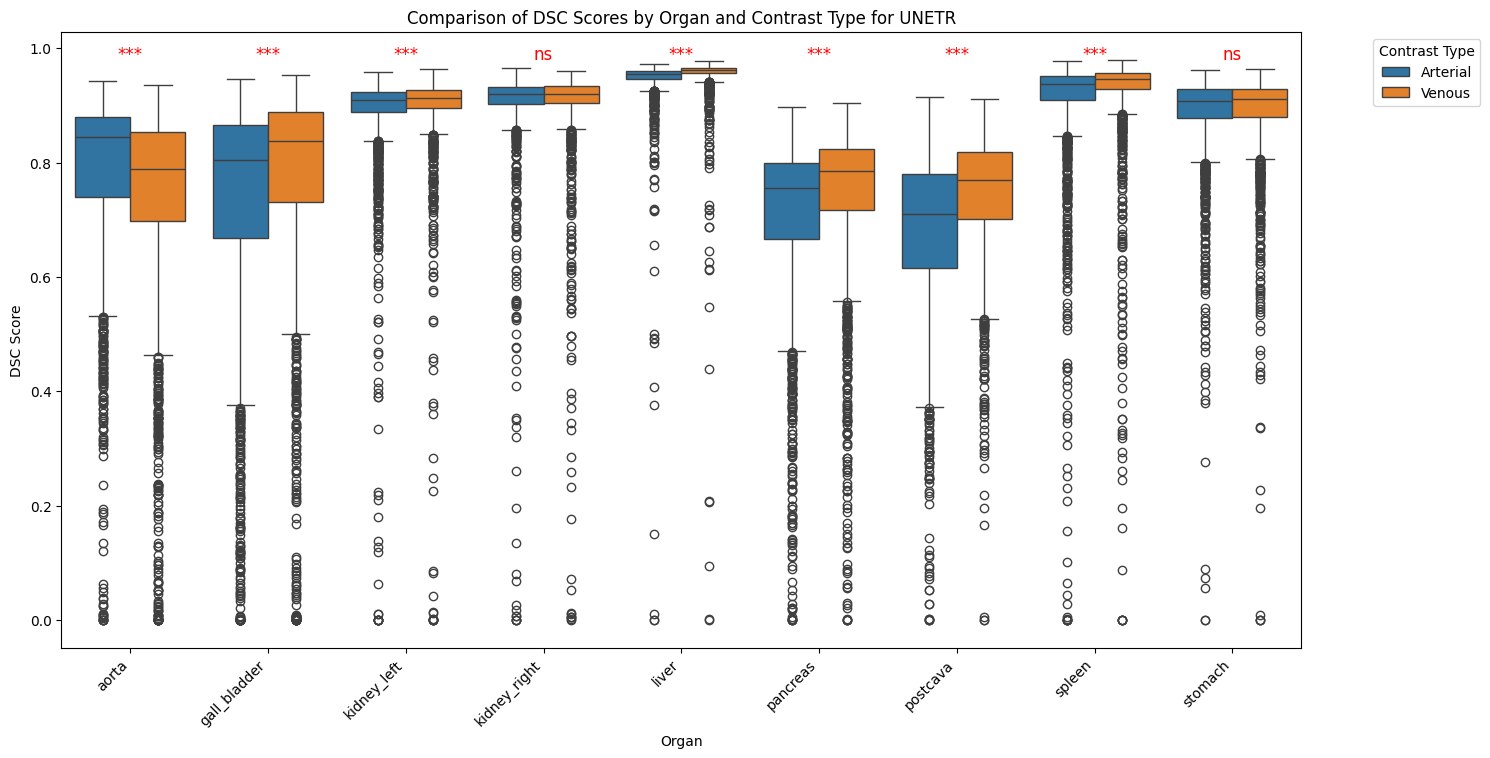

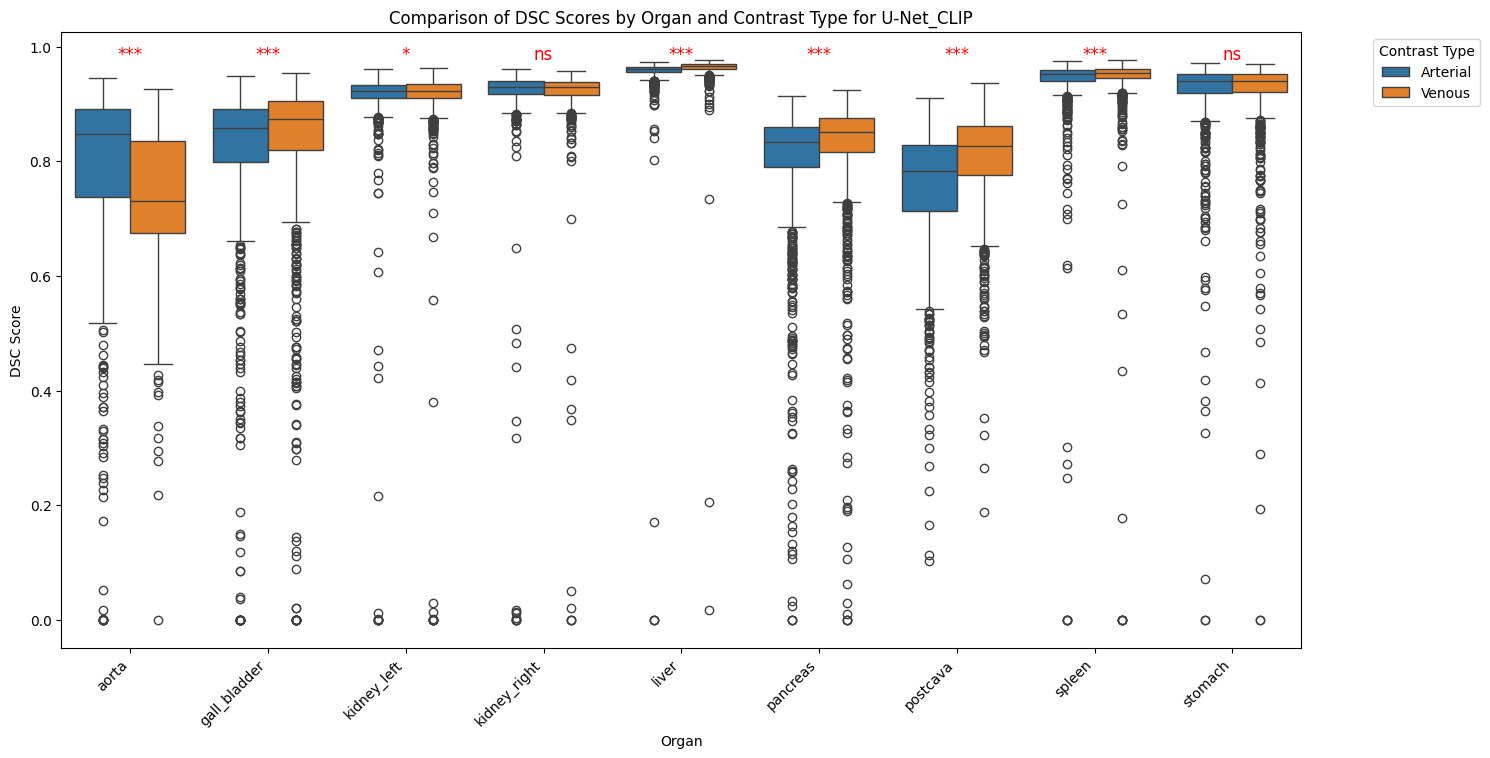

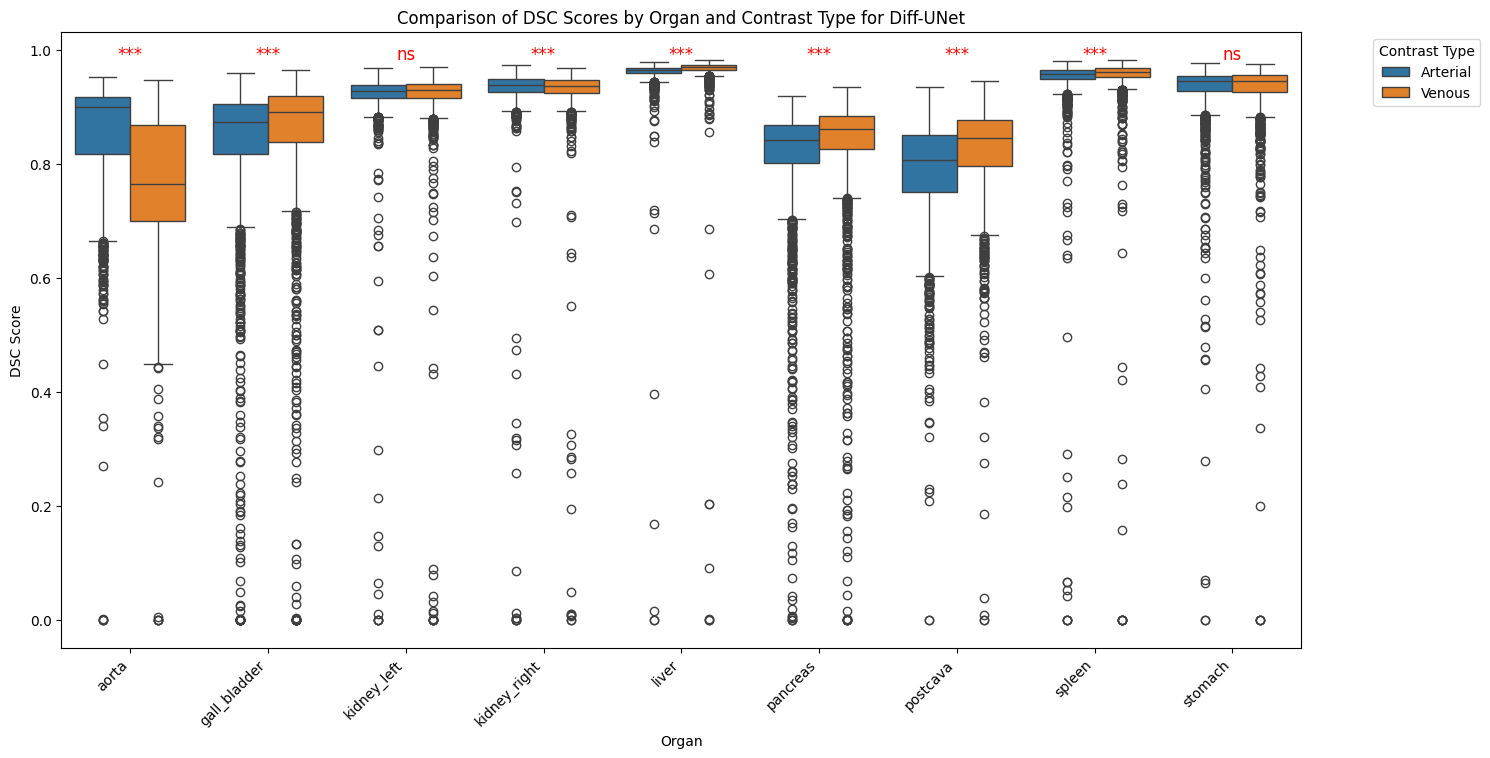

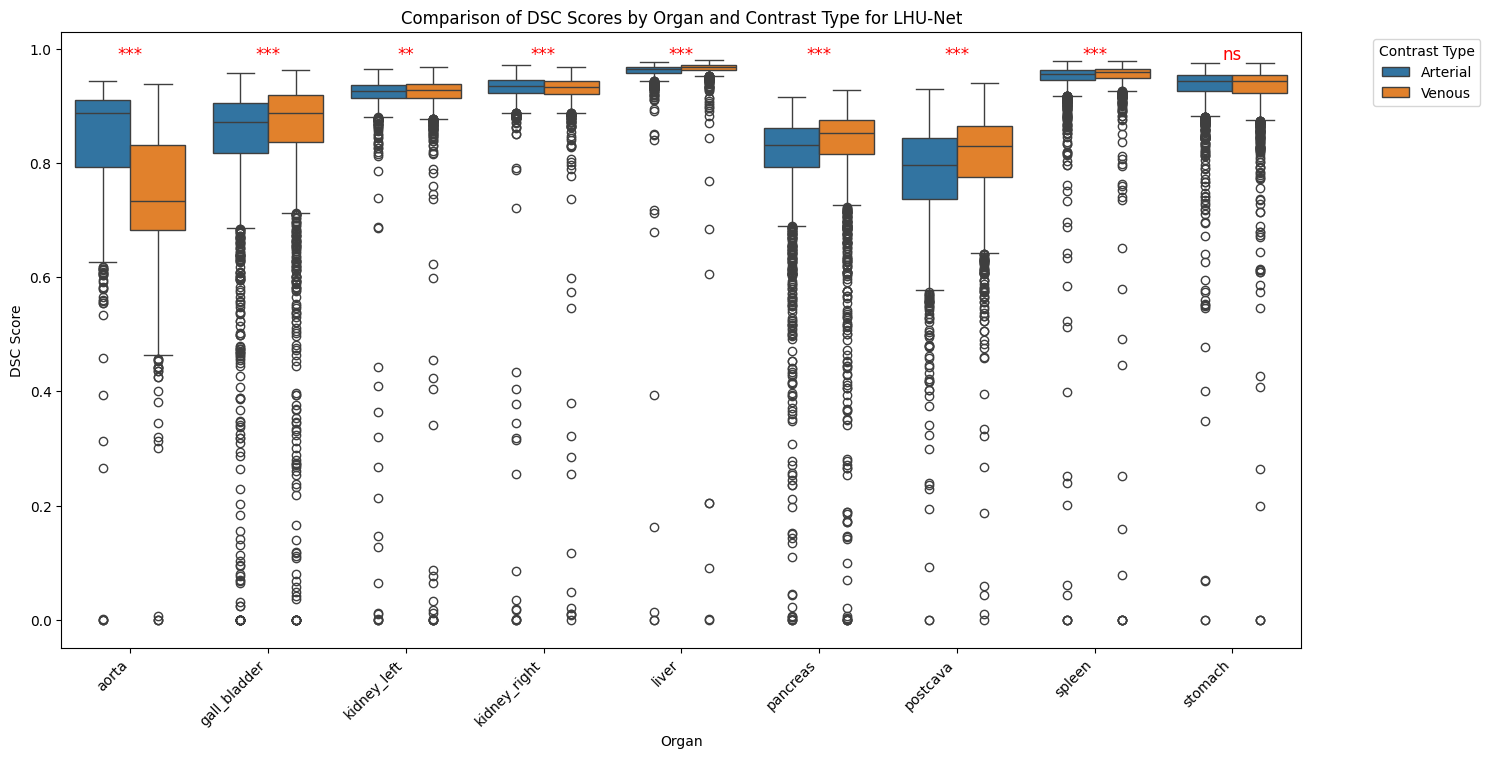

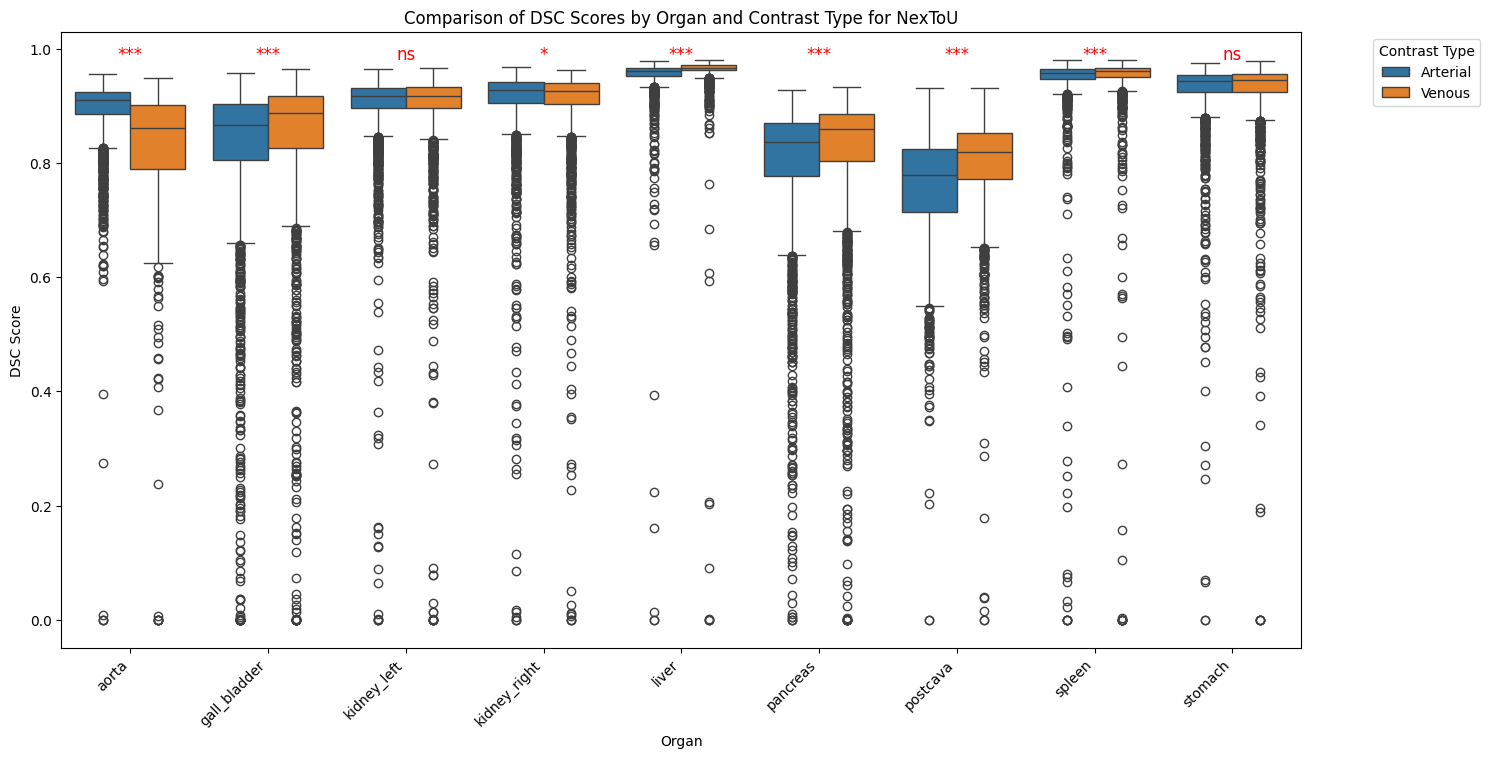

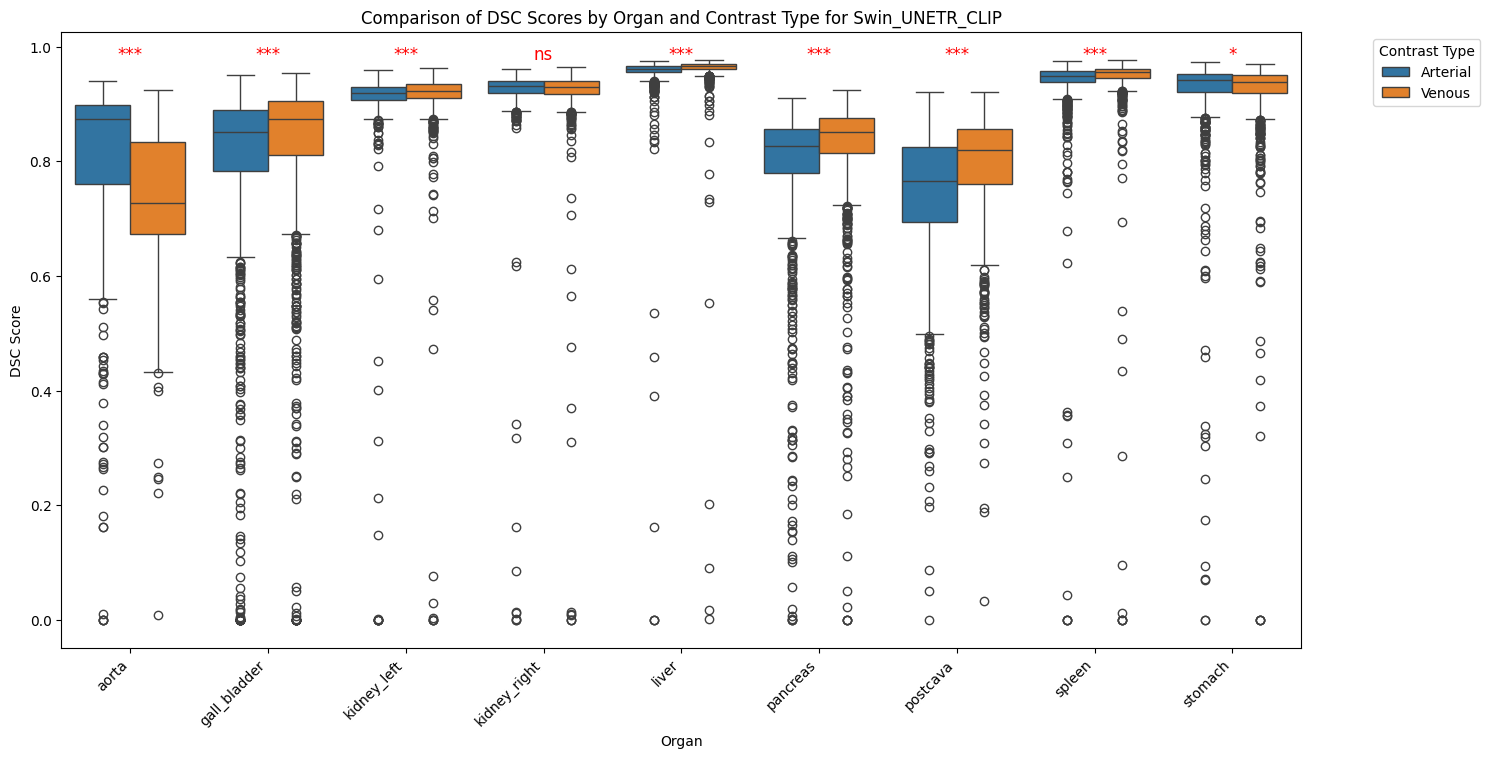

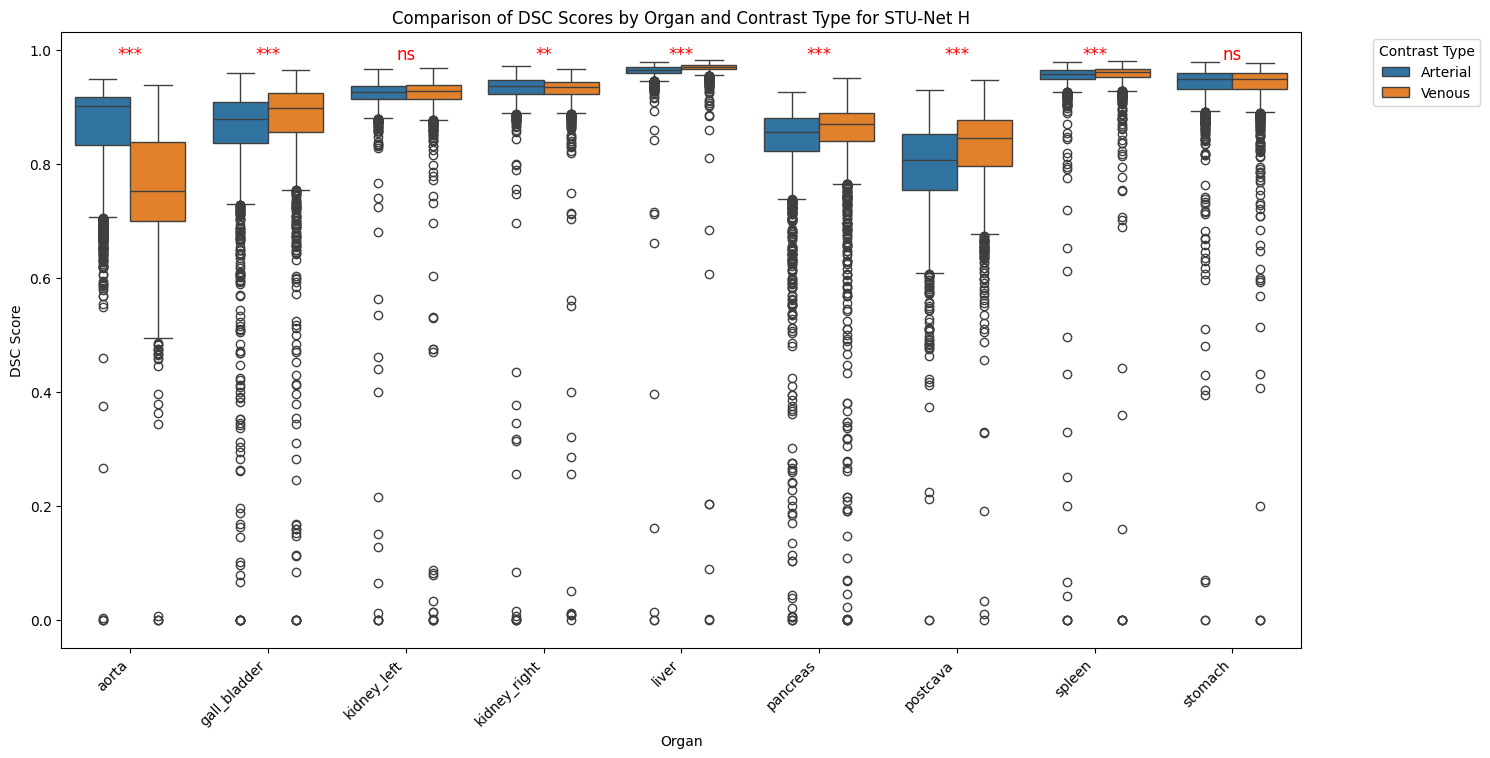

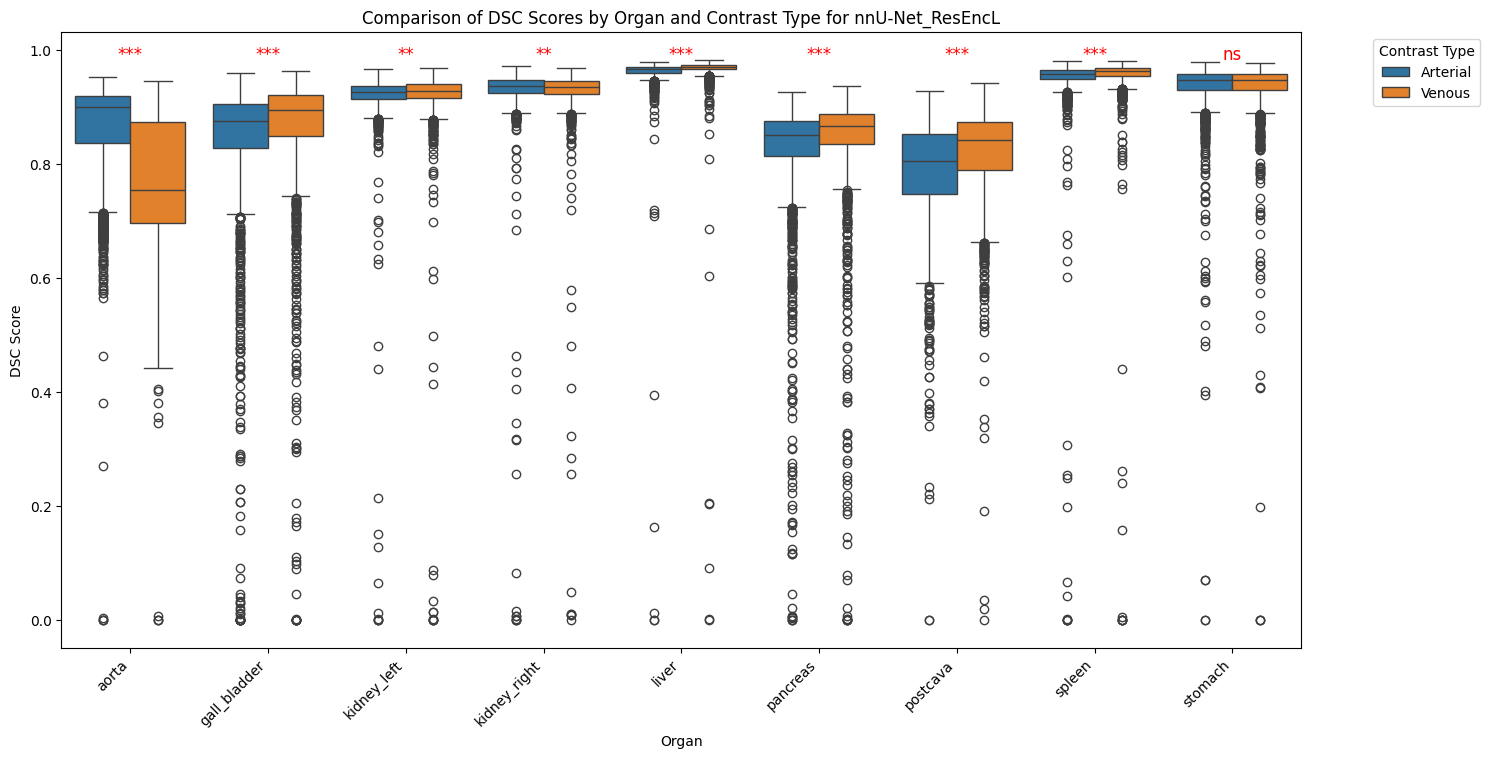

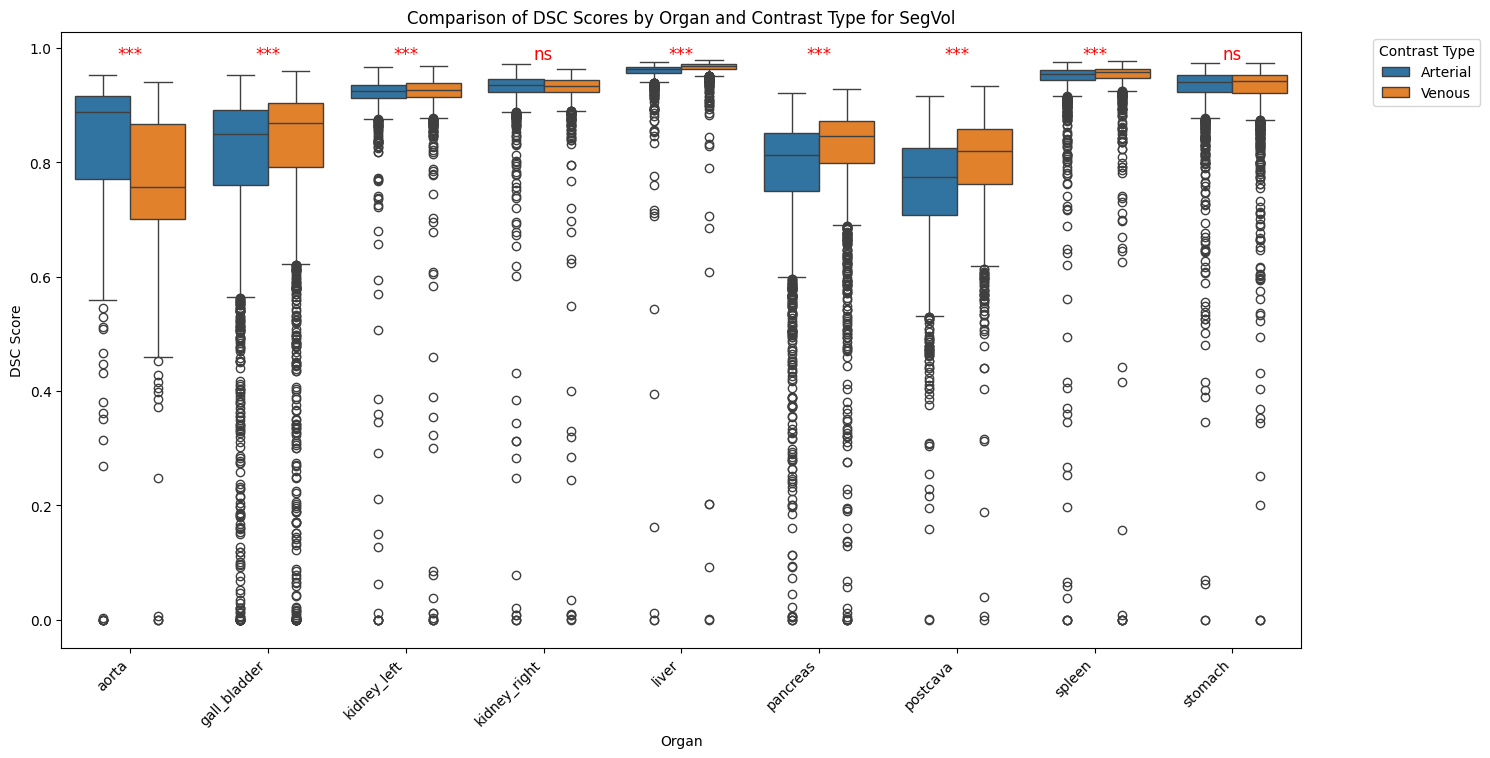

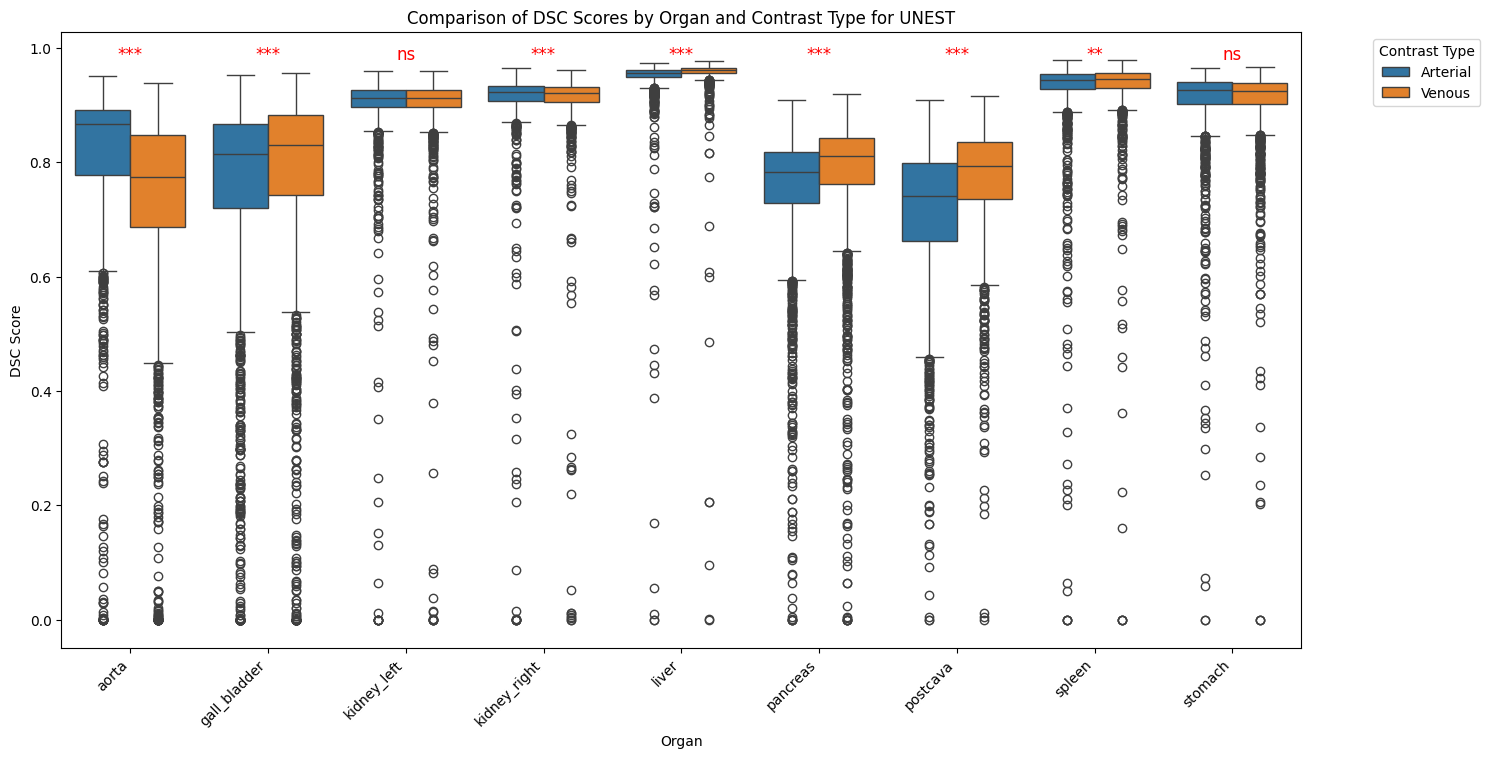

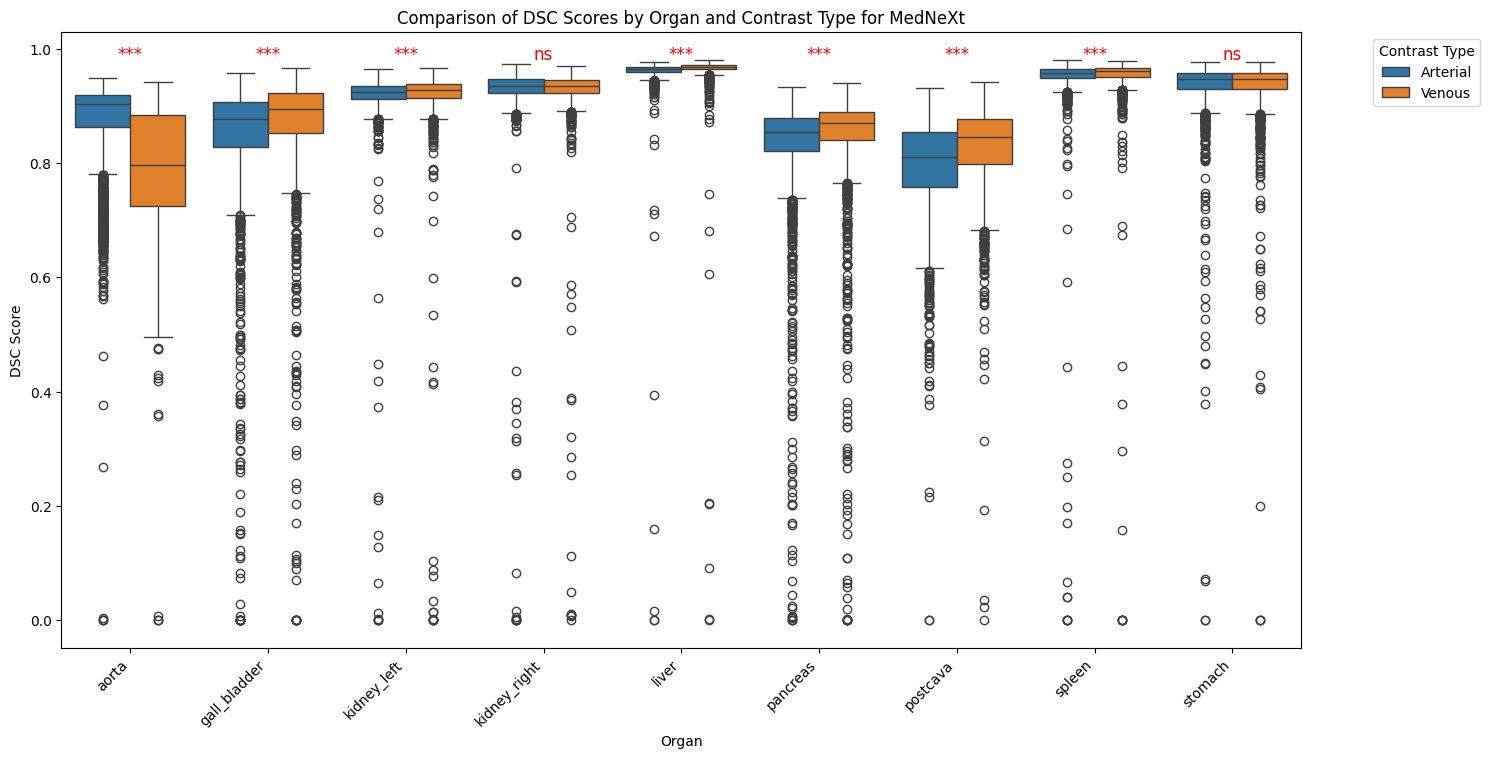

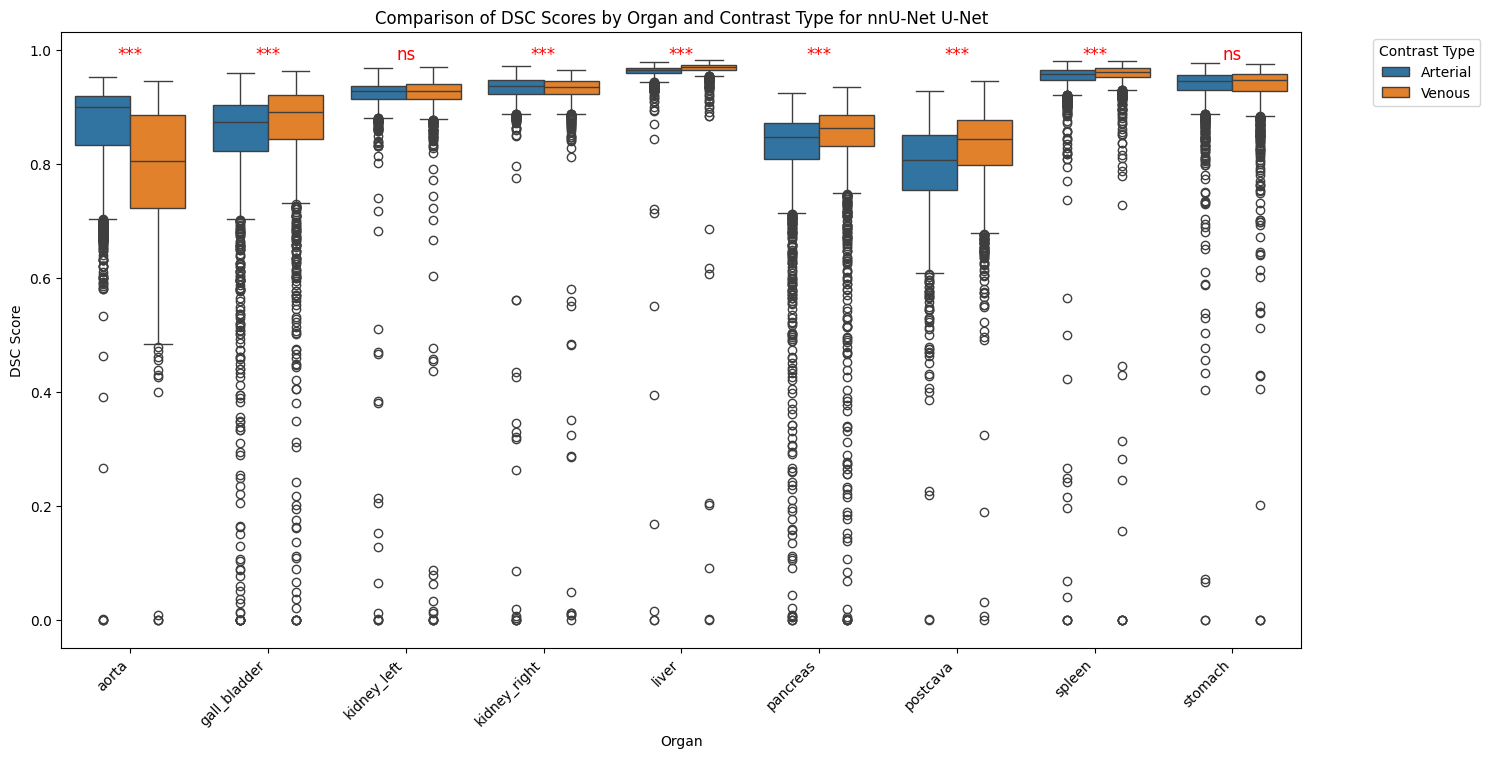

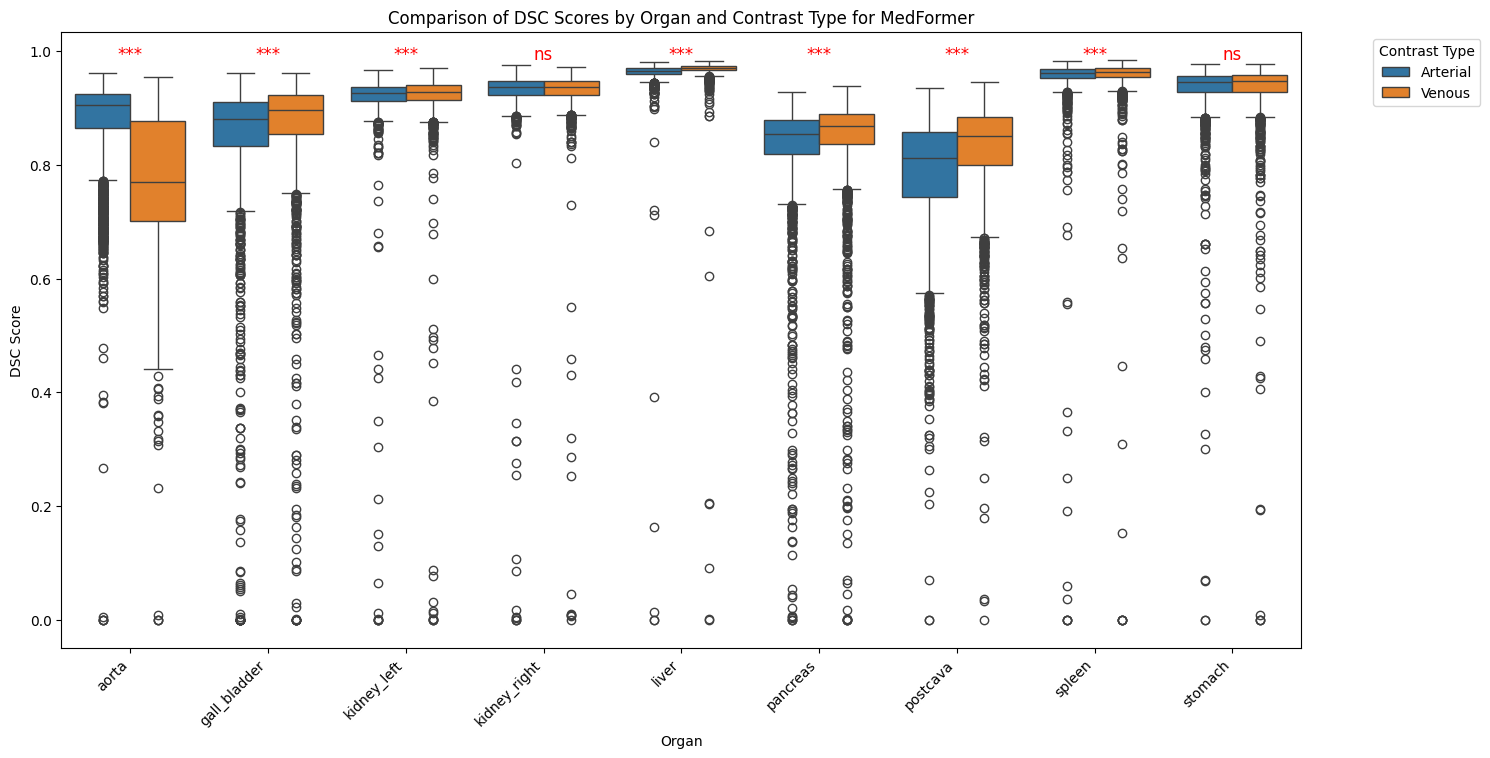

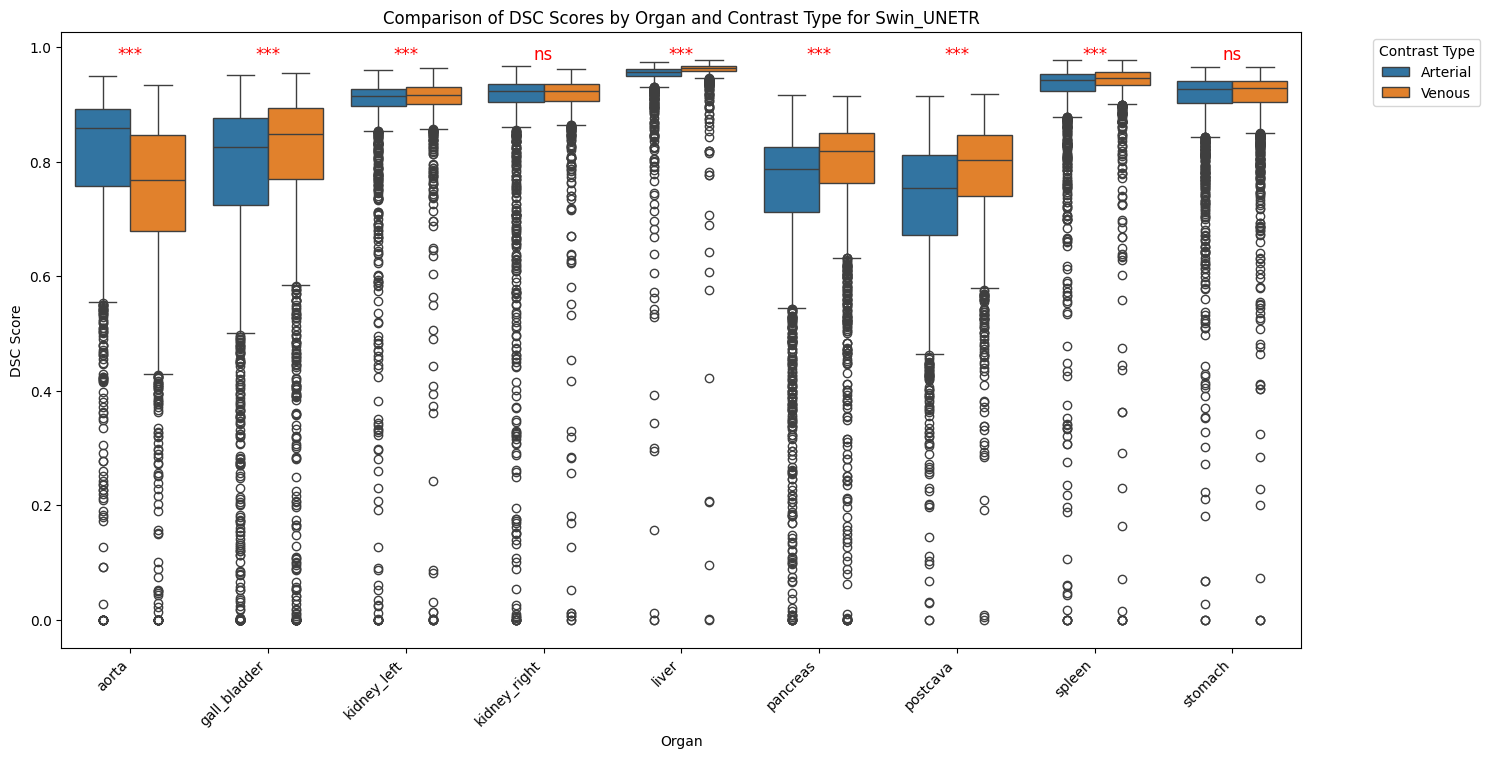

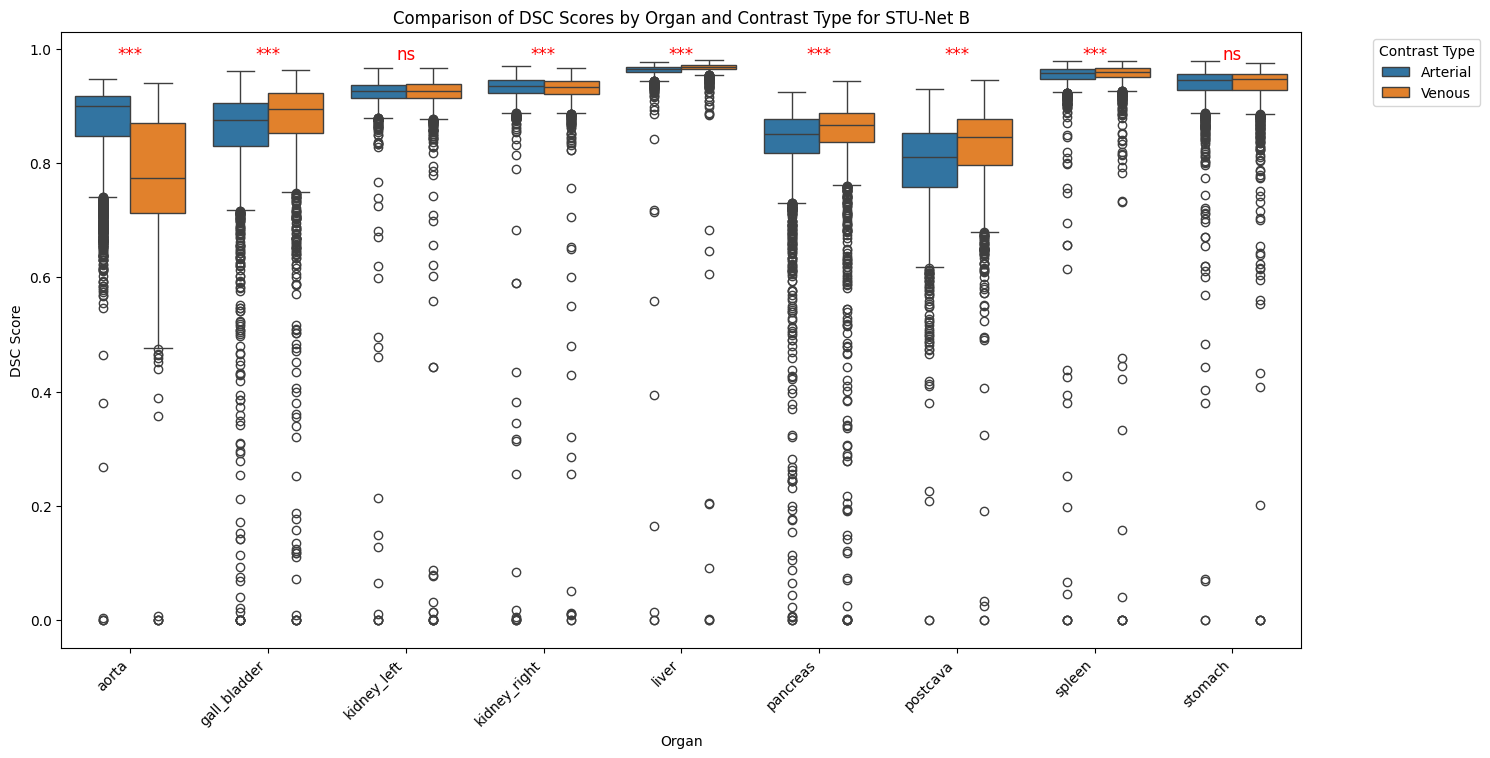

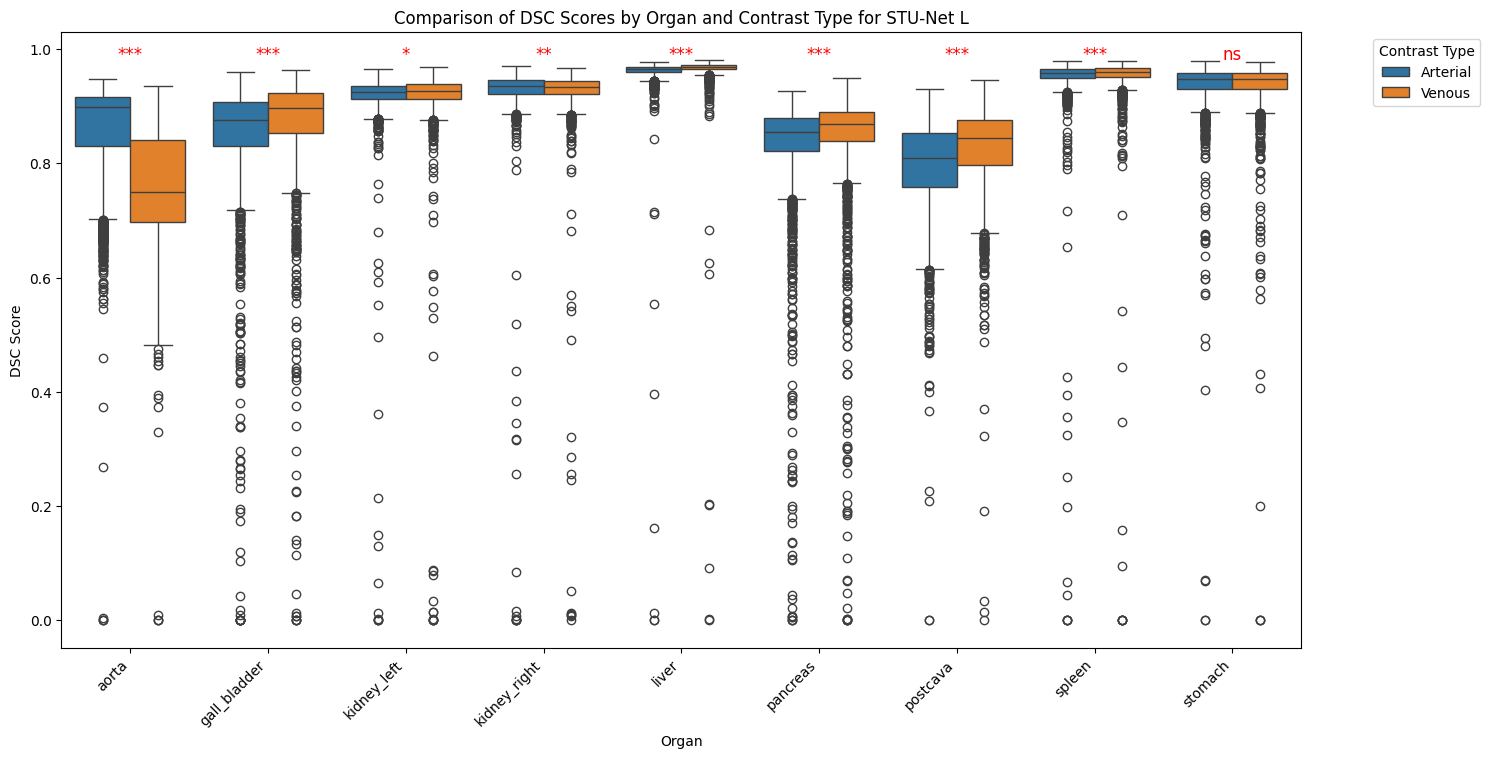

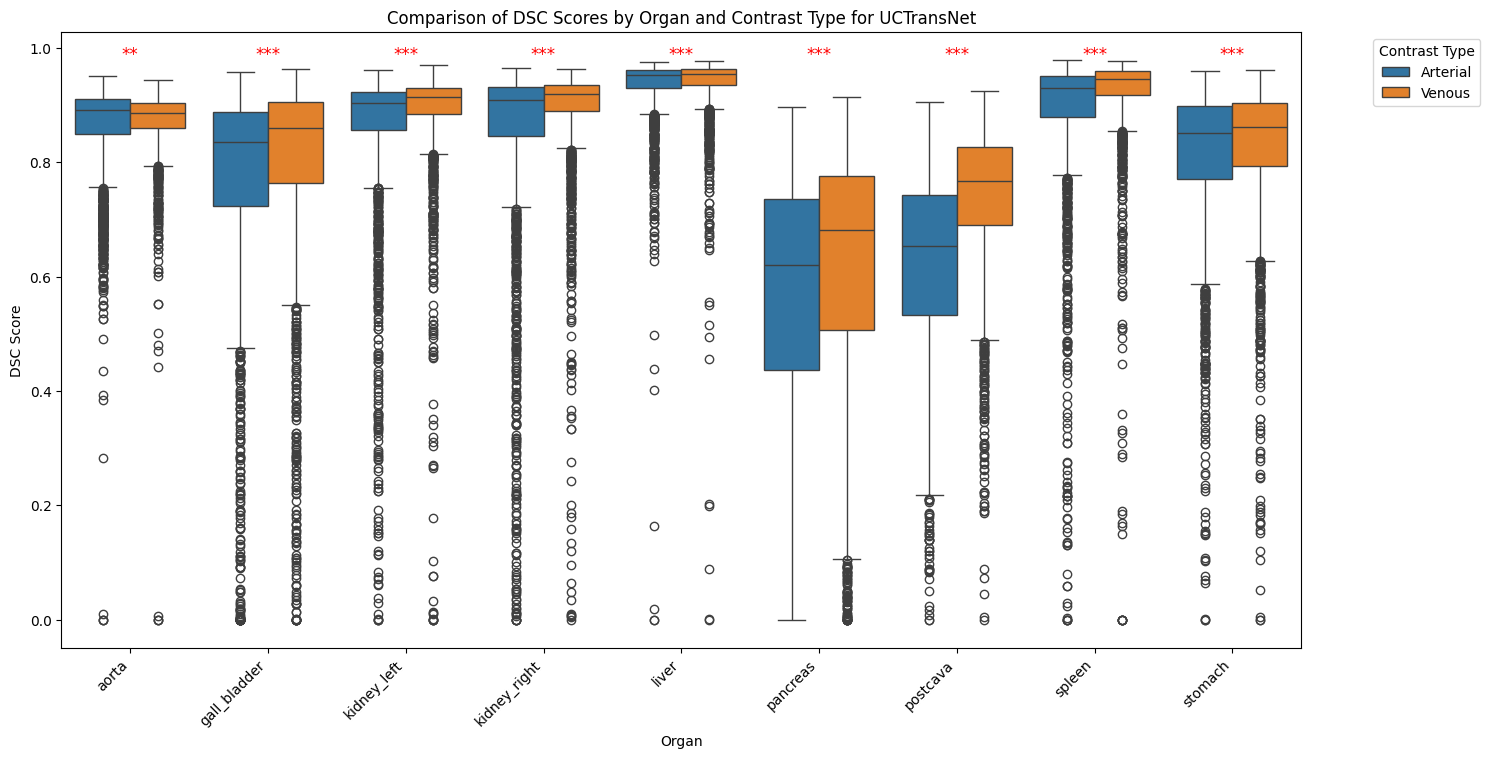

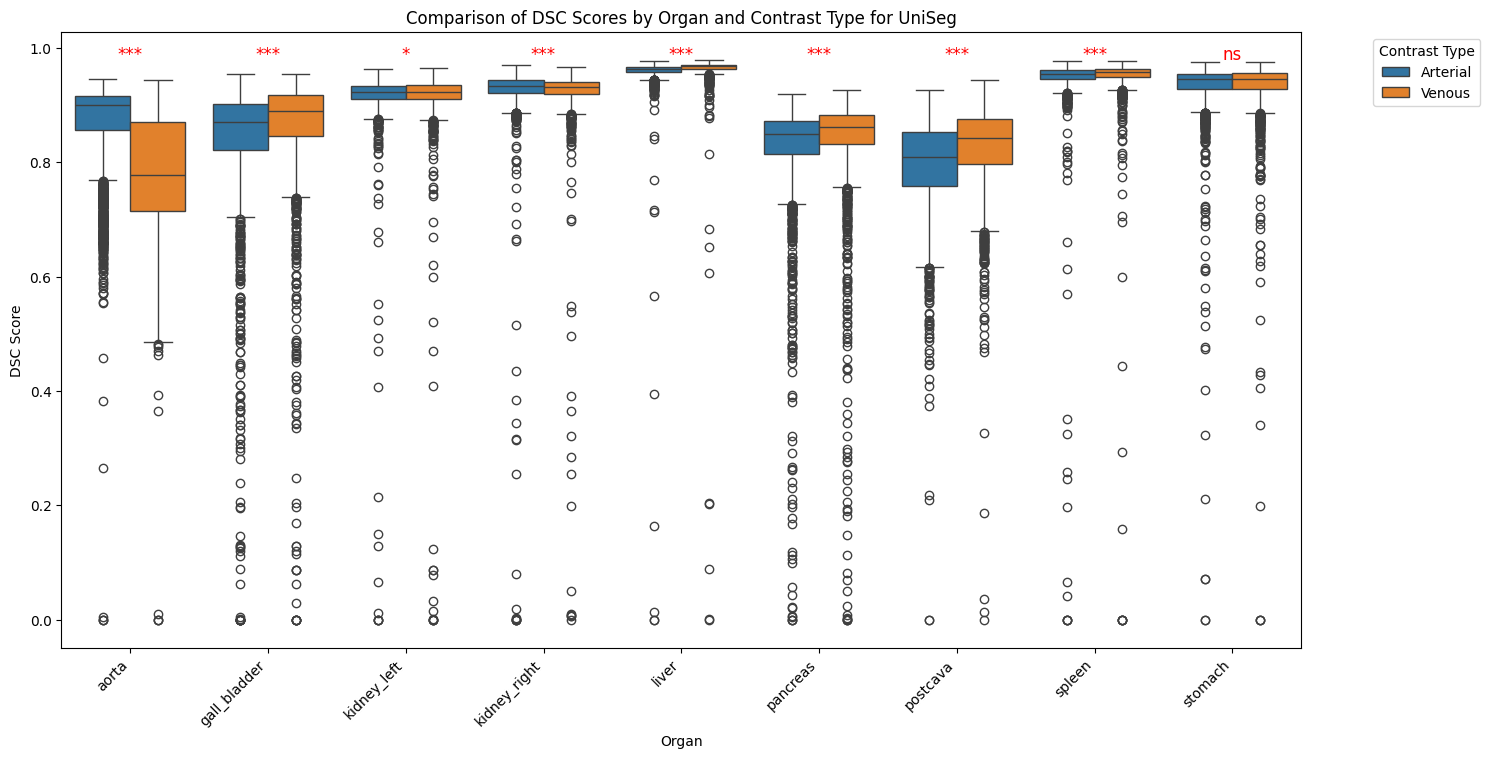

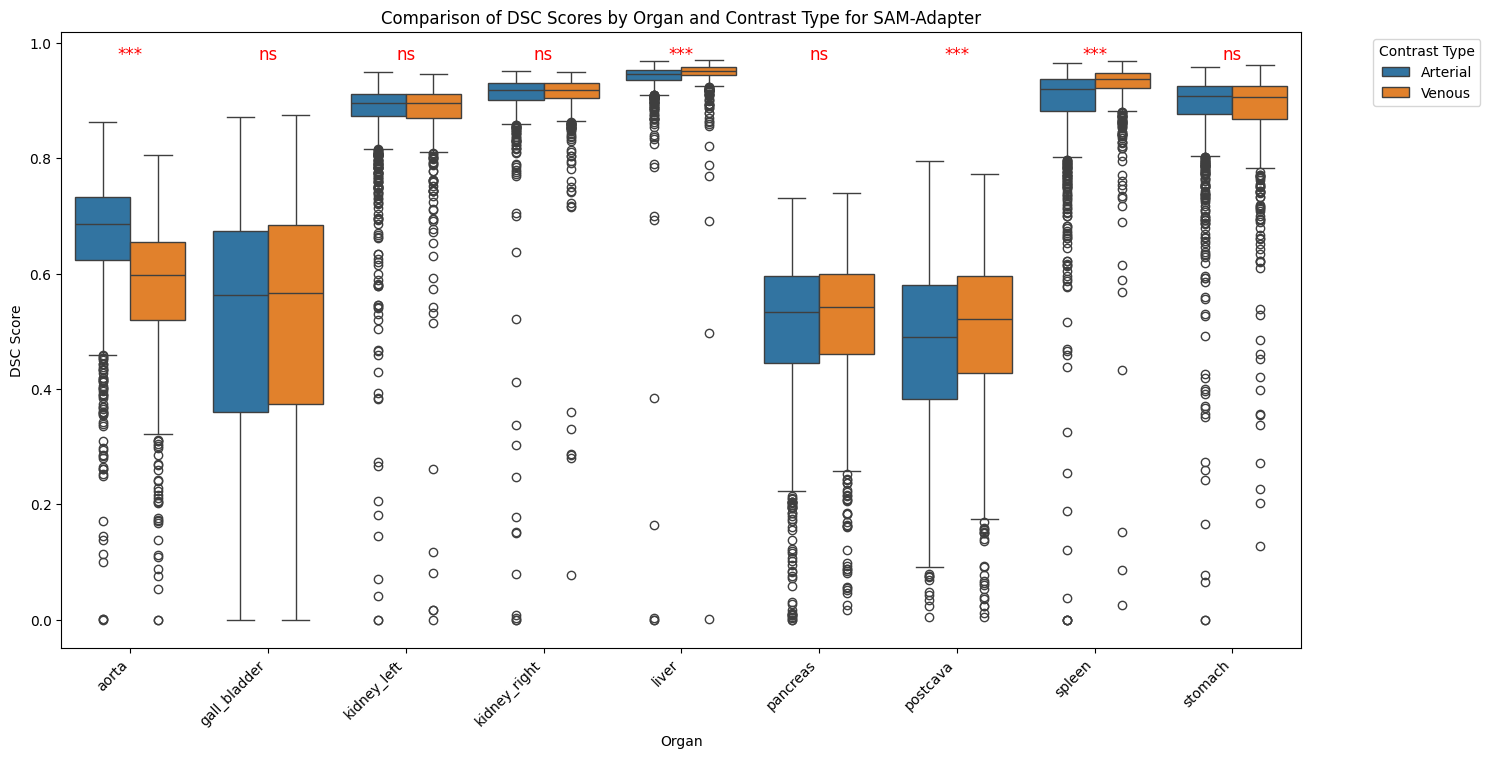

model         organ contrast_type       25%    Median       75%
0          Diff-UNet         aorta      Arterial  0.816194  0.898992  0.917759
1          Diff-UNet         aorta        Venous  0.698979  0.764698  0.868306
2          Diff-UNet  gall_bladder      Arterial  0.817736  0.873107  0.904659
3          Diff-UNet  gall_bladder        Venous  0.837829  0.891210  0.918717
4          Diff-UNet   kidney_left      Arterial  0.915555  0.928128  0.938000
..               ...           ...           ...       ...       ...       ...
337  nnU-Net_ResEncL      postcava        Venous  0.789263  0.840949  0.873823
338  nnU-Net_ResEncL        spleen      Arterial  0.948727  0.957688  0.964412
339  nnU-Net_ResEncL        spleen        Venous  0.953196  0.961891  0.967700
340  nnU-Net_ResEncL       stomach      Arterial  0.929985  0.946646  0.956642
341  nnU-Net_ResEncL       stomach        Venous  0.929002  0.946697  0.957246

[342 rows x 6 columns]

In [8]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

extract_folder = "final_14dec2024_results"

# === STEP 2: Load Metadata ===
metadata_path = os.path.join(extract_folder, "jhh_results - table 2 in paper", "jhh_metadata - for version 20.csv")
metadata_df = pd.read_csv(metadata_path)

# Get valid patient IDs
metadata_ids = set(metadata_df["name"].unique())

# === STEP 3: Load Model Performance Data ===
performance_data = []

for root, dirs, files in os.walk(os.path.join(extract_folder, "jhh_results - table 2 in paper")):
    model_name = os.path.basename(root)
    if "dsc.csv" in files:
        file_path = os.path.join(root, "dsc.csv")
        df = pd.read_csv(file_path)

        # Keep only patients that exist in the metadata
        df = df[df["name"].isin(metadata_ids)]

        # Extract contrast type (Arterial 'A' or Venous 'V')
        df["contrast_type"] = df["name"].apply(lambda x: "Arterial" if "_A" in x else "Venous")
        df["model"] = model_name

        performance_data.append(df)

# Concatenate all model data
performance_df = pd.concat(performance_data, ignore_index=True)

# === STEP 4: Reshape Data for Model and Organ Analysis ===
performance_melted = performance_df.melt(
    id_vars=["name", "contrast_type", "model"],
    var_name="organ",
    value_name="dsc_score",
)

performance_melted.dropna(inplace=True)

# === STEP 5: Perform Mann-Whitney U Test for Each Organ and Model Separately ===
stat_results_model_organ = []

for model in performance_melted["model"].unique():
    model_data = performance_melted[performance_melted["model"] == model]

    for organ in model_data["organ"].unique():
        organ_data = model_data[model_data["organ"] == organ]
        arterial_scores = organ_data[organ_data["contrast_type"] == "Arterial"]["dsc_score"].dropna()
        venous_scores = organ_data[organ_data["contrast_type"] == "Venous"]["dsc_score"].dropna()

        if len(arterial_scores) > 0 and len(venous_scores) > 0:
            mw_stat, p_value = mannwhitneyu(arterial_scores, venous_scores, alternative="two-sided")
        else:
            mw_stat, p_value = None, None

        stat_results_model_organ.append({
            "model": model,
            "organ": organ,
            "mw_stat": mw_stat,
            "p_value": p_value
        })

# Convert to DataFrame
stat_results_model_organ_df = pd.DataFrame(stat_results_model_organ)

# === STEP 6: Create Boxplots Per Model and Organ With Significance Markers ===
for model in performance_melted["model"].unique():
    plt.figure(figsize=(16, 8))
    model_data = performance_melted[performance_melted["model"] == model]
    ax = sns.boxplot(x="organ", y="dsc_score", hue="contrast_type", data=model_data)
    plt.title(f"Comparison of DSC Scores by Organ and Contrast Type for {model}")
    plt.xlabel("Organ")
    plt.ylabel("DSC Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Contrast Type", loc="upper right", bbox_to_anchor=(1.15, 1))

    # Add significance markers for each organ in this model
    for i, organ in enumerate(stat_results_model_organ_df["organ"].unique()):
        p_val = stat_results_model_organ_df[
            (stat_results_model_organ_df["model"] == model) &
            (stat_results_model_organ_df["organ"] == organ)
        ]["p_value"].values

        if len(p_val) > 0:
            p_val = p_val[0]
            if p_val is not None:
                if p_val > 0.05:
                    significance = "ns"
                elif p_val <= 0.05 and p_val > 0.01:
                    significance = "*"
                elif p_val <= 0.01 and p_val > 0.001:
                    significance = "**"
                else:
                    significance = "***"
                ax.text(i, model_data["dsc_score"].max(), significance, ha="center", fontsize=12, color="red")

    plt.show()

# === STEP 7: Compute IQR (25%, Median, 75%) for Each Model and Organ ===
iqr_summary_organ = performance_melted.groupby(["model", "organ", "contrast_type"])["dsc_score"].quantile([0.25, 0.5, 0.75]).unstack()
iqr_summary_organ.columns = ["25%", "Median", "75%"]
iqr_summary_organ.reset_index(inplace=True)

# Display the IQR Table (Per Model and Organ)
from IPython.display import display
display(iqr_summary_organ)

### <font color="cyan"> 🔬 Perf. Differs by Organ. Is this Consistent Across Models?</font>

<font color="green">🧪 Yes it is!</font>

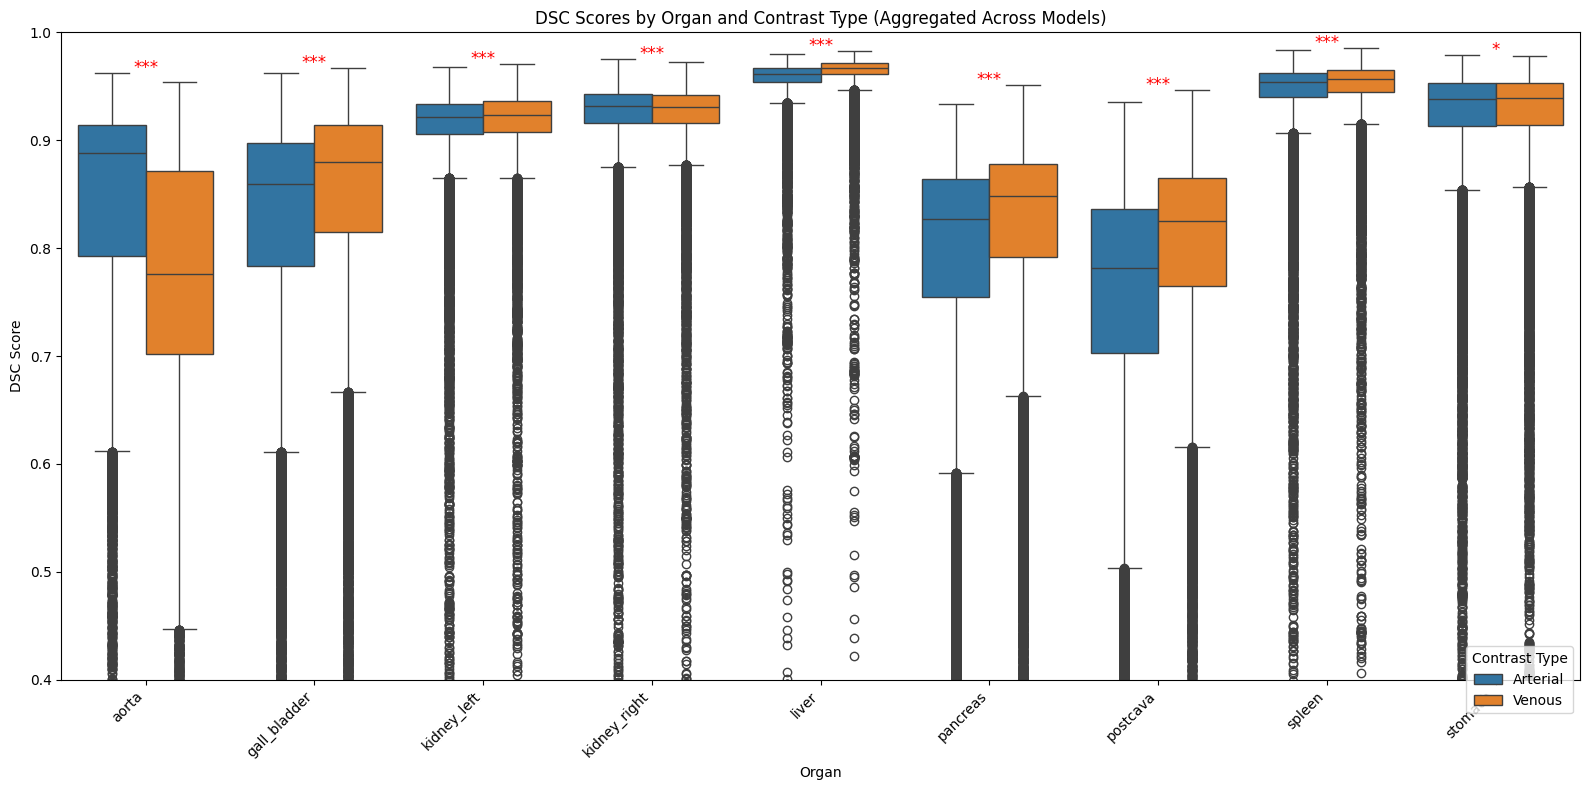

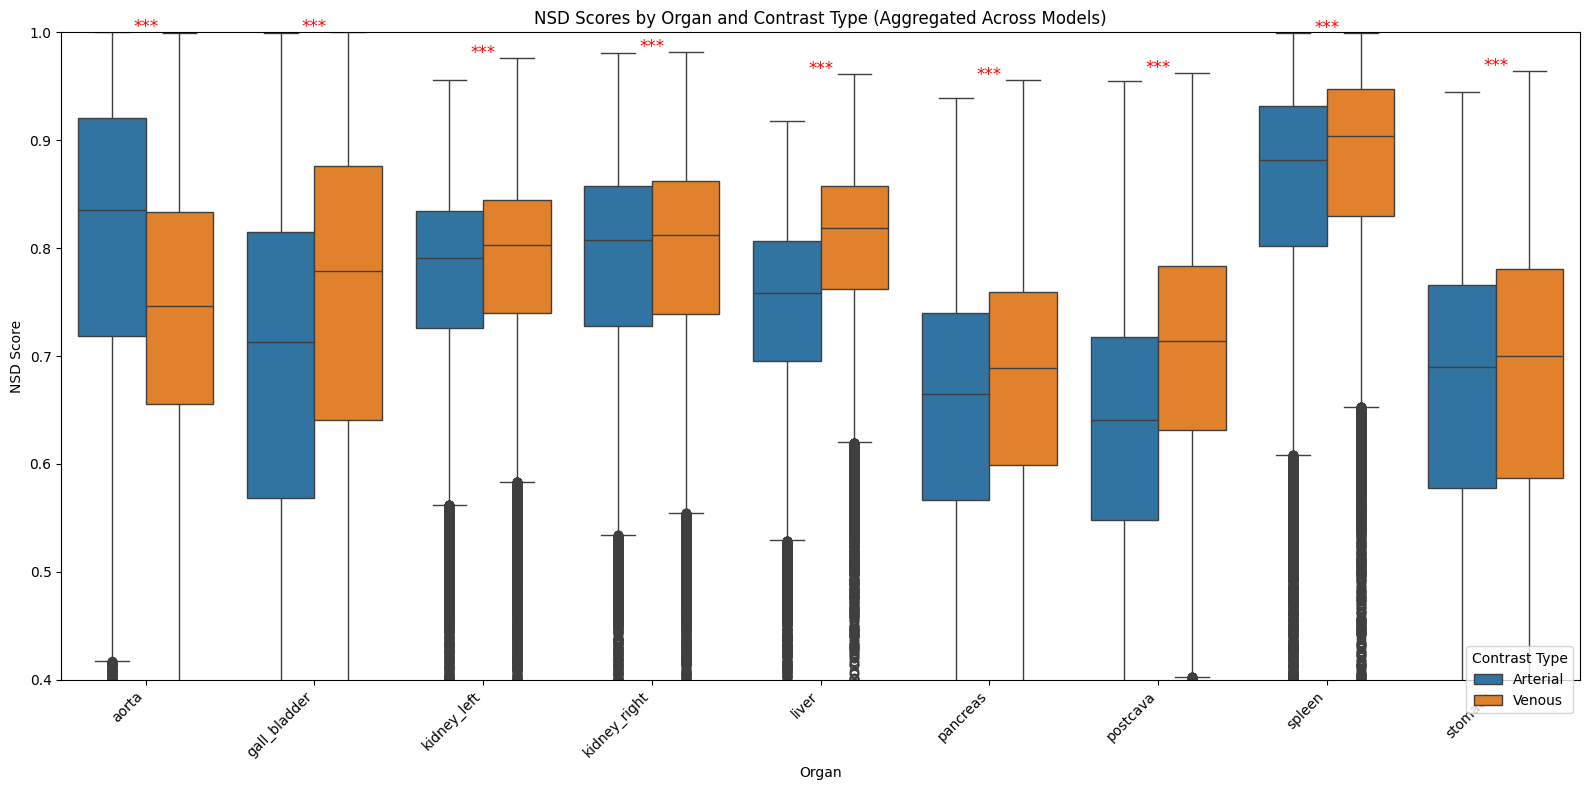

In [6]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

extract_folder = "../final_14dec2024_results"

# === STEP 2: Load Metadata ===
metadata_path = os.path.join(extract_folder, "jhh_results - table 2 in paper", "jhh_metadata - for version 20.csv")
metadata_df = pd.read_csv(metadata_path)

metadata_ids = set(metadata_df["name"].unique())

# === STEP 3: Load DSC and NSD Data Across All Models ===
dsc_data, nsd_data = [], []

for root, dirs, files in os.walk(os.path.join(extract_folder, "jhh_results - table 2 in paper")):
    model_name = os.path.basename(root)

    if "dsc.csv" in files:
        dsc_df = pd.read_csv(os.path.join(root, "dsc.csv"))
        dsc_df = dsc_df[dsc_df["name"].isin(metadata_ids)]
        dsc_df["contrast_type"] = dsc_df["name"].apply(lambda x: "Arterial" if "_A" in x else "Venous")
        dsc_df["model"] = model_name
        dsc_data.append(dsc_df)

    if "nsd.csv" in files:
        nsd_df = pd.read_csv(os.path.join(root, "nsd.csv"))
        nsd_df = nsd_df[nsd_df["name"].isin(metadata_ids)]
        nsd_df["contrast_type"] = nsd_df["name"].apply(lambda x: "Arterial" if "_A" in x else "Venous")
        nsd_df["model"] = model_name
        nsd_data.append(nsd_df)

# === STEP 4: Combine and Reshape Data ===
dsc_df = pd.concat(dsc_data, ignore_index=True)
nsd_df = pd.concat(nsd_data, ignore_index=True)

dsc_melted = dsc_df.melt(id_vars=["name", "contrast_type", "model"], var_name="organ", value_name="dsc_score")
nsd_melted = nsd_df.melt(id_vars=["name", "contrast_type", "model"], var_name="organ", value_name="nsd_score")

dsc_melted.dropna(inplace=True)
nsd_melted.dropna(inplace=True)

# === STEP 5: Define a function to add significance markers ===
def add_significance(ax, df, score_col):
    organs = df["organ"].unique()
    for i, organ in enumerate(organs):
        organ_data = df[df["organ"] == organ]
        arterial = organ_data[organ_data["contrast_type"] == "Arterial"][score_col]
        venous = organ_data[organ_data["contrast_type"] == "Venous"][score_col]

        if len(arterial) > 0 and len(venous) > 0:
            stat, p = mannwhitneyu(arterial, venous, alternative="two-sided")

            # Assign significance level
            if p > 0.05:
                sig = "ns"
            elif p <= 0.05 and p > 0.01:
                sig = "*"
            elif p <= 0.01 and p > 0.001:
                sig = "**"
            else:
                sig = "***"

            max_val = organ_data[score_col].max()
            ax.text(i, max_val, sig, ha="center", color="red", fontsize=12)

# === STEP 6: Plot DSC Boxplot with Significance ===
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="organ", y="dsc_score", hue="contrast_type", data=dsc_melted)
plt.title("DSC Scores by Organ and Contrast Type (Aggregated Across Models)")
plt.xlabel("Organ")
plt.ylabel("DSC Score")
plt.xticks(rotation=45, ha="right")
add_significance(ax, dsc_melted, "dsc_score")
plt.legend(title="Contrast Type", loc="center right", bbox_to_anchor=(1, 0))
plt.ylim(0.4, 1)  # <--- Add this line
plt.tight_layout()
plt.show()

# === STEP 7: Plot NSD Boxplot with Significance ===
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="organ", y="nsd_score", hue="contrast_type", data=nsd_melted)
plt.title("NSD Scores by Organ and Contrast Type (Aggregated Across Models)")
plt.xlabel("Organ")
plt.ylabel("NSD Score")
plt.xticks(rotation=45, ha="right")
add_significance(ax, nsd_melted, "nsd_score")
plt.legend(title="Contrast Type", loc="center right", bbox_to_anchor=(1, 0))
plt.ylim(0.4, 1)  # <--- Add this line
plt.tight_layout()
plt.show()